In [106]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [107]:
L = 4 #system size
M = 0.1 #fermion mass
N=4 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [108]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [109]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [110]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [111]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [112]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [113]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [114]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [115]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [116]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [117]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

#for i in range(LL+1):
#    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 0.1*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [118]:
print(np.allclose(full_ham_matrix.toarray(), full_ham_matrix.toarray().T.conj(), rtol=1e-8, atol=1e-8))

True


In [119]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-0.92917693 -0.31306811 -0.1043844 ]


In [120]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [121]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.49289322]
(-0.06806662991644631-0.011497651063229386j)|2 2 0 1>
(0.1538111374012297+0.025981406595987203j)|2 2 0 0>
(-0.27847989722901434-0.04704015301467954j)|2 1 1 1>
(0.07437260812143631+0.012562841702200489j)|2 1 0 1>
(0.0680666299164463+0.011497651063229405j)|2 1 0 0>
(-0.2784798972290141-0.0470401530146795j)|1 1 1 2>
(0.7649468114645566+0.12921297162714884j)|1 1 1 1>
(-0.2784798972290142-0.04704015301467959j)|1 1 0 1>
(0.06806662991644641+0.011497651063229437j)|1 0 2 2>
(0.07437260812143605+0.012562841702200414j)|1 0 1 2>
(-0.27847989722901456-0.047040153014679495j)|1 0 1 1>
(0.15381113740122979+0.025981406595987168j)|0 0 2 2>
(-0.06806662991644637-0.011497651063229437j)|0 0 1 2>



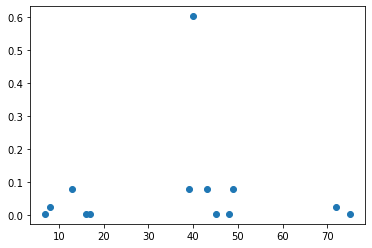

In [122]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [135]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma/2)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod



def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    sigma_big = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        sigma_big[k] = tensprod
    for k in range(L):
        for kk in range(k,L):
            summe += 1./(2-(k+kk)%2)**2*(sigma_big[k]+sigma_big[kk])@(sigma_big[k]+sigma_big[kk])
    return summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)



def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()


In [136]:
#initial state
string_0 = "1111"
#for i in range(L):
#    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string_0)

psi_0[i_0] = 1.


In [137]:
import optuna
n_iter = 3000
theta = np.zeros(5*N)

#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        theta[5*i+0] = trial.suggest_float("5*"+str(i)+"+"+str(0), -8*np.pi, 8*np.pi)
        for j in range(1,5):
            theta[5*i+j] = trial.suggest_float("5*"+str(i)+"+"+str(j), -4*np.pi, 4*np.pi)

        
            
    for i in range(N):
        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(3,0,2,0,theta[5*i+2])@rot_sigma(3,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(1,0,2,0,theta[5*i+4])@rot_sigma(1,0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(2,0,2,0,theta[5*i+4])@rot_sigma(2,0,1,0,theta[5*i+3])@psi_var


    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler)
study.optimize(cost_function_sigma, n_trials=n_iter)

[I 2022-05-09 11:45:01,881] A new study created in memory with name: no-name-63ade670-7f6e-4311-8883-c71f130035e8
[I 2022-05-09 11:45:02,057] Trial 0 finished with value: 3.396398223949545 and parameters: {'5*0+0': 4.029425891847509, '5*0+1': -7.29749775602946, '5*0+2': 0.1141430803812078, '5*0+3': 9.77105182376172, '5*0+4': 9.412669129761216, '5*1+0': 7.3849935541121425, '5*1+1': 6.837952225001207, '5*1+2': -6.899372239986265, '5*1+3': -8.071631525050748, '5*1+4': 2.0640481764385967, '5*2+0': 8.145497634618764, '5*2+1': -8.47016577359334, '5*2+2': 9.723070571014713, '5*2+3': -5.896425497550626, '5*2+4': 11.453170559163016, '5*3+0': 16.03449821394988, '5*3+1': 9.72621691218972, '5*3+2': -8.392016078546325, '5*3+3': 8.559636580319552, '5*3+4': -1.5318200675455635}. Best is trial 0 with value: 3.396398223949545.
[I 2022-05-09 11:45:02,181] Trial 1 finished with value: 4.062102570924797 and parameters: {'5*0+0': 1.5160675590910937, '5*0+1': 1.9614296648396323, '5*0+2': 2.014458739262164, 

[I 2022-05-09 11:45:03,527] Trial 11 finished with value: 2.7801275340882694 and parameters: {'5*0+0': -1.3805032281624159, '5*0+1': -1.1555957968857489, '5*0+2': -1.94224470093972, '5*0+3': 9.016530479085546, '5*0+4': -3.600411960519621, '5*1+0': -0.9751703270405989, '5*1+1': 3.8198705014041985, '5*1+2': 4.705013345735688, '5*1+3': -8.321821998004236, '5*1+4': -5.215957693646975, '5*2+0': -6.527329202291567, '5*2+1': 5.2806443629274575, '5*2+2': -10.108333070979457, '5*2+3': -1.0341106306078132, '5*2+4': -4.587574028247335, '5*3+0': -8.496138677364744, '5*3+1': 0.48533029547025697, '5*3+2': 1.5797134108518018, '5*3+3': 1.7863594754575716, '5*3+4': -5.489753921612514}. Best is trial 3 with value: 2.6354288950272395.
[I 2022-05-09 11:45:03,643] Trial 12 finished with value: 3.9041528900375737 and parameters: {'5*0+0': -0.19661387746562847, '5*0+1': 5.189011522945726, '5*0+2': 0.6078648693317207, '5*0+3': -4.416758960348539, '5*0+4': 4.956537081522284, '5*1+0': 0.6081981353885542, '5*1+1

[I 2022-05-09 11:45:05,068] Trial 23 finished with value: 3.707067569703742 and parameters: {'5*0+0': 0.5906680577312752, '5*0+1': -0.229711726370589, '5*0+2': -3.091121496728788, '5*0+3': 6.044151276505471, '5*0+4': -0.8595734905501714, '5*1+0': 7.356569399340076, '5*1+1': 2.294594256181109, '5*1+2': -2.3078327094792304, '5*1+3': -4.979609129182823, '5*1+4': 2.8003347295550425, '5*2+0': -4.3032154502042985, '5*2+1': -3.870064837521932, '5*2+2': -0.26684549736365715, '5*2+3': -4.410481235343473, '5*2+4': -0.9244994847486019, '5*3+0': -0.8356656589145496, '5*3+1': 2.994287836020909, '5*3+2': 0.5367458366926725, '5*3+3': -1.832281384583319, '5*3+4': -9.501236952239283}. Best is trial 3 with value: 2.6354288950272395.
[I 2022-05-09 11:45:05,200] Trial 24 finished with value: 3.95790551604238 and parameters: {'5*0+0': -0.27414799589749883, '5*0+1': -4.187996602265175, '5*0+2': -4.0037373328500365, '5*0+3': 1.6133490723276043, '5*0+4': -4.224571235031022, '5*1+0': -1.6188287010034599, '5*1+

[I 2022-05-09 11:45:06,807] Trial 35 finished with value: 4.4722561700267605 and parameters: {'5*0+0': 4.234725172448174, '5*0+1': 0.6799242303091413, '5*0+2': -8.473866927344039, '5*0+3': 3.464949164996555, '5*0+4': 3.9136574645730473, '5*1+0': -6.453970033295331, '5*1+1': -4.424542453088508, '5*1+2': 0.21018843338142104, '5*1+3': -3.8197397529517376, '5*1+4': 2.0223013415101634, '5*2+0': -2.363350203007795, '5*2+1': -6.5109364973603885, '5*2+2': 4.143647546278062, '5*2+3': -8.898770651466291, '5*2+4': -1.9151385967059142, '5*3+0': 0.17505900136383656, '5*3+1': 4.49565705898592, '5*3+2': 5.818802823893829, '5*3+3': 3.3404015565858147, '5*3+4': -2.826662219516162}. Best is trial 3 with value: 2.6354288950272395.
[I 2022-05-09 11:45:06,923] Trial 36 finished with value: 3.0350508425801004 and parameters: {'5*0+0': -7.072197741889447, '5*0+1': -7.942115768978808, '5*0+2': 0.6185078542388571, '5*0+3': 5.331142780481939, '5*0+4': 2.940521746903511, '5*1+0': -5.16264974783873, '5*1+1': -3.9

[I 2022-05-09 11:45:08,513] Trial 47 finished with value: 3.7082300067224288 and parameters: {'5*0+0': -3.1836539578061553, '5*0+1': -9.476898761186888, '5*0+2': -1.0245359211822436, '5*0+3': 5.170793792292462, '5*0+4': 4.364510722462592, '5*1+0': -4.531244836978079, '5*1+1': 9.088342860083877, '5*1+2': -1.3536131182675466, '5*1+3': -10.247890105547768, '5*1+4': -3.061091873460001, '5*2+0': -1.5454481034618985, '5*2+1': -0.23374092432247817, '5*2+2': -0.576822094027627, '5*2+3': -7.862309115188816, '5*2+4': -8.832167772035486, '5*3+0': 0.5590384913616642, '5*3+1': -0.6244239163503951, '5*3+2': -5.666782873842316, '5*3+3': 0.6784456522758093, '5*3+4': 3.3369317438300214}. Best is trial 3 with value: 2.6354288950272395.
[I 2022-05-09 11:45:08,647] Trial 48 finished with value: 3.64840859563947 and parameters: {'5*0+0': -2.100236438088263, '5*0+1': -6.095676776913958, '5*0+2': 0.378819354944711, '5*0+3': 3.5078171243001117, '5*0+4': 0.14561418239976986, '5*1+0': -2.7913922056269413, '5*1+

[I 2022-05-09 11:45:10,279] Trial 59 finished with value: 3.886484718391433 and parameters: {'5*0+0': -9.934134431581832, '5*0+1': -4.461627117941854, '5*0+2': 2.89738561790256, '5*0+3': 5.031496461437482, '5*0+4': 7.099880866438324, '5*1+0': 4.912034716670742, '5*1+1': -1.694998485890888, '5*1+2': -3.24112135325858, '5*1+3': -5.663469341151982, '5*1+4': -4.079923647036136, '5*2+0': 5.19807022211336, '5*2+1': -3.2933868493132072, '5*2+2': -2.3023880329739814, '5*2+3': -5.273578129067513, '5*2+4': -1.6308702355775087, '5*3+0': -4.659381400231732, '5*3+1': 2.083697378171134, '5*3+2': -9.106955303560625, '5*3+3': 1.6153645818470252, '5*3+4': -1.4727446596116502}. Best is trial 3 with value: 2.6354288950272395.
[I 2022-05-09 11:45:10,408] Trial 60 finished with value: 3.3397340319461426 and parameters: {'5*0+0': -10.745273489775633, '5*0+1': -4.219987621875017, '5*0+2': 7.137098515928439, '5*0+3': 5.51408596577298, '5*0+4': 7.580691384450809, '5*1+0': -11.871999418578573, '5*1+1': 3.916471

[I 2022-05-09 11:45:11,811] Trial 71 finished with value: 4.363467272755026 and parameters: {'5*0+0': -7.323206901907863, '5*0+1': -6.231457031107514, '5*0+2': 0.6053741887713013, '5*0+3': 1.8733903363188136, '5*0+4': 5.251356541071865, '5*1+0': -7.916666092149107, '5*1+1': 1.9587670517865479, '5*1+2': -6.148625948356294, '5*1+3': -1.0482276585151276, '5*1+4': 3.840007271907436, '5*2+0': 0.9553279455542578, '5*2+1': -11.794342057223744, '5*2+2': -5.914289617940864, '5*2+3': -2.6581186002544763, '5*2+4': 2.059596120693754, '5*3+0': -6.778877061132422, '5*3+1': 1.718638228323039, '5*3+2': 4.600598775005769, '5*3+3': -2.660079930904919, '5*3+4': -2.7122314556603144}. Best is trial 3 with value: 2.6354288950272395.
[I 2022-05-09 11:45:11,944] Trial 72 finished with value: 4.996872928904195 and parameters: {'5*0+0': -7.776123465058054, '5*0+1': -10.406676888742483, '5*0+2': 6.144935584183493, '5*0+3': 4.081264387928799, '5*0+4': 4.0566657762724905, '5*1+0': -5.057923435332207, '5*1+1': 1.53

[I 2022-05-09 11:45:13,595] Trial 83 finished with value: 3.8282104920496614 and parameters: {'5*0+0': -1.6097815374579927, '5*0+1': -6.889501266662181, '5*0+2': -2.5724428258471668, '5*0+3': 4.628406363429674, '5*0+4': 4.461975944843665, '5*1+0': -7.287600456778786, '5*1+1': 7.3483024277388305, '5*1+2': -3.856306414094125, '5*1+3': 1.007810103656438, '5*1+4': 0.9111559595451948, '5*2+0': -0.9065748016877879, '5*2+1': -9.553161098553431, '5*2+2': -3.8175775534222947, '5*2+3': -7.040856989068856, '5*2+4': -0.23984607573584205, '5*3+0': -0.7446826680264537, '5*3+1': -0.7209894479980437, '5*3+2': -4.190627862504508, '5*3+3': 1.7019906159890268, '5*3+4': 0.7082981394041213}. Best is trial 75 with value: 2.547547799391128.
[I 2022-05-09 11:45:13,755] Trial 84 finished with value: 2.1534007252868794 and parameters: {'5*0+0': -0.7137226843302553, '5*0+1': -5.9630105566316525, '5*0+2': 0.5019951407821885, '5*0+3': 9.34546768795365, '5*0+4': 3.372822123235811, '5*1+0': -7.16744101097057, '5*1+1

[I 2022-05-09 11:45:15,330] Trial 95 finished with value: 2.9412971323253227 and parameters: {'5*0+0': -4.311777984131609, '5*0+1': -3.5009063976753128, '5*0+2': 0.9652030795120002, '5*0+3': -1.0385957985996965, '5*0+4': 4.70439060934114, '5*1+0': 0.45196380764922495, '5*1+1': -1.09736461314429, '5*1+2': 0.6632781890971344, '5*1+3': 1.9391610974919202, '5*1+4': 4.781911956830881, '5*2+0': 3.3768911655742, '5*2+1': -3.156545243988237, '5*2+2': -10.21796555161542, '5*2+3': -2.419186882262906, '5*2+4': 6.470952242105505, '5*3+0': -0.7496471164312424, '5*3+1': 0.12547934525171672, '5*3+2': -4.547978904518434, '5*3+3': 0.6638947371504462, '5*3+4': 1.9437760597163498}. Best is trial 84 with value: 2.1534007252868794.
[I 2022-05-09 11:45:15,447] Trial 96 finished with value: 2.8696062097078276 and parameters: {'5*0+0': -10.077979414234882, '5*0+1': -6.425604520528283, '5*0+2': -0.5651885800029786, '5*0+3': 6.76525132824425, '5*0+4': 5.481370494844631, '5*1+0': -5.899194496493655, '5*1+1': -5.

[I 2022-05-09 11:45:17,135] Trial 107 finished with value: 4.16806420275649 and parameters: {'5*0+0': 0.7855712479241603, '5*0+1': -6.50293745682169, '5*0+2': -3.6415559549815315, '5*0+3': 3.4705787586799834, '5*0+4': 6.121719438278278, '5*1+0': -6.740090139992983, '5*1+1': -4.5784624850877425, '5*1+2': 5.698218053264895, '5*1+3': -4.203256133085857, '5*1+4': 3.1464326834512195, '5*2+0': -1.584016262112272, '5*2+1': -8.631835096834154, '5*2+2': -6.131590452349589, '5*2+3': -1.707231161409251, '5*2+4': 5.419883792507107, '5*3+0': 2.233938824717351, '5*3+1': 1.8176066821928167, '5*3+2': -5.83667615268472, '5*3+3': 1.8094591386932866, '5*3+4': -2.1079573690861055}. Best is trial 84 with value: 2.1534007252868794.
[I 2022-05-09 11:45:17,319] Trial 108 finished with value: 2.972848088383476 and parameters: {'5*0+0': -6.625506228848009, '5*0+1': -5.264161278587436, '5*0+2': 4.0562635838261265, '5*0+3': 4.689523444413046, '5*0+4': 6.202029844619184, '5*1+0': 2.088150752095128, '5*1+1': -4.077

[I 2022-05-09 11:45:19,512] Trial 119 finished with value: 3.7849752023234196 and parameters: {'5*0+0': -3.3299108141963685, '5*0+1': -4.005819094603254, '5*0+2': -0.10154542655529553, '5*0+3': 3.425025897789576, '5*0+4': 7.505441138444374, '5*1+0': 0.4424385887067175, '5*1+1': -0.8474582487277009, '5*1+2': 1.0132059590233866, '5*1+3': -8.729884861880356, '5*1+4': 3.574182605500149, '5*2+0': 3.219731943444061, '5*2+1': -6.475658277821943, '5*2+2': -8.315089471808385, '5*2+3': -6.314744169606598, '5*2+4': 4.142714370750353, '5*3+0': 1.046757223754431, '5*3+1': 7.090686251938411, '5*3+2': 2.022110736221119, '5*3+3': -1.979033999691787, '5*3+4': -2.5933482771772893}. Best is trial 84 with value: 2.1534007252868794.
[I 2022-05-09 11:45:19,676] Trial 120 finished with value: 3.092093755536492 and parameters: {'5*0+0': -10.975679068296671, '5*0+1': -5.101985771154474, '5*0+2': 1.6835500124344152, '5*0+3': 1.3446638481335884, '5*0+4': 6.88364764106649, '5*1+0': -2.4817808053361854, '5*1+1': 0

[I 2022-05-09 11:45:21,653] Trial 131 finished with value: 3.5385951636531763 and parameters: {'5*0+0': -6.299509136863917, '5*0+1': -5.346160506559004, '5*0+2': -0.7584249182692027, '5*0+3': 1.6635247670315538, '5*0+4': 7.6914134355301, '5*1+0': 5.047377436081822, '5*1+1': -0.1681863392501608, '5*1+2': 0.12406930452352438, '5*1+3': -2.881335274378677, '5*1+4': -2.55919663110713, '5*2+0': 5.047147390396898, '5*2+1': 2.3612813296027015, '5*2+2': -8.912109283198246, '5*2+3': -3.9463611763954596, '5*2+4': 9.493046134432507, '5*3+0': -8.322815345042748, '5*3+1': 1.6559509805478618, '5*3+2': 4.913046488471178, '5*3+3': 0.7409906554018509, '5*3+4': -0.008600546261994912}. Best is trial 84 with value: 2.1534007252868794.
[I 2022-05-09 11:45:21,841] Trial 132 finished with value: 3.78596834581681 and parameters: {'5*0+0': -3.6842205670729875, '5*0+1': -0.28395961903287503, '5*0+2': 0.11542654936510233, '5*0+3': 2.341668489543263, '5*0+4': 4.454549919839369, '5*1+0': 3.1701176946688943, '5*1+1'

[I 2022-05-09 11:45:23,749] Trial 143 finished with value: 3.7173770158805164 and parameters: {'5*0+0': -9.910346121031916, '5*0+1': -4.39090394117121, '5*0+2': -2.4704315841708375, '5*0+3': -0.43925352066499457, '5*0+4': 10.41185666587204, '5*1+0': 1.269135943041195, '5*1+1': -3.5628190073754955, '5*1+2': 1.6424091079352947, '5*1+3': -3.0951433864678197, '5*1+4': -0.7332411618239203, '5*2+0': 9.033274224076827, '5*2+1': -5.428055291593885, '5*2+2': -7.698937997787289, '5*2+3': -6.749266884857061, '5*2+4': -1.1144380253733188, '5*3+0': -1.435668776571093, '5*3+1': 2.7933584745971514, '5*3+2': -7.772051782114902, '5*3+3': -1.6221616835742805, '5*3+4': 3.9736387420995634}. Best is trial 84 with value: 2.1534007252868794.
[I 2022-05-09 11:45:23,914] Trial 144 finished with value: 3.7014487633093305 and parameters: {'5*0+0': -15.045686470933052, '5*0+1': -8.19554610350712, '5*0+2': -1.489543980503873, '5*0+3': -0.4671997407872275, '5*0+4': 8.379203580291277, '5*1+0': 3.588541061550388, '5*

[I 2022-05-09 11:45:25,965] Trial 155 finished with value: 2.5623486145759213 and parameters: {'5*0+0': -7.530582759356509, '5*0+1': -4.603315961613312, '5*0+2': -0.9919976431508508, '5*0+3': 8.145878106532253, '5*0+4': 6.267410628944038, '5*1+0': 6.388297119314751, '5*1+1': -2.4452497279580885, '5*1+2': 3.405284107724057, '5*1+3': 1.2930082220915182, '5*1+4': 5.022952299191724, '5*2+0': 4.447552036835117, '5*2+1': 1.4103393899906012, '5*2+2': -10.892467402398418, '5*2+3': -2.5184570569861107, '5*2+4': 6.3974783096612065, '5*3+0': -4.122605488889369, '5*3+1': 6.886820655753096, '5*3+2': -3.5426127880669815, '5*3+3': 1.8579527101937412, '5*3+4': 1.7604272135368881}. Best is trial 84 with value: 2.1534007252868794.
[I 2022-05-09 11:45:26,131] Trial 156 finished with value: 3.965931728611716 and parameters: {'5*0+0': -11.0294014286606, '5*0+1': -3.094941262747522, '5*0+2': 2.116403972042458, '5*0+3': 1.557416631618441, '5*0+4': 10.092252483834908, '5*1+0': 4.676544832487211, '5*1+1': -0.0

[I 2022-05-09 11:45:28,318] Trial 167 finished with value: 4.4540791675414395 and parameters: {'5*0+0': -6.891470126264311, '5*0+1': -0.7723962354316276, '5*0+2': -0.8234102623183632, '5*0+3': 6.5272964413907415, '5*0+4': 5.1810632512313015, '5*1+0': 9.57320916342831, '5*1+1': 2.3767897615693077, '5*1+2': 1.2575253412795842, '5*1+3': -4.654529465173656, '5*1+4': 2.534562832539002, '5*2+0': 4.3869024578108045, '5*2+1': 4.314938137596648, '5*2+2': -4.203717552521693, '5*2+3': -6.269902163062278, '5*2+4': 4.301752100332732, '5*3+0': -5.8404444213454845, '5*3+1': -2.921133088908529, '5*3+2': -4.017583763031141, '5*3+3': -1.0676285041662823, '5*3+4': 4.502260794225159}. Best is trial 84 with value: 2.1534007252868794.
[I 2022-05-09 11:45:28,541] Trial 168 finished with value: 3.7118029828514567 and parameters: {'5*0+0': -7.746459591523004, '5*0+1': -2.362301728479455, '5*0+2': 3.34378846144707, '5*0+3': 5.767413250137906, '5*0+4': 8.74357334623824, '5*1+0': 5.749754367655754, '5*1+1': -2.83

[I 2022-05-09 11:45:30,578] Trial 179 finished with value: 4.120049322373247 and parameters: {'5*0+0': -7.33455246996081, '5*0+1': -0.8459161424051974, '5*0+2': 2.9380819766991664, '5*0+3': 3.2759875997383783, '5*0+4': 7.854606701191494, '5*1+0': 6.779446056662744, '5*1+1': -2.264645494123657, '5*1+2': -1.406622762352851, '5*1+3': -0.431314581779517, '5*1+4': -0.7584791369137296, '5*2+0': 2.6014382365498916, '5*2+1': -3.8395027436712708, '5*2+2': -7.606206108788338, '5*2+3': -1.4033810695509894, '5*2+4': 7.001104199257365, '5*3+0': -3.576412121041873, '5*3+1': 3.5914743822847868, '5*3+2': -6.906972233918077, '5*3+3': 2.6129149491925685, '5*3+4': -0.9674206383658732}. Best is trial 84 with value: 2.1534007252868794.
[I 2022-05-09 11:45:30,752] Trial 180 finished with value: 4.401727173668149 and parameters: {'5*0+0': -13.154929901300765, '5*0+1': 1.9706329918748544, '5*0+2': 1.6541250031399763, '5*0+3': 6.612346471517123, '5*0+4': 9.795225490355932, '5*1+0': 9.493715563342912, '5*1+1': 

[I 2022-05-09 11:45:32,725] Trial 191 finished with value: 3.6342824749565925 and parameters: {'5*0+0': -4.10260954995897, '5*0+1': -0.9041537725785207, '5*0+2': 3.6660897999236464, '5*0+3': 4.803680364904746, '5*0+4': 7.465604061541971, '5*1+0': 2.0761873750610604, '5*1+1': -0.4603775544533706, '5*1+2': -2.511249677152024, '5*1+3': -0.05002255500310371, '5*1+4': 4.865494813995619, '5*2+0': 3.0929498435455245, '5*2+1': 0.7923430697199321, '5*2+2': -8.136915450910742, '5*2+3': -1.1258766498334594, '5*2+4': 6.449966142231855, '5*3+0': -0.7101218011143993, '5*3+1': 3.488466400472002, '5*3+2': -7.498411630556821, '5*3+3': 6.2165611984667395, '5*3+4': -1.3665843018041697}. Best is trial 84 with value: 2.1534007252868794.
[I 2022-05-09 11:45:32,901] Trial 192 finished with value: 3.569856356576266 and parameters: {'5*0+0': -5.064147459208911, '5*0+1': 4.51285677512335, '5*0+2': -4.376022017305356, '5*0+3': 6.488301223348887, '5*0+4': 5.443216498546971, '5*1+0': 5.645235752607982, '5*1+1': -2

[I 2022-05-09 11:45:34,792] Trial 203 finished with value: 2.5560136759510907 and parameters: {'5*0+0': -5.0490774797746125, '5*0+1': -0.22426928255499634, '5*0+2': -2.2708965579649765, '5*0+3': 11.195580142974121, '5*0+4': 4.09297684265951, '5*1+0': 1.4412650654165675, '5*1+1': 0.6088637716364069, '5*1+2': 2.045185869099949, '5*1+3': -0.3150066297522427, '5*1+4': 0.9106417477296749, '5*2+0': 6.319403145346618, '5*2+1': 3.556046314948575, '5*2+2': -7.654453155911859, '5*2+3': -2.9538774302242117, '5*2+4': 6.7106482981425986, '5*3+0': -1.4956592961905608, '5*3+1': 7.9568626793661945, '5*3+2': -4.744346248415625, '5*3+3': 0.6674670451520845, '5*3+4': 2.0485480137491274}. Best is trial 84 with value: 2.1534007252868794.
[I 2022-05-09 11:45:35,004] Trial 204 finished with value: 3.4300635300292686 and parameters: {'5*0+0': -4.9043381258667935, '5*0+1': 1.0875015912101986, '5*0+2': 2.6003584637264208, '5*0+3': 4.535421511723184, '5*0+4': 8.196635043713423, '5*1+0': -0.9362001173301815, '5*1

[I 2022-05-09 11:45:37,004] Trial 215 finished with value: 3.852030630696978 and parameters: {'5*0+0': -8.334797133314417, '5*0+1': -2.952615629745994, '5*0+2': -1.4368375008311556, '5*0+3': 6.80866611459821, '5*0+4': 5.375903515123856, '5*1+0': -0.22571161670763518, '5*1+1': -3.3008500258210995, '5*1+2': 2.8843635090045945, '5*1+3': -2.9027719345298575, '5*1+4': 1.7900326360971672, '5*2+0': 6.34437579754245, '5*2+1': 6.543947232513578, '5*2+2': -7.0747794210083805, '5*2+3': -3.1092881735986087, '5*2+4': 7.218306354174543, '5*3+0': -4.792221007115909, '5*3+1': 4.0164359573029715, '5*3+2': -4.559045390801611, '5*3+3': 1.936748190770681, '5*3+4': 3.956766491851316}. Best is trial 84 with value: 2.1534007252868794.
[I 2022-05-09 11:45:37,179] Trial 216 finished with value: 3.799829436063215 and parameters: {'5*0+0': -6.573854864521194, '5*0+1': -2.3231159171480114, '5*0+2': -4.149152671142571, '5*0+3': 4.302699428973154, '5*0+4': 8.330430869208346, '5*1+0': 1.027717961028345, '5*1+1': -1.

[I 2022-05-09 11:45:39,250] Trial 227 finished with value: 3.4609351417091045 and parameters: {'5*0+0': -5.047841486099886, '5*0+1': -0.13762988138115828, '5*0+2': 4.262497252370158, '5*0+3': 9.773097628374062, '5*0+4': 11.132725957789471, '5*1+0': -1.564711068042984, '5*1+1': 3.591142954173213, '5*1+2': -0.9522265372903369, '5*1+3': -0.5077325686039176, '5*1+4': -0.4859896954895646, '5*2+0': 7.622917661221418, '5*2+1': 1.0320996392779584, '5*2+2': -0.14005261622236276, '5*2+3': -6.986093615800612, '5*2+4': 2.9858045092558387, '5*3+0': 2.8284414937524396, '5*3+1': 1.6996187360624484, '5*3+2': -3.781992186110953, '5*3+3': 0.5660763163646976, '5*3+4': 0.2052822925482629}. Best is trial 84 with value: 2.1534007252868794.
[I 2022-05-09 11:45:39,473] Trial 228 finished with value: 2.5721299156900024 and parameters: {'5*0+0': -5.976515193961319, '5*0+1': -2.107303730788803, '5*0+2': -0.24456101931317087, '5*0+3': 6.494044716235074, '5*0+4': 6.408704386444211, '5*1+0': -0.8811923318532076, '5

[I 2022-05-09 11:45:41,482] Trial 239 finished with value: 2.288929061540217 and parameters: {'5*0+0': -5.547623321335513, '5*0+1': -4.576293240823278, '5*0+2': 1.1958451185263808, '5*0+3': 8.786416285767762, '5*0+4': 8.70516848248985, '5*1+0': 2.536412086623215, '5*1+1': 0.1163537853887675, '5*1+2': 4.867935589386573, '5*1+3': 3.2466714216709165, '5*1+4': -0.7078473566295143, '5*2+0': 4.794689625547408, '5*2+1': -0.4421067831852304, '5*2+2': -7.306107041938393, '5*2+3': -7.568090986764187, '5*2+4': 8.812362067020052, '5*3+0': -2.5086503290987507, '5*3+1': 4.380854680852384, '5*3+2': -5.8964795415983655, '5*3+3': -6.54772422293133, '5*3+4': 3.5638574537703365}. Best is trial 84 with value: 2.1534007252868794.
[I 2022-05-09 11:45:41,658] Trial 240 finished with value: 3.3847692798567035 and parameters: {'5*0+0': -0.09138668951044293, '5*0+1': -5.471572139675545, '5*0+2': 3.365125727726928, '5*0+3': 6.184018493390766, '5*0+4': 9.208106797148634, '5*1+0': 1.9596055674216917, '5*1+1': 4.58

[I 2022-05-09 11:45:43,804] Trial 251 finished with value: 5.130918333949118 and parameters: {'5*0+0': -8.5238483803613, '5*0+1': 3.5432437154703758, '5*0+2': -0.4962712962565774, '5*0+3': 10.515368685352065, '5*0+4': 8.048419455079799, '5*1+0': 3.038918945882537, '5*1+1': 3.1269023298090564, '5*1+2': 5.258162073873022, '5*1+3': 3.8976732466479698, '5*1+4': -0.623571681319006, '5*2+0': 2.9026119443027185, '5*2+1': -0.38965681691693554, '5*2+2': -5.506481568331354, '5*2+3': -9.522091452941435, '5*2+4': 10.75964251747734, '5*3+0': 0.4688825625465145, '5*3+1': 2.807102092586623, '5*3+2': -2.5814019673912436, '5*3+3': -5.319187351848773, '5*3+4': 2.6019449721639027}. Best is trial 84 with value: 2.1534007252868794.
[I 2022-05-09 11:45:44,025] Trial 252 finished with value: 5.73679916613049 and parameters: {'5*0+0': -8.849755136710154, '5*0+1': -1.226554777179538, '5*0+2': 1.1430274990333718, '5*0+3': 7.2063239328000375, '5*0+4': 7.074234983183857, '5*1+0': 3.278248140584294, '5*1+1': 5.872

[I 2022-05-09 11:45:46,002] Trial 263 finished with value: 3.6215362684744634 and parameters: {'5*0+0': -6.4670033101996065, '5*0+1': -3.0162478021865633, '5*0+2': 1.3689405411249114, '5*0+3': 9.279178979163976, '5*0+4': 5.621597109814529, '5*1+0': 1.778282331441661, '5*1+1': -0.8442175111672361, '5*1+2': 3.6535539869801457, '5*1+3': 5.5274873642394295, '5*1+4': 4.6834778230336696, '5*2+0': 3.9645240901602925, '5*2+1': -1.7274068157290678, '5*2+2': -7.754751717143231, '5*2+3': -9.118336045948492, '5*2+4': 9.790428618165059, '5*3+0': -4.017641457573572, '5*3+1': 10.197575928741117, '5*3+2': -2.6650921539613517, '5*3+3': -5.064785082339202, '5*3+4': 3.6542298498306396}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:45:46,178] Trial 264 finished with value: 3.9284000355140476 and parameters: {'5*0+0': -2.919462655763508, '5*0+1': 3.7427163605511247, '5*0+2': 4.316345461679086, '5*0+3': 6.1018829947349795, '5*0+4': 4.650621334136722, '5*1+0': -2.0716920380704567, '5*1+

[I 2022-05-09 11:45:48,269] Trial 275 finished with value: 3.264070929861922 and parameters: {'5*0+0': -3.235183857485344, '5*0+1': -1.1635099427095992, '5*0+2': -0.4276831813412254, '5*0+3': 6.768399600758874, '5*0+4': 5.035116446088234, '5*1+0': 6.78035516160962, '5*1+1': 5.29035191050517, '5*1+2': 8.110031987862767, '5*1+3': 4.087206242935083, '5*1+4': 2.3477166532238276, '5*2+0': 4.589308132325037, '5*2+1': -0.4756389458889321, '5*2+2': -5.8711875845529535, '5*2+3': -1.4840400562007052, '5*2+4': 11.47653803269572, '5*3+0': 0.5377218984703944, '5*3+1': 10.306984029077768, '5*3+2': -4.125358155807126, '5*3+3': -7.311081620883851, '5*3+4': 7.654460585814126}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:45:48,471] Trial 276 finished with value: 2.899104929631921 and parameters: {'5*0+0': 1.0306023998441152, '5*0+1': -6.1242971636991275, '5*0+2': -3.595793269648973, '5*0+3': 9.310441643576974, '5*0+4': 1.7245148937941155, '5*1+0': 2.4501802047160983, '5*1+1': 2.77

[I 2022-05-09 11:45:50,626] Trial 287 finished with value: 4.0793162541225785 and parameters: {'5*0+0': 1.6263438555028193, '5*0+1': -0.7913613664486698, '5*0+2': -0.7898666195407449, '5*0+3': 7.5293213626102915, '5*0+4': 6.974018173196237, '5*1+0': 8.951827122170318, '5*1+1': 2.1060800193882443, '5*1+2': 8.769390007967447, '5*1+3': 0.6123392272269275, '5*1+4': 3.4744208335569424, '5*2+0': 8.065322126883915, '5*2+1': 3.2551669640117438, '5*2+2': -2.2082126352106712, '5*2+3': -3.0182800731183086, '5*2+4': 10.203861691943185, '5*3+0': -4.000003366724514, '5*3+1': 6.104499210635886, '5*3+2': -5.00629395204124, '5*3+3': -5.069328094865515, '5*3+4': 6.488313459642}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:45:50,834] Trial 288 finished with value: 2.9777533654484083 and parameters: {'5*0+0': -0.5968458135300463, '5*0+1': -1.8561776781584014, '5*0+2': -6.140619080802414, '5*0+3': 8.96066496531812, '5*0+4': 1.057216469412784, '5*1+0': 3.597818921253439, '5*1+1': -1.0

[I 2022-05-09 11:45:52,995] Trial 299 finished with value: 3.291355538990036 and parameters: {'5*0+0': -0.438728050297861, '5*0+1': -5.515436432320703, '5*0+2': -2.2322028087126156, '5*0+3': 8.80605965699629, '5*0+4': 6.106235932941517, '5*1+0': 6.82105845365462, '5*1+1': 3.5986051894925226, '5*1+2': 8.544914995848568, '5*1+3': 5.694041447870603, '5*1+4': -2.363416327126337, '5*2+0': 6.435761312532583, '5*2+1': -2.7454251316581813, '5*2+2': -1.7925101974885402, '5*2+3': -1.4595384264128535, '5*2+4': 10.387728195257738, '5*3+0': -3.107481465759177, '5*3+1': 5.977797626680682, '5*3+2': -5.324354612696345, '5*3+3': -3.3467110286809647, '5*3+4': 5.169742507834707}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:45:53,226] Trial 300 finished with value: 3.5047380140591997 and parameters: {'5*0+0': -1.1257146955358737, '5*0+1': -0.44706904561615257, '5*0+2': -1.8720863619311592, '5*0+3': 9.646295252543071, '5*0+4': 1.9470094795770092, '5*1+0': 2.7211032403740973, '5*1+1':

[I 2022-05-09 11:45:55,446] Trial 311 finished with value: 3.6763374548978143 and parameters: {'5*0+0': -0.41161855755666255, '5*0+1': -5.567649886975271, '5*0+2': -8.926559119108632, '5*0+3': 10.671280591932975, '5*0+4': 1.9802582884010498, '5*1+0': 4.620268845227302, '5*1+1': 3.9532277057633403, '5*1+2': 4.168449037935917, '5*1+3': 6.593103336763567, '5*1+4': 0.738342294049811, '5*2+0': 3.131119338353069, '5*2+1': 2.7213228781289827, '5*2+2': -3.6892097207540724, '5*2+3': -0.48654087151270864, '5*2+4': 10.19040740283632, '5*3+0': -5.420413277473719, '5*3+1': 5.692054210393813, '5*3+2': -8.388893508660777, '5*3+3': 3.1759863901772447, '5*3+4': 5.398177854968479}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:45:55,655] Trial 312 finished with value: 5.481340178804832 and parameters: {'5*0+0': -1.271501348402517, '5*0+1': -5.373173587438951, '5*0+2': -4.530739572135362, '5*0+3': 9.747649898343766, '5*0+4': 4.639402911609, '5*1+0': 3.651536775677168, '5*1+1': 1.3508

[I 2022-05-09 11:45:57,721] Trial 323 finished with value: 3.093101921453284 and parameters: {'5*0+0': -4.47228169282908, '5*0+1': -3.6463355675109184, '5*0+2': 1.9368320523832427, '5*0+3': 8.588638573301102, '5*0+4': 3.04467848777503, '5*1+0': 1.1961889605119553, '5*1+1': 3.786419198863001, '5*1+2': 11.234094380014353, '5*1+3': 0.9337193294226398, '5*1+4': 3.6032884933514966, '5*2+0': 8.707139437928792, '5*2+1': 1.4361863216055353, '5*2+2': -6.911953016609275, '5*2+3': -0.17528928788209064, '5*2+4': 10.960111330333724, '5*3+0': -2.316043800893659, '5*3+1': 7.966824386927459, '5*3+2': -6.368012646898562, '5*3+3': -0.6811401593164741, '5*3+4': 0.42674655048132326}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:45:57,904] Trial 324 finished with value: 3.1936784462215266 and parameters: {'5*0+0': -7.643805397017605, '5*0+1': -1.997510431763392, '5*0+2': 3.472419637403581, '5*0+3': 6.37781486875524, '5*0+4': 5.485828508006391, '5*1+0': 1.759312329922936, '5*1+1': 4.59

[I 2022-05-09 11:45:59,912] Trial 335 finished with value: 4.1535030712431364 and parameters: {'5*0+0': -1.3215985193428375, '5*0+1': -9.043458343663259, '5*0+2': -3.705191774294976, '5*0+3': 11.31644544559397, '5*0+4': 6.568360835646752, '5*1+0': -0.426286540780799, '5*1+1': 6.994624605133215, '5*1+2': 7.547171611778263, '5*1+3': 4.95719843926454, '5*1+4': -0.7628372569543354, '5*2+0': 2.6649976952900785, '5*2+1': -0.22581742418299078, '5*2+2': -5.347780019702693, '5*2+3': 1.9818218273309633, '5*2+4': 7.823741806272393, '5*3+0': -5.833972527746704, '5*3+1': 8.063287713041415, '5*3+2': -11.549364735219779, '5*3+3': -5.824049235864951, '5*3+4': 1.5857644676740725}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:46:00,081] Trial 336 finished with value: 4.408645321979447 and parameters: {'5*0+0': -6.734148410354209, '5*0+1': -4.862704815864393, '5*0+2': 2.0217466183496113, '5*0+3': 7.785713046436781, '5*0+4': -1.0430842237270768, '5*1+0': 2.7011270260696714, '5*1+1': 

[I 2022-05-09 11:46:02,036] Trial 347 finished with value: 4.331839302756389 and parameters: {'5*0+0': -0.5968707059056602, '5*0+1': -3.7058722381324185, '5*0+2': 1.9062075636181706, '5*0+3': 8.87288939371468, '5*0+4': 0.7271064461928072, '5*1+0': 3.169838673690748, '5*1+1': 4.76845581839497, '5*1+2': 9.78911619689647, '5*1+3': 4.654874969769459, '5*1+4': 4.304381627163135, '5*2+0': 4.699015595458588, '5*2+1': 4.132889362512224, '5*2+2': -9.2403763364901, '5*2+3': -4.833370176889438, '5*2+4': 12.253007530749166, '5*3+0': -6.717184947348619, '5*3+1': 5.717744533012632, '5*3+2': -8.824514167485109, '5*3+3': -1.1663414116289899, '5*3+4': 1.4268731135444612}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:46:02,199] Trial 348 finished with value: 3.4209197876465383 and parameters: {'5*0+0': -4.076204614883434, '5*0+1': -6.896057306483517, '5*0+2': -2.060514356837679, '5*0+3': 3.2676017642522304, '5*0+4': 3.6473552815305625, '5*1+0': 1.295138698414824, '5*1+1': 3.1440268

[I 2022-05-09 11:46:04,359] Trial 359 finished with value: 2.861362609304017 and parameters: {'5*0+0': -0.1531270798229536, '5*0+1': -4.0967422673766745, '5*0+2': 2.8618336865441023, '5*0+3': 5.362366360230483, '5*0+4': 5.5882692446987585, '5*1+0': 0.9647197831654769, '5*1+1': 11.135682834252382, '5*1+2': 2.5160086511809063, '5*1+3': 2.770682513568656, '5*1+4': 2.885115322060502, '5*2+0': 1.9339435358141186, '5*2+1': -1.4600462094681221, '5*2+2': -7.660663467555681, '5*2+3': -0.7903102812291807, '5*2+4': 5.525173858541664, '5*3+0': 1.0307931426229047, '5*3+1': 2.6080630792592077, '5*3+2': -1.360277087645676, '5*3+3': -1.3352588699944634, '5*3+4': -1.3054710602624169}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:46:04,551] Trial 360 finished with value: 3.8533371027099292 and parameters: {'5*0+0': -2.4401084646342386, '5*0+1': -3.776265200605688, '5*0+2': -2.5266864085579894, '5*0+3': 7.500986852050774, '5*0+4': 4.29300325584765, '5*1+0': 3.6010885692311803, '5*1+

[I 2022-05-09 11:46:06,482] Trial 371 finished with value: 3.3369403548483794 and parameters: {'5*0+0': -3.185853653240753, '5*0+1': -4.114850083591219, '5*0+2': -0.007763447837896287, '5*0+3': 4.336706246943411, '5*0+4': 8.413492837978726, '5*1+0': -0.12590723056400388, '5*1+1': 10.113157269620363, '5*1+2': 6.74087552013939, '5*1+3': 4.537264384057468, '5*1+4': 3.833949845544838, '5*2+0': 4.652450818705059, '5*2+1': 3.553663990636382, '5*2+2': -3.0177624421639475, '5*2+3': 2.6962660045163713, '5*2+4': 4.003542863948303, '5*3+0': -1.6807886179411877, '5*3+1': 5.003997276926438, '5*3+2': -1.6452431046154334, '5*3+3': -1.2843099196405494, '5*3+4': -2.281624547460173}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:46:06,696] Trial 372 finished with value: 3.26241536580748 and parameters: {'5*0+0': -4.311239397051174, '5*0+1': -7.507123015441288, '5*0+2': 1.4026674597581577, '5*0+3': 7.678318510328253, '5*0+4': 6.9547350432340656, '5*1+0': -4.526738546139867, '5*1+1': 

[I 2022-05-09 11:46:08,665] Trial 383 finished with value: 5.800793712789403 and parameters: {'5*0+0': -2.240860088201805, '5*0+1': -5.229362517578751, '5*0+2': 3.8966434096075844, '5*0+3': 2.552423292383506, '5*0+4': 6.755842506106158, '5*1+0': 0.7848034983304965, '5*1+1': 8.56309642968648, '5*1+2': 2.01652011762362, '5*1+3': 5.531501125594911, '5*1+4': 7.666858520585787, '5*2+0': -0.1450770272520686, '5*2+1': 3.564090256735734, '5*2+2': -4.9785223501515095, '5*2+3': 1.7582238359452127, '5*2+4': 7.45394254533687, '5*3+0': -5.315121437878191, '5*3+1': 2.3912138975041284, '5*3+2': -5.3333255621592155, '5*3+3': 1.3448943043018127, '5*3+4': -0.9631594055700522}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:46:08,841] Trial 384 finished with value: 3.8796923843851063 and parameters: {'5*0+0': 0.8761774278922534, '5*0+1': -5.154994334380951, '5*0+2': 1.721698217637301, '5*0+3': 7.644437153197661, '5*0+4': 2.8540800375931785, '5*1+0': 6.45712487728401, '5*1+1': 6.373513

[I 2022-05-09 11:46:11,035] Trial 395 finished with value: 3.162978422737767 and parameters: {'5*0+0': -4.800525757942436, '5*0+1': -6.466680885418844, '5*0+2': -0.22976330631195774, '5*0+3': 11.24660997440802, '5*0+4': 4.737505545801907, '5*1+0': 2.1796971419357334, '5*1+1': 4.028566849606359, '5*1+2': 4.025309335757752, '5*1+3': 3.724408195726194, '5*1+4': 6.91241317552454, '5*2+0': 4.763847932315502, '5*2+1': -0.7312804688351173, '5*2+2': -4.457914057604247, '5*2+3': 0.5609932017337298, '5*2+4': 6.009300324075542, '5*3+0': -2.099108307142238, '5*3+1': 2.0261969283095973, '5*3+2': -0.8644368184809821, '5*3+3': -1.3136747030538232, '5*3+4': 0.8893141699748994}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:46:11,262] Trial 396 finished with value: 4.26304107979256 and parameters: {'5*0+0': -1.439581682174358, '5*0+1': -3.137032431015209, '5*0+2': 1.651005797641972, '5*0+3': 4.25512590534696, '5*0+4': 9.038993673957798, '5*1+0': 2.2569183241426063, '5*1+1': 6.52484

[I 2022-05-09 11:46:13,399] Trial 407 finished with value: 3.672766510208573 and parameters: {'5*0+0': -5.165769877325061, '5*0+1': -7.530471229007306, '5*0+2': -0.08340685331782459, '5*0+3': 9.395651441895922, '5*0+4': 5.834817998020396, '5*1+0': 1.2112034871887158, '5*1+1': 6.798446319051039, '5*1+2': 6.5478504304162595, '5*1+3': 4.209616772373555, '5*1+4': 5.6161105697057945, '5*2+0': 5.0051640533664035, '5*2+1': 1.0771569396563712, '5*2+2': -6.26365791647445, '5*2+3': -0.5329437987462586, '5*2+4': 5.0671304292044175, '5*3+0': -1.8771612776245492, '5*3+1': 2.75798320456295, '5*3+2': -3.0017470258153427, '5*3+3': -1.4432136532942859, '5*3+4': -0.07306928497562504}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:46:13,611] Trial 408 finished with value: 3.961289736081195 and parameters: {'5*0+0': -5.394250358681102, '5*0+1': -8.6211661092192, '5*0+2': -1.8534876500458455, '5*0+3': 9.648237670581645, '5*0+4': 6.847923948563162, '5*1+0': -2.2332022297030742, '5*1+1':

[I 2022-05-09 11:46:15,729] Trial 419 finished with value: 3.140166661156427 and parameters: {'5*0+0': 0.7305364770474285, '5*0+1': -4.752770573037706, '5*0+2': -0.2987535054807289, '5*0+3': 10.674452355810601, '5*0+4': 8.353534925558757, '5*1+0': 0.682742967541587, '5*1+1': 5.574885469975758, '5*1+2': 0.8880756310137965, '5*1+3': 3.7021883577754093, '5*1+4': 5.184167037197415, '5*2+0': 3.615495065973341, '5*2+1': 1.6188082208955104, '5*2+2': -7.029768568408841, '5*2+3': -1.7956093027875155, '5*2+4': 7.358084174176299, '5*3+0': -2.4387318187177627, '5*3+1': 6.549258704347808, '5*3+2': -6.244892613629679, '5*3+3': -1.5305489572450797, '5*3+4': 3.761776582982046}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:46:15,894] Trial 420 finished with value: 3.5024186324420903 and parameters: {'5*0+0': -5.665301694273903, '5*0+1': -7.251404448924992, '5*0+2': -0.34566400321638, '5*0+3': 8.815017017011723, '5*0+4': 6.655135758490449, '5*1+0': -1.2284097007983066, '5*1+1': 4.8

[I 2022-05-09 11:46:17,977] Trial 431 finished with value: 4.040521970785706 and parameters: {'5*0+0': -4.088201826335233, '5*0+1': -6.171694569251144, '5*0+2': -3.849043205303632, '5*0+3': 8.154401129912602, '5*0+4': 9.107377276453551, '5*1+0': -1.673418427652445, '5*1+1': 8.407678221814596, '5*1+2': 3.705665701685656, '5*1+3': 3.0350539454842225, '5*1+4': 4.822907840331731, '5*2+0': 5.635708531562125, '5*2+1': 4.288142595675098, '5*2+2': -7.788490998308941, '5*2+3': -3.3959871755499993, '5*2+4': 5.958066421979814, '5*3+0': 2.5982421294590368, '5*3+1': 0.8261019839510113, '5*3+2': -5.400361918399552, '5*3+3': -2.4449657303987182, '5*3+4': -0.7520146364678368}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:46:18,165] Trial 432 finished with value: 3.1277304767923315 and parameters: {'5*0+0': -3.488462435684153, '5*0+1': -4.6490668493431855, '5*0+2': -2.4495221454639236, '5*0+3': 8.832317992360338, '5*0+4': 7.773921901225536, '5*1+0': -3.584061985894324, '5*1+1': 8.

[I 2022-05-09 11:46:20,403] Trial 443 finished with value: 3.435330565324355 and parameters: {'5*0+0': -2.217552305439359, '5*0+1': -5.155741810838548, '5*0+2': 0.9704939191609743, '5*0+3': 9.880664249374457, '5*0+4': 8.680090020761918, '5*1+0': -3.2004233690369817, '5*1+1': 6.56883190038236, '5*1+2': 5.1416616044192365, '5*1+3': 4.102651615808657, '5*1+4': 6.696034177569091, '5*2+0': 4.767444959097956, '5*2+1': 2.70584647205778, '5*2+2': -5.725816544234391, '5*2+3': -1.58559793308266, '5*2+4': 5.739496125862632, '5*3+0': 2.227779568434427, '5*3+1': 3.4459837221234997, '5*3+2': -7.750926156717563, '5*3+3': -5.16072215811689, '5*3+4': -1.3915873976250388}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:46:20,636] Trial 444 finished with value: 3.8930235121890706 and parameters: {'5*0+0': -7.895103591208046, '5*0+1': -6.8175347870985155, '5*0+2': -0.06674338760458666, '5*0+3': 7.545328040554612, '5*0+4': 9.190971020535496, '5*1+0': -1.788799576514602, '5*1+1': 9.04567

[I 2022-05-09 11:46:22,805] Trial 455 finished with value: 4.076731549842457 and parameters: {'5*0+0': -1.7945782529578764, '5*0+1': -4.081065823814267, '5*0+2': 0.4721971784877773, '5*0+3': 11.789473352482196, '5*0+4': 9.311936248805562, '5*1+0': -0.799773813629191, '5*1+1': 6.546266095249139, '5*1+2': 3.122477321253164, '5*1+3': -0.3947491320946157, '5*1+4': 2.1309472496733646, '5*2+0': 6.355830176843389, '5*2+1': 5.268686461435727, '5*2+2': -7.097667644714615, '5*2+3': -0.6689095360780881, '5*2+4': 9.129077862352514, '5*3+0': -0.658405704564395, '5*3+1': 4.044819809701721, '5*3+2': -5.646447559197929, '5*3+3': -3.064052742716085, '5*3+4': 1.703760254895121}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:46:22,994] Trial 456 finished with value: 3.2124443886686733 and parameters: {'5*0+0': -4.993188878191346, '5*0+1': -4.473899557385378, '5*0+2': -2.7133009290708734, '5*0+3': 8.339307133385427, '5*0+4': 7.5152639380814765, '5*1+0': -2.839237862202978, '5*1+1': 9.

[I 2022-05-09 11:46:25,226] Trial 467 finished with value: 3.1526476975419095 and parameters: {'5*0+0': -1.2313296055337766, '5*0+1': -7.122530964993864, '5*0+2': -2.356258413141552, '5*0+3': 8.892076701258341, '5*0+4': 8.61923316938518, '5*1+0': -2.1036849548837986, '5*1+1': 8.019287273236177, '5*1+2': 1.760974002953624, '5*1+3': 5.174695195005376, '5*1+4': 3.392877420490854, '5*2+0': 0.8222748097919252, '5*2+1': 2.50161773605622, '5*2+2': -2.4896001099281984, '5*2+3': -2.341414266426951, '5*2+4': 7.096666256559335, '5*3+0': 0.5524582764699463, '5*3+1': 4.856062003984077, '5*3+2': -4.547380708921511, '5*3+3': -2.4647423527877086, '5*3+4': -3.569651746242496}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:46:25,466] Trial 468 finished with value: 3.5844142522545352 and parameters: {'5*0+0': -1.0907729485736573, '5*0+1': -4.087219688228818, '5*0+2': -1.898791539068914, '5*0+3': 9.830204701070327, '5*0+4': 9.849237900100372, '5*1+0': -3.6160076929472726, '5*1+1': 9.6

[I 2022-05-09 11:46:27,996] Trial 479 finished with value: 3.5694163492088986 and parameters: {'5*0+0': -3.960160502026891, '5*0+1': -6.271597865341596, '5*0+2': -1.5603639071936326, '5*0+3': 9.337373293588398, '5*0+4': 5.967048741351356, '5*1+0': -2.0186019023913246, '5*1+1': 7.179125709151626, '5*1+2': 0.7517557206889008, '5*1+3': 9.396845343790947, '5*1+4': 4.575901737167556, '5*2+0': 3.375098323326965, '5*2+1': 1.8004981561525604, '5*2+2': -3.34595265784622, '5*2+3': -1.3709148030391405, '5*2+4': 4.992886826558486, '5*3+0': -0.4610099244630851, '5*3+1': 8.327533019271096, '5*3+2': -4.303803237225217, '5*3+3': 0.05121390021142136, '5*3+4': -2.8829050124828104}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:46:28,193] Trial 480 finished with value: 3.558939505603677 and parameters: {'5*0+0': -4.909861731858263, '5*0+1': -9.466783257063037, '5*0+2': -4.070184969391727, '5*0+3': 12.332369618252239, '5*0+4': 5.764437939159093, '5*1+0': -1.1885985178577427, '5*1+1': 

[I 2022-05-09 11:46:30,256] Trial 491 finished with value: 3.555124297696673 and parameters: {'5*0+0': -4.525307426681223, '5*0+1': -7.6148552667239, '5*0+2': 0.9843812422344307, '5*0+3': 12.10241464594436, '5*0+4': 6.514195091693146, '5*1+0': -4.462786542816124, '5*1+1': 7.879132445731831, '5*1+2': 3.477217885890564, '5*1+3': 5.253451392241572, '5*1+4': 4.06234280967283, '5*2+0': 4.572471183252229, '5*2+1': -1.0504821619344784, '5*2+2': -1.4000769395586992, '5*2+3': -0.4981195237034771, '5*2+4': 5.365129051169301, '5*3+0': -1.9475260184396936, '5*3+1': 7.691875335388098, '5*3+2': -7.458092073646488, '5*3+3': -0.9833701018933231, '5*3+4': 0.4737487576819681}. Best is trial 261 with value: 2.0678545342590526.
[I 2022-05-09 11:46:30,431] Trial 492 finished with value: 3.5181221593638354 and parameters: {'5*0+0': -3.55231056366551, '5*0+1': -6.246762763416111, '5*0+2': -3.00520571430963, '5*0+3': 10.208242853861512, '5*0+4': 6.9638492064449276, '5*1+0': 0.646327470871431, '5*1+1': 8.36087

[I 2022-05-09 11:46:32,523] Trial 503 finished with value: 4.490979583521897 and parameters: {'5*0+0': -3.730692274264716, '5*0+1': -7.177591998655983, '5*0+2': -2.440922514799203, '5*0+3': 11.151437522756149, '5*0+4': 7.131640438453154, '5*1+0': 1.9650677876443345, '5*1+1': 7.8695629597965455, '5*1+2': -0.062234502724202834, '5*1+3': 5.6382359371226425, '5*1+4': 5.483249199080383, '5*2+0': 4.115584608644556, '5*2+1': 1.1425757405874994, '5*2+2': -4.3776912228436045, '5*2+3': -0.17531178615515172, '5*2+4': 8.696887117320836, '5*3+0': -0.4929542106462639, '5*3+1': 6.37033120959063, '5*3+2': -5.806261634348062, '5*3+3': -0.2815142397285786, '5*3+4': -2.124350293007608}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:46:32,748] Trial 504 finished with value: 3.139142651684949 and parameters: {'5*0+0': -5.435946039384433, '5*0+1': -6.901490864257672, '5*0+2': -4.355747548950019, '5*0+3': 10.265580576052646, '5*0+4': 6.966440147599453, '5*1+0': -1.0265732567494081, '5*1+

[I 2022-05-09 11:46:35,138] Trial 515 finished with value: 3.155929529714835 and parameters: {'5*0+0': -2.3286877510316604, '5*0+1': -6.038006593934867, '5*0+2': -4.354169452723896, '5*0+3': 10.29056244681802, '5*0+4': 6.15497171724332, '5*1+0': 2.072024511142677, '5*1+1': 9.137335394025751, '5*1+2': 3.4928447750699405, '5*1+3': 6.0637807187363855, '5*1+4': 4.503491934948348, '5*2+0': 3.3074607380923773, '5*2+1': 3.5983045546649426, '5*2+2': -4.430181407746812, '5*2+3': -2.0829504322300756, '5*2+4': 9.422134642609162, '5*3+0': 3.951855381506966, '5*3+1': 8.123737099054061, '5*3+2': -6.146715176296725, '5*3+3': -3.584376755637831, '5*3+4': 0.19151868345313816}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:46:35,356] Trial 516 finished with value: 4.409570510915611 and parameters: {'5*0+0': -3.8883901865760433, '5*0+1': -8.283561317897567, '5*0+2': -3.773106242753328, '5*0+3': 11.409831046039589, '5*0+4': 4.4233026018996835, '5*1+0': 2.653956480203479, '5*1+1': 9.27

[I 2022-05-09 11:46:37,811] Trial 527 finished with value: 3.2112916116519004 and parameters: {'5*0+0': -3.5642712496234052, '5*0+1': -7.595830045042703, '5*0+2': -4.534320308980488, '5*0+3': 9.719713124467939, '5*0+4': 7.2066648214819, '5*1+0': -0.6266670744275036, '5*1+1': 11.421725247843424, '5*1+2': 0.15752052938342387, '5*1+3': 6.156431628521826, '5*1+4': 5.2304889143220805, '5*2+0': 5.6978074302221895, '5*2+1': 1.4921142363096904, '5*2+2': -4.394130914642905, '5*2+3': -1.811837681380922, '5*2+4': 8.773056576120224, '5*3+0': 3.128636592492068, '5*3+1': 5.9209346076756555, '5*3+2': -6.232004526009361, '5*3+3': -4.820983431449086, '5*3+4': 1.3544159849513915}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:46:38,047] Trial 528 finished with value: 3.4945051756174017 and parameters: {'5*0+0': -2.398420458058699, '5*0+1': -7.561240596274345, '5*0+2': -4.548996550191152, '5*0+3': 11.342221279312085, '5*0+4': 6.635685256532033, '5*1+0': -0.6215538422923927, '5*1+1': 

[I 2022-05-09 11:46:40,324] Trial 539 finished with value: 3.0995099139543467 and parameters: {'5*0+0': -3.4423997897322116, '5*0+1': -6.355903714280227, '5*0+2': -2.1951694396453356, '5*0+3': 9.913792348574498, '5*0+4': 8.3470710254718, '5*1+0': 0.7173576650006205, '5*1+1': 6.526610604795531, '5*1+2': -0.191586635637363, '5*1+3': 6.2601303214818795, '5*1+4': 4.059018226838577, '5*2+0': 7.461302203429896, '5*2+1': 1.8121203986631447, '5*2+2': -5.563892733094075, '5*2+3': -1.2065353413961803, '5*2+4': 8.886890809610628, '5*3+0': 2.2695536586602447, '5*3+1': 6.868278810769814, '5*3+2': -9.0661432523274, '5*3+3': -1.8738293460908646, '5*3+4': -0.1670200078489063}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:46:40,537] Trial 540 finished with value: 3.051121697116076 and parameters: {'5*0+0': -2.2225517940498896, '5*0+1': -4.986876727375924, '5*0+2': -2.8863572938684996, '5*0+3': 10.319117789645643, '5*0+4': 6.1323811565997906, '5*1+0': -1.7883254181196255, '5*1+1': 

[I 2022-05-09 11:46:42,838] Trial 551 finished with value: 3.0151373430062263 and parameters: {'5*0+0': -2.3121950033463285, '5*0+1': -6.571491018987749, '5*0+2': -3.472251908504518, '5*0+3': 10.745257164559337, '5*0+4': 10.272992532882876, '5*1+0': -0.18939335590645445, '5*1+1': 8.840873274273537, '5*1+2': 2.6786274579418534, '5*1+3': 5.921298888894587, '5*1+4': 3.8174819020971724, '5*2+0': 7.823838279237495, '5*2+1': 3.102905382389654, '5*2+2': -5.941894085327524, '5*2+3': -2.042337566032612, '5*2+4': 10.411474477719702, '5*3+0': 1.6601262171315607, '5*3+1': 8.045586752790365, '5*3+2': -7.304694646115226, '5*3+3': -3.7036646854848962, '5*3+4': -1.7026145129775798}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:46:43,036] Trial 552 finished with value: 3.40495338473373 and parameters: {'5*0+0': -2.9571294482559143, '5*0+1': -5.847381102005401, '5*0+2': -4.531589975180024, '5*0+3': 11.764095677344665, '5*0+4': 8.838705401430785, '5*1+0': -0.5328753365355196, '5*1+1

[I 2022-05-09 11:46:45,472] Trial 563 finished with value: 3.7437453674769197 and parameters: {'5*0+0': -3.6227080326676457, '5*0+1': -8.080710645573685, '5*0+2': -4.027440588220223, '5*0+3': 11.94161785428751, '5*0+4': 10.023226706918017, '5*1+0': 2.2520609224436803, '5*1+1': 7.092971331457201, '5*1+2': 0.9194627804812083, '5*1+3': 7.43833189328548, '5*1+4': 5.80524500565245, '5*2+0': 9.62435794021365, '5*2+1': 5.72941339373431, '5*2+2': -7.173464709814213, '5*2+3': -1.048685788523371, '5*2+4': 10.255525589787007, '5*3+0': 2.2157307060354166, '5*3+1': 8.836913891846638, '5*3+2': -7.995586696894813, '5*3+3': -4.043883738217305, '5*3+4': 0.16478087307233852}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:46:45,663] Trial 564 finished with value: 5.2277358497147945 and parameters: {'5*0+0': -3.013685467916792, '5*0+1': -7.764073610272014, '5*0+2': -0.49380391619390585, '5*0+3': 10.835161846266603, '5*0+4': 9.604597027268952, '5*1+0': -2.8390742906590867, '5*1+1': 6.5

[I 2022-05-09 11:46:47,804] Trial 575 finished with value: 3.284972544513672 and parameters: {'5*0+0': -4.42344961979547, '5*0+1': -5.472056876771031, '5*0+2': -0.9850912014052216, '5*0+3': 9.548673351137648, '5*0+4': 10.167252541640359, '5*1+0': 1.9805928701508901, '5*1+1': 7.45518678323799, '5*1+2': 1.5767333318560914, '5*1+3': 8.128050727666231, '5*1+4': 2.544691887930294, '5*2+0': 7.264823345216232, '5*2+1': 3.0152135654160426, '5*2+2': -7.040842122306817, '5*2+3': -1.6394495351799003, '5*2+4': 10.800035673469536, '5*3+0': 2.378982626366837, '5*3+1': 7.979523899141553, '5*3+2': -9.390663654631096, '5*3+3': -2.9483278419405403, '5*3+4': -0.6201357178810978}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:46:47,998] Trial 576 finished with value: 4.172562409280181 and parameters: {'5*0+0': -4.709081168797233, '5*0+1': -6.545447991890967, '5*0+2': -2.0561141499699875, '5*0+3': 7.809669293825485, '5*0+4': 9.315618754721408, '5*1+0': 1.019156905826022, '5*1+1': 8.864

[I 2022-05-09 11:46:50,337] Trial 587 finished with value: 2.3482704563561496 and parameters: {'5*0+0': -0.705148237844393, '5*0+1': -6.258232397766469, '5*0+2': -2.051804518563662, '5*0+3': 10.63628658932679, '5*0+4': 9.35490809458141, '5*1+0': 1.462102082244455, '5*1+1': 8.662997484230145, '5*1+2': 1.365037267695589, '5*1+3': 6.380423746090862, '5*1+4': 2.544540535848305, '5*2+0': 7.723514893407803, '5*2+1': 1.525629518196482, '5*2+2': -3.3091359487900505, '5*2+3': -1.704344523064222, '5*2+4': 11.683400645862424, '5*3+0': 2.4437900088253492, '5*3+1': 9.160650785764046, '5*3+2': -6.681110719640105, '5*3+3': -6.474120660356085, '5*3+4': 0.8572880078557226}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:46:50,538] Trial 588 finished with value: 2.505761131279884 and parameters: {'5*0+0': -2.431685893164193, '5*0+1': -7.710887547676463, '5*0+2': -2.8051033230433133, '5*0+3': 12.136321968263807, '5*0+4': 9.457010720429968, '5*1+0': -0.8867864758836833, '5*1+1': 6.8289

[I 2022-05-09 11:46:52,904] Trial 599 finished with value: 3.3785209463741577 and parameters: {'5*0+0': -2.712164470604927, '5*0+1': -8.313050574531852, '5*0+2': -3.2094930333525626, '5*0+3': 11.71747452451524, '5*0+4': 10.226243994818853, '5*1+0': -2.0167752281243088, '5*1+1': 8.44676018824682, '5*1+2': 4.852151949958914, '5*1+3': 5.916539803428469, '5*1+4': 2.4489623104958866, '5*2+0': 10.131118508670069, '5*2+1': 0.6467260308132037, '5*2+2': -3.08163502895287, '5*2+3': -3.531425654607019, '5*2+4': 10.605694390641688, '5*3+0': 0.6072925997911001, '5*3+1': 7.659481753047358, '5*3+2': -6.219230766101343, '5*3+3': -6.532313088615338, '5*3+4': -1.2074300649815763}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:46:53,132] Trial 600 finished with value: 3.243204174164644 and parameters: {'5*0+0': -3.570894734014168, '5*0+1': -6.534271325362729, '5*0+2': -2.2046822783537827, '5*0+3': 10.839543653048919, '5*0+4': 9.670613812488057, '5*1+0': -1.4939410973466214, '5*1+1': 

[I 2022-05-09 11:46:55,609] Trial 611 finished with value: 2.844500964049288 and parameters: {'5*0+0': -1.8116529875585026, '5*0+1': -9.504727844104533, '5*0+2': -1.4040339363402727, '5*0+3': 10.58561505189806, '5*0+4': 9.472981324884145, '5*1+0': 0.17048420030858408, '5*1+1': 9.96225772330713, '5*1+2': 3.4293064907836954, '5*1+3': 5.467041216501032, '5*1+4': 3.554665913313665, '5*2+0': 10.123661285310584, '5*2+1': 2.2800275325705472, '5*2+2': -5.413803324233881, '5*2+3': 0.8355987939575472, '5*2+4': 10.878964306204429, '5*3+0': 0.46289862328618436, '5*3+1': 9.462238631579547, '5*3+2': -7.72754442620431, '5*3+3': -4.505053531627767, '5*3+4': -0.24934449113435248}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:46:55,839] Trial 612 finished with value: 3.056498878791351 and parameters: {'5*0+0': -2.488144463604485, '5*0+1': -8.55577386569758, '5*0+2': -3.423942496032412, '5*0+3': 10.10438249048456, '5*0+4': 9.364391880167258, '5*1+0': -2.020538180482999, '5*1+1': 9.4

[I 2022-05-09 11:46:58,074] Trial 623 finished with value: 2.9592909931955726 and parameters: {'5*0+0': -3.32033373638345, '5*0+1': -9.746622210829855, '5*0+2': -1.8338151254959505, '5*0+3': 10.608931822153469, '5*0+4': 10.452670827411623, '5*1+0': -0.8658505342818519, '5*1+1': 8.661809840167006, '5*1+2': 2.9128804220486515, '5*1+3': 6.772860506138542, '5*1+4': 2.91261648427534, '5*2+0': 8.954820880507183, '5*2+1': 5.038219159436624, '5*2+2': -4.265527321110249, '5*2+3': 1.9507405039569319, '5*2+4': 10.948868696160952, '5*3+0': 2.7234711598933714, '5*3+1': 8.669950663540586, '5*3+2': -7.3602367118550545, '5*3+3': -5.48351021051397, '5*3+4': -0.06549771888949946}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:46:58,279] Trial 624 finished with value: 3.602473582492318 and parameters: {'5*0+0': -1.490008765300588, '5*0+1': -9.695268617895545, '5*0+2': -3.3242704960705063, '5*0+3': 9.511982538323391, '5*0+4': 8.634575032821711, '5*1+0': -0.8619292595224655, '5*1+1': 9

[I 2022-05-09 11:47:00,487] Trial 635 finished with value: 3.856001380305541 and parameters: {'5*0+0': -1.3106973927799814, '5*0+1': -12.200274204890638, '5*0+2': -0.09465661802430203, '5*0+3': 12.062569860703647, '5*0+4': 8.655403688748564, '5*1+0': -0.02984755337047007, '5*1+1': 10.475218245891813, '5*1+2': 4.412975859804074, '5*1+3': 7.177622899251634, '5*1+4': 2.2999495417166074, '5*2+0': 8.118988298720502, '5*2+1': 6.175181882636885, '5*2+2': -4.025121624645031, '5*2+3': -0.5409768187346737, '5*2+4': 10.552181370836301, '5*3+0': 1.96754623404351, '5*3+1': 11.748612376809206, '5*3+2': -6.715409595170977, '5*3+3': -5.596634380721242, '5*3+4': -0.6818004397234061}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:47:00,682] Trial 636 finished with value: 3.505841113784758 and parameters: {'5*0+0': -0.8339283125115347, '5*0+1': -11.194779248291693, '5*0+2': -2.1652790075117716, '5*0+3': 10.803328676569402, '5*0+4': 10.40935667851758, '5*1+0': -0.34189215253117156, '5

[I 2022-05-09 11:47:02,880] Trial 647 finished with value: 4.122637677476873 and parameters: {'5*0+0': -1.5844060999807996, '5*0+1': -10.94551526881328, '5*0+2': -2.7328763307969615, '5*0+3': 9.247289217475391, '5*0+4': 11.359050357755304, '5*1+0': -1.1055349277985813, '5*1+1': 11.15505198139145, '5*1+2': 2.538376144423682, '5*1+3': 7.470795879434295, '5*1+4': 4.170361249768917, '5*2+0': 7.59694065928765, '5*2+1': 4.401882471049815, '5*2+2': -2.326553740403649, '5*2+3': 1.9722752377325128, '5*2+4': 8.403632864475929, '5*3+0': -0.6038054844264205, '5*3+1': 9.78867371924735, '5*3+2': -5.492275879735699, '5*3+3': -5.016728743344512, '5*3+4': 0.10241507463560873}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:47:03,080] Trial 648 finished with value: 3.5881525843102864 and parameters: {'5*0+0': -0.747367628929342, '5*0+1': -9.548265605766364, '5*0+2': -4.097779459423552, '5*0+3': 10.199994437474743, '5*0+4': 11.641044293723727, '5*1+0': -2.4550588955426935, '5*1+1': 11

[I 2022-05-09 11:47:05,354] Trial 659 finished with value: 2.1073691659794043 and parameters: {'5*0+0': -0.42579681296829275, '5*0+1': -8.70709401922591, '5*0+2': -4.503100834233932, '5*0+3': 10.66782765354688, '5*0+4': 10.389074206200965, '5*1+0': -2.444153127356331, '5*1+1': 10.298679674504978, '5*1+2': 1.7200053749653268, '5*1+3': 5.674479771839519, '5*1+4': 3.9362937855655598, '5*2+0': 9.490048210799122, '5*2+1': 4.602505824019843, '5*2+2': -3.472488077089018, '5*2+3': 0.31689294663800915, '5*2+4': 11.228584313545703, '5*3+0': -0.9376144092844414, '5*3+1': 9.539252649841044, '5*3+2': -6.19813068507556, '5*3+3': -3.4101150699126452, '5*3+4': 1.9246889290630742}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:47:05,562] Trial 660 finished with value: 5.280505815983536 and parameters: {'5*0+0': -1.5136137469737707, '5*0+1': -9.38564086672268, '5*0+2': -0.5717583566426956, '5*0+3': 9.460992448063168, '5*0+4': 9.735110796805666, '5*1+0': -1.6014313506104036, '5*1+1':

[I 2022-05-09 11:47:07,795] Trial 671 finished with value: 3.221376879080157 and parameters: {'5*0+0': -2.633744127810963, '5*0+1': -8.858299159636848, '5*0+2': -2.8954570187330173, '5*0+3': 10.247270902287134, '5*0+4': 10.290885422396256, '5*1+0': -0.978643883037808, '5*1+1': 8.262147230164786, '5*1+2': -0.6944760649578792, '5*1+3': 5.707297818544775, '5*1+4': 3.679562232471546, '5*2+0': 9.109723315710811, '5*2+1': 5.2489451510528955, '5*2+2': -5.280871081227434, '5*2+3': 0.03337517193022099, '5*2+4': 9.668051773758506, '5*3+0': 0.6974575591941438, '5*3+1': 9.656354447921347, '5*3+2': -8.963537490133634, '5*3+3': -2.9774613236254526, '5*3+4': -0.38032896784531856}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:47:07,986] Trial 672 finished with value: 3.183101674800182 and parameters: {'5*0+0': -1.1943621379820193, '5*0+1': -7.481667141605293, '5*0+2': -3.3484586207285343, '5*0+3': 10.695901027455566, '5*0+4': 9.23628314816736, '5*1+0': -1.0269742129145263, '5*1+1

[I 2022-05-09 11:47:10,204] Trial 683 finished with value: 2.286171743859716 and parameters: {'5*0+0': 0.249587336634307, '5*0+1': -9.144221010909366, '5*0+2': -2.1594288201215575, '5*0+3': 11.329981009103744, '5*0+4': 8.99869221500031, '5*1+0': -3.70645396686574, '5*1+1': 10.68916980287591, '5*1+2': 2.863427257311036, '5*1+3': 5.793188525948122, '5*1+4': 4.6222012978768925, '5*2+0': 8.725373172414564, '5*2+1': 2.9984932809742486, '5*2+2': -4.0471066297106155, '5*2+3': 0.6007738831124475, '5*2+4': 10.738558598429677, '5*3+0': 2.115077307180801, '5*3+1': 9.857394176893125, '5*3+2': -7.968632604538841, '5*3+3': -4.668410217432836, '5*3+4': 2.331887278844714}. Best is trial 497 with value: 1.6618000142518359.
[I 2022-05-09 11:47:10,397] Trial 684 finished with value: 2.513607330421218 and parameters: {'5*0+0': -0.326059951444492, '5*0+1': -7.973867510198918, '5*0+2': -2.200953944300459, '5*0+3': 10.229810668134768, '5*0+4': 7.693928507199256, '5*1+0': -2.04632644613361, '5*1+1': 8.4725558

[I 2022-05-09 11:47:12,653] Trial 695 finished with value: 1.436041167093528 and parameters: {'5*0+0': -0.14050558730981874, '5*0+1': -7.340314031982761, '5*0+2': -2.5124818390642982, '5*0+3': 8.095427973922275, '5*0+4': 5.312498219753648, '5*1+0': -0.019683021308944948, '5*1+1': 10.16814604774585, '5*1+2': 2.460986065107353, '5*1+3': 6.713861016460956, '5*1+4': 3.7873665899760076, '5*2+0': 5.293182197474428, '5*2+1': 2.8417803541210382, '5*2+2': -4.590101218441818, '5*2+3': 0.4568874315082912, '5*2+4': 10.531790097837224, '5*3+0': 1.0776832373588672, '5*3+1': 10.337343547122689, '5*3+2': -7.434379217302595, '5*3+3': -5.419109396724831, '5*3+4': 4.581784947310426}. Best is trial 695 with value: 1.436041167093528.
[I 2022-05-09 11:47:12,840] Trial 696 finished with value: 3.3295878684874802 and parameters: {'5*0+0': -2.6092410235973587, '5*0+1': -9.498929686510978, '5*0+2': -1.2270890594747006, '5*0+3': 9.951056600186082, '5*0+4': 7.126808057521629, '5*1+0': -0.2853848488774302, '5*1+1'

[I 2022-05-09 11:47:14,934] Trial 707 finished with value: 3.318732789628007 and parameters: {'5*0+0': -0.25146572956263913, '5*0+1': -5.594616333402226, '5*0+2': -1.6730689759114503, '5*0+3': 8.245665959600522, '5*0+4': 6.817033804964098, '5*1+0': -2.7160585867797797, '5*1+1': 10.94101500697883, '5*1+2': 2.1315928558293926, '5*1+3': 4.403913320620941, '5*1+4': 3.7958262247749532, '5*2+0': 6.795138933002712, '5*2+1': 2.6018509634421165, '5*2+2': -5.538833242120466, '5*2+3': -1.735997226109452, '5*2+4': 10.043822716931787, '5*3+0': 1.0923589990514793, '5*3+1': 8.785554564228296, '5*3+2': -6.41752919256015, '5*3+3': -3.5042129852629054, '5*3+4': 1.789718889307301}. Best is trial 706 with value: 1.408076778212957.
[I 2022-05-09 11:47:15,117] Trial 708 finished with value: 1.919679672576697 and parameters: {'5*0+0': 0.4564834066551158, '5*0+1': -7.062639667105866, '5*0+2': -1.0601392804544898, '5*0+3': 8.576660199327067, '5*0+4': 5.5132891930013574, '5*1+0': -1.5921441073887703, '5*1+1': 1

[I 2022-05-09 11:47:17,224] Trial 719 finished with value: 3.1437116544861863 and parameters: {'5*0+0': 1.9480778413835769, '5*0+1': -5.965504339083248, '5*0+2': -0.4681899867958229, '5*0+3': 9.183024243414911, '5*0+4': 6.87220961977505, '5*1+0': -0.9860078801491308, '5*1+1': 11.167119774246103, '5*1+2': 2.5632472775741375, '5*1+3': 6.079774326486855, '5*1+4': 3.1286915053367883, '5*2+0': 6.875223597339322, '5*2+1': 2.973409234098061, '5*2+2': -4.434734141917794, '5*2+3': -1.7507249395662425, '5*2+4': 9.242265613794926, '5*3+0': 1.4211320660841964, '5*3+1': 9.779000406144663, '5*3+2': -7.8956245416792825, '5*3+3': -7.218272584518106, '5*3+4': 4.966698561464622}. Best is trial 706 with value: 1.408076778212957.
[I 2022-05-09 11:47:17,404] Trial 720 finished with value: 4.121223986419331 and parameters: {'5*0+0': -0.42811263985620984, '5*0+1': -6.202041770411739, '5*0+2': -1.8552585789233098, '5*0+3': 9.889352218771318, '5*0+4': 4.572932460080235, '5*1+0': -0.6205040990366513, '5*1+1': 8

[I 2022-05-09 11:47:19,506] Trial 731 finished with value: 2.8679207514506895 and parameters: {'5*0+0': -2.3156801890834044, '5*0+1': -5.660890086902991, '5*0+2': 0.8348126373793758, '5*0+3': 6.885473299045381, '5*0+4': 4.584823366329886, '5*1+0': 0.42039301524973927, '5*1+1': 6.928326497095833, '5*1+2': 3.7296141343637035, '5*1+3': 6.723498206604599, '5*1+4': 4.27334181212306, '5*2+0': 9.528217966679431, '5*2+1': 3.2499246089724116, '5*2+2': -4.434917339375331, '5*2+3': -3.5465384397612114, '5*2+4': 9.699582757423824, '5*3+0': 1.0596243030323402, '5*3+1': 8.210481372496664, '5*3+2': -7.942638445650866, '5*3+3': -4.4502048852050455, '5*3+4': 3.3905145477810326}. Best is trial 706 with value: 1.408076778212957.
[I 2022-05-09 11:47:19,752] Trial 732 finished with value: 3.931984383786382 and parameters: {'5*0+0': 1.3285134639338168, '5*0+1': -8.44625909993869, '5*0+2': 2.051464652499006, '5*0+3': 7.772469181271985, '5*0+4': 7.948296835927714, '5*1+0': -1.4808699690275542, '5*1+1': 9.5572

[I 2022-05-09 11:47:21,985] Trial 743 finished with value: 3.6081806489535904 and parameters: {'5*0+0': -0.9841146028089842, '5*0+1': -9.079949788374625, '5*0+2': -0.6668462303575731, '5*0+3': 6.939810942742015, '5*0+4': 6.833930685072601, '5*1+0': -1.1647716378111115, '5*1+1': 8.78259762537786, '5*1+2': 4.2143984148253555, '5*1+3': 5.619298785779632, '5*1+4': 5.165486452046724, '5*2+0': 7.111074848430744, '5*2+1': 4.915097612167483, '5*2+2': -4.824171044734437, '5*2+3': -0.4417001216010043, '5*2+4': 8.191855899472884, '5*3+0': -0.7156034464893771, '5*3+1': 8.25183965465234, '5*3+2': -8.636018026378498, '5*3+3': -6.071049305310408, '5*3+4': 4.421686765121427}. Best is trial 740 with value: 1.3072147505600433.
[I 2022-05-09 11:47:22,221] Trial 744 finished with value: 3.2603610965898007 and parameters: {'5*0+0': -0.8473290622214782, '5*0+1': -6.698171239550117, '5*0+2': -1.8841215918072245, '5*0+3': 7.4758250396769, '5*0+4': 6.076732652710501, '5*1+0': -1.5247963742622757, '5*1+1': 9.04

[I 2022-05-09 11:47:24,304] Trial 755 finished with value: 3.407511361724514 and parameters: {'5*0+0': -0.5586024696924567, '5*0+1': -4.981383842349305, '5*0+2': 0.5434596149366493, '5*0+3': 7.3210427836942715, '5*0+4': 7.1459008711829926, '5*1+0': -3.352412550528352, '5*1+1': 11.644813825168418, '5*1+2': 6.006130328004916, '5*1+3': 6.913485299312769, '5*1+4': 3.2393666465216797, '5*2+0': 5.074591526824819, '5*2+1': 2.7524814127720485, '5*2+2': -2.677590103514201, '5*2+3': -0.12550657857118466, '5*2+4': 10.44102893017829, '5*3+0': -2.0472496653184358, '5*3+1': 5.884264379145259, '5*3+2': -9.266945448362723, '5*3+3': -4.507336929438909, '5*3+4': 2.7629747731586565}. Best is trial 753 with value: 1.2461086253694784.
[I 2022-05-09 11:47:24,491] Trial 756 finished with value: 3.3087930490518795 and parameters: {'5*0+0': 1.5612696873349485, '5*0+1': -8.040551530168946, '5*0+2': -0.3162057542546981, '5*0+3': 9.471076495203878, '5*0+4': 5.4666812512375795, '5*1+0': -2.206741317687093, '5*1+1'

[I 2022-05-09 11:47:26,640] Trial 767 finished with value: 2.3102932813039265 and parameters: {'5*0+0': -2.544070898098134, '5*0+1': -5.049790062472642, '5*0+2': 0.5348053998685892, '5*0+3': 8.218173785206346, '5*0+4': 4.435730634440564, '5*1+0': -0.40509209740098573, '5*1+1': 9.507245886929244, '5*1+2': 4.990526438753365, '5*1+3': 8.748815647380379, '5*1+4': 4.342185041098784, '5*2+0': 7.557105538021413, '5*2+1': 3.563952147210898, '5*2+2': -2.8030012198381207, '5*2+3': 1.7868616780355935, '5*2+4': 10.14694297332954, '5*3+0': 0.7686931744028097, '5*3+1': 5.6280562597868995, '5*3+2': -11.265875521248747, '5*3+3': -4.573587517564277, '5*3+4': 1.2225098332704651}. Best is trial 765 with value: 0.9196606231156567.
[I 2022-05-09 11:47:26,879] Trial 768 finished with value: 2.887444494990284 and parameters: {'5*0+0': -0.24270308900398008, '5*0+1': -6.826728241512562, '5*0+2': -0.18833570095354213, '5*0+3': 8.320019017468447, '5*0+4': 8.089384524097335, '5*1+0': -0.634605665992546, '5*1+1': 

[I 2022-05-09 11:47:29,056] Trial 779 finished with value: 2.3662793528042565 and parameters: {'5*0+0': -0.2701192341988888, '5*0+1': -5.327956221315127, '5*0+2': -1.9584543356948187, '5*0+3': 10.610935375068198, '5*0+4': 7.091515094747845, '5*1+0': -2.3970482234970376, '5*1+1': 10.967685446487678, '5*1+2': 4.433502837439274, '5*1+3': 8.034036797323658, '5*1+4': 4.958424612266595, '5*2+0': 5.4480833958156385, '5*2+1': 1.3073049685601357, '5*2+2': -2.5320399186925124, '5*2+3': -0.15408146562397562, '5*2+4': 9.815445298409111, '5*3+0': 1.944926419451088, '5*3+1': 7.420870489167769, '5*3+2': -8.965839903890561, '5*3+3': -6.6068477311151215, '5*3+4': 1.3307645863257331}. Best is trial 765 with value: 0.9196606231156567.
[I 2022-05-09 11:47:29,236] Trial 780 finished with value: 2.337997894450603 and parameters: {'5*0+0': -0.08463140504751446, '5*0+1': -4.111046611145951, '5*0+2': -1.4064566975200776, '5*0+3': 8.081858381181569, '5*0+4': 4.346500080165182, '5*1+0': -0.33405761504138365, '5*

[I 2022-05-09 11:47:31,557] Trial 791 finished with value: 2.654274072948533 and parameters: {'5*0+0': 1.0952662676771294, '5*0+1': -5.931895484284236, '5*0+2': -0.5632814236564772, '5*0+3': 9.199024896284655, '5*0+4': 6.886725238414852, '5*1+0': 0.30718816689125283, '5*1+1': 8.34492520217335, '5*1+2': 5.373903670549821, '5*1+3': 6.110653261385418, '5*1+4': 4.941979891786928, '5*2+0': 4.614928025289292, '5*2+1': -0.11241191737762635, '5*2+2': -3.1306622894690594, '5*2+3': 0.4924787225182997, '5*2+4': 11.74619002007942, '5*3+0': -1.948648530559936, '5*3+1': 8.676414672218742, '5*3+2': -10.906843007838228, '5*3+3': -5.575260735626209, '5*3+4': 2.7818583642870145}. Best is trial 765 with value: 0.9196606231156567.
[I 2022-05-09 11:47:31,749] Trial 792 finished with value: 1.2024478384785424 and parameters: {'5*0+0': 0.07966784329773946, '5*0+1': -4.771749205478038, '5*0+2': -1.874091612325378, '5*0+3': 9.29346108797637, '5*0+4': 4.2426705949573496, '5*1+0': -0.582848053951697, '5*1+1': 7.

[I 2022-05-09 11:47:33,870] Trial 803 finished with value: 3.3573226583242644 and parameters: {'5*0+0': 0.8036125400650926, '5*0+1': -5.797990641290132, '5*0+2': -0.30454534308717895, '5*0+3': 9.56202987645265, '5*0+4': 3.238548416375016, '5*1+0': -0.5884366126840088, '5*1+1': 7.603639377821545, '5*1+2': 5.168012855006621, '5*1+3': 6.1189658698857015, '5*1+4': 4.46891153101804, '5*2+0': 6.565894064555053, '5*2+1': 1.441646896203325, '5*2+2': -3.508792045146194, '5*2+3': -1.4166403691139233, '5*2+4': 10.987150094523344, '5*3+0': -1.802540188793973, '5*3+1': 7.109605900711687, '5*3+2': -8.543607916074981, '5*3+3': -5.986094832323233, '5*3+4': 2.328051571826543}. Best is trial 765 with value: 0.9196606231156567.
[I 2022-05-09 11:47:34,056] Trial 804 finished with value: 1.9962610733336774 and parameters: {'5*0+0': -0.3434712525188405, '5*0+1': -6.2538752560328446, '5*0+2': -2.3782738603169165, '5*0+3': 9.244690487263753, '5*0+4': 5.614191514789194, '5*1+0': -1.1570630814582326, '5*1+1': 8

[I 2022-05-09 11:47:36,386] Trial 815 finished with value: 2.5038157146966133 and parameters: {'5*0+0': 0.9175073355086236, '5*0+1': -4.685890320760697, '5*0+2': -3.2527982050363713, '5*0+3': 7.859243050130139, '5*0+4': 4.71082914296725, '5*1+0': 0.6004164734831011, '5*1+1': 9.234510073091753, '5*1+2': 3.8552450583746163, '5*1+3': 6.8078554622098, '5*1+4': 4.017793599995876, '5*2+0': 4.071868029127723, '5*2+1': 0.07472566191611585, '5*2+2': -2.886958972431534, '5*2+3': 0.09256208627696547, '5*2+4': 11.204290376386417, '5*3+0': -0.3208387635146964, '5*3+1': 8.975973401609755, '5*3+2': -11.86270726282666, '5*3+3': -6.2967934407675985, '5*3+4': 3.321483545660661}. Best is trial 765 with value: 0.9196606231156567.
[I 2022-05-09 11:47:36,619] Trial 816 finished with value: 2.1679550402432213 and parameters: {'5*0+0': -0.27445987018889756, '5*0+1': -5.218476430575883, '5*0+2': -1.9578240178479613, '5*0+3': 10.707845105379175, '5*0+4': 7.280793713350922, '5*1+0': -1.0111170728854886, '5*1+1':

[I 2022-05-09 11:47:38,674] Trial 827 finished with value: 3.3916747103747036 and parameters: {'5*0+0': 0.2697292954414756, '5*0+1': -7.931258381731915, '5*0+2': -1.487035816497276, '5*0+3': 7.400406133307408, '5*0+4': 6.926904452901563, '5*1+0': -0.22997325157919601, '5*1+1': 7.630992102406933, '5*1+2': 4.980951290954495, '5*1+3': 6.365117771106949, '5*1+4': 6.989181440452635, '5*2+0': 7.134889451600385, '5*2+1': 2.102230016189636, '5*2+2': -3.1107381627624937, '5*2+3': 1.8544639794504534, '5*2+4': 11.653764525549212, '5*3+0': -1.34749764318749, '5*3+1': 9.718697537840578, '5*3+2': -9.878749923521026, '5*3+3': -7.444059779257394, '5*3+4': -0.35583801687571404}. Best is trial 765 with value: 0.9196606231156567.
[I 2022-05-09 11:47:38,849] Trial 828 finished with value: 3.411729139985963 and parameters: {'5*0+0': -0.24748030469683693, '5*0+1': -4.264118598982911, '5*0+2': -1.3210773225076344, '5*0+3': 5.6604447167005585, '5*0+4': 5.626739169265803, '5*1+0': 0.5518562563962309, '5*1+1': 

[I 2022-05-09 11:47:40,866] Trial 839 finished with value: 3.0992961634752763 and parameters: {'5*0+0': 0.9869847595405808, '5*0+1': -4.574800227570037, '5*0+2': -0.10743511818785412, '5*0+3': 6.649855069377591, '5*0+4': 5.253062542892044, '5*1+0': 1.9441898564558464, '5*1+1': 8.23146531943019, '5*1+2': 5.209975275434062, '5*1+3': 6.256321545161423, '5*1+4': 4.891048128896807, '5*2+0': 4.9926073630884735, '5*2+1': 2.3418208496574278, '5*2+2': -3.7177974031560836, '5*2+3': 0.45322010437895305, '5*2+4': 11.162179979344314, '5*3+0': 0.034948631415311654, '5*3+1': 9.699180370242084, '5*3+2': -11.15349936376902, '5*3+3': -7.096641047398556, '5*3+4': 3.0555603337100914}. Best is trial 765 with value: 0.9196606231156567.
[I 2022-05-09 11:47:41,100] Trial 840 finished with value: 2.539572183811933 and parameters: {'5*0+0': 0.7248217649994939, '5*0+1': -5.62668336864884, '5*0+2': -1.6722117191458303, '5*0+3': 7.756808526781298, '5*0+4': 7.520414976747672, '5*1+0': 0.0922824018124841, '5*1+1': 9

[I 2022-05-09 11:47:43,172] Trial 851 finished with value: 2.7874481307495103 and parameters: {'5*0+0': -0.3889064109561263, '5*0+1': -4.1919742554153, '5*0+2': -1.5789898492007768, '5*0+3': 6.391105696894252, '5*0+4': 5.956702251065714, '5*1+0': -1.177262205753738, '5*1+1': 8.829396474365417, '5*1+2': 5.682291645502738, '5*1+3': 5.773323319540644, '5*1+4': 4.982093487932627, '5*2+0': 5.147962831327986, '5*2+1': 1.3937783061191071, '5*2+2': -2.2031933619326125, '5*2+3': -0.8999578860383785, '5*2+4': 9.972784934507427, '5*3+0': 0.2658912352708379, '5*3+1': 7.464899129209477, '5*3+2': -8.119832232462281, '5*3+3': -9.0392634394249, '5*3+4': 3.457848514386862}. Best is trial 847 with value: 0.5823449583010771.
[I 2022-05-09 11:47:43,359] Trial 852 finished with value: 1.9999372684391123 and parameters: {'5*0+0': 0.04533059714396284, '5*0+1': -4.887096409368315, '5*0+2': -1.1870154990767636, '5*0+3': 6.915403952109875, '5*0+4': 6.038026960234856, '5*1+0': 0.48143695404143455, '5*1+1': 8.991

[I 2022-05-09 11:47:45,604] Trial 863 finished with value: 1.511678064488693 and parameters: {'5*0+0': 0.15192235807134225, '5*0+1': -5.324574349516538, '5*0+2': -0.6299406260954618, '5*0+3': 8.380311303405511, '5*0+4': 5.5488987185092995, '5*1+0': -1.2806295199907471, '5*1+1': 9.96377450523904, '5*1+2': 6.3392004239903255, '5*1+3': 6.801926490471188, '5*1+4': 4.1947137989172445, '5*2+0': 6.3901066127768065, '5*2+1': 2.634904207446872, '5*2+2': -2.1734706073918515, '5*2+3': 0.5167093854055467, '5*2+4': 11.02148809960535, '5*3+0': 0.43871990753690454, '5*3+1': 8.071011504916404, '5*3+2': -9.479391678748721, '5*3+3': -7.053034367353169, '5*3+4': 2.9404813312156977}. Best is trial 847 with value: 0.5823449583010771.
[I 2022-05-09 11:47:45,806] Trial 864 finished with value: 0.9344518815718448 and parameters: {'5*0+0': 0.015504304435599747, '5*0+1': -3.951610650907122, '5*0+2': -0.8320922214402886, '5*0+3': 8.760161455809566, '5*0+4': 6.84435442320507, '5*1+0': -1.4353064098258763, '5*1+1'

[I 2022-05-09 11:47:48,067] Trial 875 finished with value: 1.8893006743628078 and parameters: {'5*0+0': 0.39131466321147856, '5*0+1': -4.719509634183629, '5*0+2': -2.246246642061636, '5*0+3': 8.300817516708623, '5*0+4': 6.892179212083983, '5*1+0': -1.014411491886579, '5*1+1': 8.60069625371086, '5*1+2': 7.114857208815279, '5*1+3': 6.628062409586988, '5*1+4': 4.601656885365576, '5*2+0': 7.370605202421282, '5*2+1': 2.0466046410357457, '5*2+2': -0.7596469689095819, '5*2+3': 0.8245659590586967, '5*2+4': 11.794894009681833, '5*3+0': 1.012031777870825, '5*3+1': 8.151561245323785, '5*3+2': -9.75594502395743, '5*3+3': -6.875610561525553, '5*3+4': 3.721679330265961}. Best is trial 847 with value: 0.5823449583010771.
[I 2022-05-09 11:47:48,299] Trial 876 finished with value: 2.3336677839812774 and parameters: {'5*0+0': -0.25806329102608416, '5*0+1': -5.510368608633588, '5*0+2': -2.37824190116949, '5*0+3': 6.866383445595618, '5*0+4': 6.997235704674731, '5*1+0': -1.068747194531681, '5*1+1': 8.96280

[I 2022-05-09 11:47:50,435] Trial 887 finished with value: 2.5183129164012223 and parameters: {'5*0+0': 0.4743165407164912, '5*0+1': -3.972777517024448, '5*0+2': -0.8806084855207235, '5*0+3': 8.672796413623587, '5*0+4': 7.39025407040675, '5*1+0': -1.9497794403384763, '5*1+1': 8.901152680504984, '5*1+2': 6.684091882223065, '5*1+3': 6.899939615285661, '5*1+4': 4.719344959692894, '5*2+0': 8.047174958222545, '5*2+1': 1.97250939124802, '5*2+2': -1.9580775597192794, '5*2+3': -0.8030801454176908, '5*2+4': 10.667360050589297, '5*3+0': 0.25324260568910967, '5*3+1': 9.009691532623528, '5*3+2': -10.65927605975623, '5*3+3': -6.160164068444762, '5*3+4': 1.6330050918604417}. Best is trial 884 with value: 0.4329869091657579.
[I 2022-05-09 11:47:50,676] Trial 888 finished with value: 1.3588390374665913 and parameters: {'5*0+0': 0.3832212102754, '5*0+1': -5.0279467601509795, '5*0+2': -1.070352264191695, '5*0+3': 8.561284984183514, '5*0+4': 7.2006605022063965, '5*1+0': -0.4469068511213263, '5*1+1': 8.09

[I 2022-05-09 11:47:52,904] Trial 899 finished with value: 4.350290358198857 and parameters: {'5*0+0': -1.9605926232169444, '5*0+1': -6.2507596563681025, '5*0+2': -0.8497149036353393, '5*0+3': 11.089225686780065, '5*0+4': 7.431771228461393, '5*1+0': -1.603807712106303, '5*1+1': 8.147022993851374, '5*1+2': 4.308293288137399, '5*1+3': 8.412330220323254, '5*1+4': 5.326220614320883, '5*2+0': 6.77667425712611, '5*2+1': 1.2268055715480721, '5*2+2': -2.3281598045226435, '5*2+3': -0.7553495214749291, '5*2+4': 10.039431572912397, '5*3+0': 0.42573225743908727, '5*3+1': 9.679305242068759, '5*3+2': -11.188523330254025, '5*3+3': -6.355651020409541, '5*3+4': 3.2738946688534387}. Best is trial 884 with value: 0.4329869091657579.
[I 2022-05-09 11:47:53,138] Trial 900 finished with value: 1.796582130213171 and parameters: {'5*0+0': -0.21643682264612393, '5*0+1': -6.0742092909312815, '5*0+2': -2.246136482820834, '5*0+3': 8.472137540708504, '5*0+4': 7.422306715862423, '5*1+0': -1.4411631797688247, '5*1+1

[I 2022-05-09 11:47:55,412] Trial 911 finished with value: 2.796233188830981 and parameters: {'5*0+0': 1.5382771235621835, '5*0+1': -6.256547385779118, '5*0+2': -1.2257025097756837, '5*0+3': 8.955353268084338, '5*0+4': 6.614372579931195, '5*1+0': -0.6566056448236708, '5*1+1': 8.850161684069693, '5*1+2': 7.243007173184424, '5*1+3': 7.008811635326952, '5*1+4': 3.8783223424486937, '5*2+0': 6.706262887837873, '5*2+1': 2.234274317232151, '5*2+2': -1.2577666999350359, '5*2+3': -0.8219925887004887, '5*2+4': 9.92586250895489, '5*3+0': 0.6171651215260738, '5*3+1': 8.81935164914492, '5*3+2': -8.822604555996906, '5*3+3': -5.664413410515359, '5*3+4': 3.880142036256637}. Best is trial 884 with value: 0.4329869091657579.
[I 2022-05-09 11:47:55,621] Trial 912 finished with value: 0.6894224184005908 and parameters: {'5*0+0': -0.3078229918783788, '5*0+1': -5.989891105033722, '5*0+2': -1.022384753873236, '5*0+3': 9.558539771767963, '5*0+4': 5.988263442687566, '5*1+0': 0.8927295094273215, '5*1+1': 8.4096

[I 2022-05-09 11:47:57,962] Trial 923 finished with value: 0.5191266139840981 and parameters: {'5*0+0': 0.13661687863539934, '5*0+1': -5.059466781332635, '5*0+2': -0.49542295013315496, '5*0+3': 8.760323154597634, '5*0+4': 6.5389388652269025, '5*1+0': 0.06368325850484496, '5*1+1': 9.599662559021379, '5*1+2': 7.029738009573846, '5*1+3': 6.859262117203171, '5*1+4': 3.5747137033869625, '5*2+0': 7.1538320007264975, '5*2+1': 2.638694543538616, '5*2+2': -1.7031433980802575, '5*2+3': -0.7124310127940561, '5*2+4': 11.278559186208017, '5*3+0': 0.8804594639704457, '5*3+1': 7.102393781573428, '5*3+2': -8.791101681815904, '5*3+3': -6.843274292835286, '5*3+4': 2.5876518931484935}. Best is trial 915 with value: -0.012938703210392734.
[I 2022-05-09 11:47:58,154] Trial 924 finished with value: 2.471682435580976 and parameters: {'5*0+0': -1.0656617676493068, '5*0+1': -5.591173312276868, '5*0+2': 0.079065461422692, '5*0+3': 9.970591599924017, '5*0+4': 6.240303979738567, '5*1+0': -1.741075329591795, '5*1+

[I 2022-05-09 11:48:00,276] Trial 935 finished with value: 1.1246011814263581 and parameters: {'5*0+0': 0.5813182134454997, '5*0+1': -4.423660848566608, '5*0+2': -0.26083485826709635, '5*0+3': 7.902993161458887, '5*0+4': 6.242782838448269, '5*1+0': 0.14528823903445176, '5*1+1': 9.06038100547643, '5*1+2': 7.472059077120505, '5*1+3': 6.100647730636501, '5*1+4': 4.18640303180028, '5*2+0': 7.335619327213323, '5*2+1': 2.827252147187203, '5*2+2': -2.8115848425014005, '5*2+3': -0.6358594129755283, '5*2+4': 11.088913430970553, '5*3+0': 1.2976025747971787, '5*3+1': 7.524168285974939, '5*3+2': -10.316279781502775, '5*3+3': -6.325784973181386, '5*3+4': 2.3068467123699397}. Best is trial 915 with value: -0.012938703210392734.
[I 2022-05-09 11:48:00,487] Trial 936 finished with value: 0.9960894861563367 and parameters: {'5*0+0': -0.1583224631918722, '5*0+1': -5.021783626108195, '5*0+2': 0.21009660461544216, '5*0+3': 8.948043174783882, '5*0+4': 5.687959807589018, '5*1+0': 0.41665240199505127, '5*1+1

[I 2022-05-09 11:48:02,743] Trial 947 finished with value: 0.3181103356515059 and parameters: {'5*0+0': -0.04064148293997591, '5*0+1': -5.791298831085487, '5*0+2': -0.44897496683725785, '5*0+3': 8.412304894714604, '5*0+4': 6.528742386171463, '5*1+0': 0.043767944938644304, '5*1+1': 8.752312787256171, '5*1+2': 7.494054083423562, '5*1+3': 6.143807625140303, '5*1+4': 2.7462918509973386, '5*2+0': 6.344552249332364, '5*2+1': 2.467511851123207, '5*2+2': -1.9386868999430669, '5*2+3': -0.011922631672422301, '5*2+4': 11.11747904446974, '5*3+0': 1.2562718244355693, '5*3+1': 7.61992406635764, '5*3+2': -9.111167109644157, '5*3+3': -5.705423735301279, '5*3+4': 3.3607440148520094}. Best is trial 915 with value: -0.012938703210392734.
[I 2022-05-09 11:48:02,933] Trial 948 finished with value: 0.8022280309782005 and parameters: {'5*0+0': -0.11633975825020026, '5*0+1': -6.061058665917285, '5*0+2': -1.1530327792556916, '5*0+3': 9.098606115284202, '5*0+4': 7.413093887017423, '5*1+0': 0.7247267128229984, '

[I 2022-05-09 11:48:05,045] Trial 959 finished with value: 1.7996815231581116 and parameters: {'5*0+0': 0.6601522842267333, '5*0+1': -5.286922801648032, '5*0+2': 0.05142353253152043, '5*0+3': 8.663072364539984, '5*0+4': 6.392311933320287, '5*1+0': -0.23598152360664632, '5*1+1': 10.015563989557686, '5*1+2': 6.618719193006523, '5*1+3': 6.066282321678816, '5*1+4': 2.9349975307527485, '5*2+0': 6.315122269247703, '5*2+1': 2.6823758274337552, '5*2+2': -1.8465592365101295, '5*2+3': 0.896172559761374, '5*2+4': 10.219572946310338, '5*3+0': 0.5348265325914873, '5*3+1': 6.6700104523153305, '5*3+2': -9.50931563689215, '5*3+3': -6.032110904809644, '5*3+4': 3.6472783999969036}. Best is trial 915 with value: -0.012938703210392734.
[I 2022-05-09 11:48:05,224] Trial 960 finished with value: 0.9105589286695107 and parameters: {'5*0+0': -0.05508596871238522, '5*0+1': -5.878917042618983, '5*0+2': -0.760538920503723, '5*0+3': 8.9618709475171, '5*0+4': 7.107551034690133, '5*1+0': -0.8868191372707597, '5*1+1

[I 2022-05-09 11:48:07,393] Trial 971 finished with value: 1.4587946586805 and parameters: {'5*0+0': 0.8077208408590802, '5*0+1': -6.23149339812838, '5*0+2': -0.5069151127003034, '5*0+3': 8.390984176854825, '5*0+4': 6.59003726854368, '5*1+0': 0.10703139580136488, '5*1+1': 8.861180486215016, '5*1+2': 6.4459083280675085, '5*1+3': 6.951760984371287, '5*1+4': 2.235351479064162, '5*2+0': 6.124447777908978, '5*2+1': 2.362015180409671, '5*2+2': -1.9144205545938449, '5*2+3': 0.2950603359013009, '5*2+4': 11.842805295868398, '5*3+0': -0.19055279592252522, '5*3+1': 7.736136191742237, '5*3+2': -8.559792710381338, '5*3+3': -5.294437636039589, '5*3+4': 2.3859960149454778}. Best is trial 915 with value: -0.012938703210392734.
[I 2022-05-09 11:48:07,634] Trial 972 finished with value: 0.5195712079041432 and parameters: {'5*0+0': 0.42932476934012836, '5*0+1': -5.182889139495735, '5*0+2': 0.08521659450502692, '5*0+3': 9.205354857227778, '5*0+4': 5.751700408345451, '5*1+0': -0.5419441287434629, '5*1+1': 

[I 2022-05-09 11:48:09,784] Trial 983 finished with value: 0.32565962792623127 and parameters: {'5*0+0': 0.17440031142051987, '5*0+1': -5.849697624765814, '5*0+2': -0.020331235443915796, '5*0+3': 8.559842205799963, '5*0+4': 6.480417970992176, '5*1+0': 0.9266238041167021, '5*1+1': 8.066065766123725, '5*1+2': 7.676390104054489, '5*1+3': 5.755636495426529, '5*1+4': 2.6473193336396514, '5*2+0': 7.369714647791286, '5*2+1': 2.9609082907162625, '5*2+2': -2.684918161683769, '5*2+3': 0.6008945162718785, '5*2+4': 10.821604005605352, '5*3+0': 0.22689069442270843, '5*3+1': 7.719231996657541, '5*3+2': -8.25414278603548, '5*3+3': -5.583984681993177, '5*3+4': 3.2455802799991313}. Best is trial 915 with value: -0.012938703210392734.
[I 2022-05-09 11:48:09,967] Trial 984 finished with value: 0.6442904081536018 and parameters: {'5*0+0': 0.5048539273798305, '5*0+1': -5.84934269627138, '5*0+2': -0.3191858488556365, '5*0+3': 9.65995361216943, '5*0+4': 6.443097190715471, '5*1+0': -0.7107243131619413, '5*1+1

[I 2022-05-09 11:48:12,218] Trial 995 finished with value: 0.024617812157681176 and parameters: {'5*0+0': 0.1912401418126335, '5*0+1': -6.0488932707796685, '5*0+2': -0.015193900333359656, '5*0+3': 8.93371390972159, '5*0+4': 7.4780162425042755, '5*1+0': 0.20008388094871662, '5*1+1': 8.699763653220229, '5*1+2': 7.732927940270468, '5*1+3': 5.790208034638992, '5*1+4': 3.0086361903206162, '5*2+0': 6.852448605283793, '5*2+1': 2.7523033577825218, '5*2+2': -2.3540555871482387, '5*2+3': 0.02929609613351203, '5*2+4': 11.719151982557095, '5*3+0': -0.03457279780811995, '5*3+1': 8.010674749689999, '5*3+2': -8.073051196425329, '5*3+3': -6.181028438932075, '5*3+4': 3.889473246259751}. Best is trial 915 with value: -0.012938703210392734.
[I 2022-05-09 11:48:12,411] Trial 996 finished with value: 1.8015295650424719 and parameters: {'5*0+0': 0.3899434942376433, '5*0+1': -5.472002116336944, '5*0+2': -0.023152102717089507, '5*0+3': 8.3916622399892, '5*0+4': 6.565707568731859, '5*1+0': 0.7707463607200405, 

[I 2022-05-09 11:48:14,572] Trial 1007 finished with value: 2.566500840407396 and parameters: {'5*0+0': -1.1242187690987262, '5*0+1': -5.30873954237074, '5*0+2': 1.7695779157032805, '5*0+3': 8.425973413060882, '5*0+4': 7.178249723247209, '5*1+0': 0.45812264886668214, '5*1+1': 8.932585879201389, '5*1+2': 9.06612926701127, '5*1+3': 6.993666049091204, '5*1+4': 2.616427373476147, '5*2+0': 7.638825643029166, '5*2+1': 2.152503600292466, '5*2+2': -2.3324369863751935, '5*2+3': 0.3246658171205093, '5*2+4': 11.401398819002766, '5*3+0': 1.114052899594268, '5*3+1': 8.0294348563121, '5*3+2': -8.313311659619808, '5*3+3': -5.314189145407483, '5*3+4': 4.160112883817073}. Best is trial 915 with value: -0.012938703210392734.
[I 2022-05-09 11:48:14,796] Trial 1008 finished with value: 0.7283667444935988 and parameters: {'5*0+0': -0.09954160909135402, '5*0+1': -5.66240510817186, '5*0+2': 1.4695254065915333, '5*0+3': 8.75064102766538, '5*0+4': 6.959882466180236, '5*1+0': 0.49040996244366214, '5*1+1': 9.002

[I 2022-05-09 11:48:16,968] Trial 1019 finished with value: 0.6412069002032129 and parameters: {'5*0+0': -0.3941186621579405, '5*0+1': -5.598334788711593, '5*0+2': 0.47356514577015574, '5*0+3': 8.514989598937923, '5*0+4': 7.714379290397835, '5*1+0': -0.4660266816441941, '5*1+1': 8.61050948258376, '5*1+2': 7.931395668155648, '5*1+3': 6.080535374934777, '5*1+4': 3.823965839928403, '5*2+0': 7.267554014333159, '5*2+1': 4.359008988623806, '5*2+2': -1.739556770546177, '5*2+3': -0.2568922110622, '5*2+4': 12.36002720397627, '5*3+0': 0.6074875182190935, '5*3+1': 7.1516744778214285, '5*3+2': -8.186837762460877, '5*3+3': -5.342935176901978, '5*3+4': 3.7523109226098246}. Best is trial 915 with value: -0.012938703210392734.
[I 2022-05-09 11:48:17,165] Trial 1020 finished with value: 0.8841136802233754 and parameters: {'5*0+0': 0.16635945601270768, '5*0+1': -5.46544245220037, '5*0+2': 0.7493439292076809, '5*0+3': 8.711863612399679, '5*0+4': 7.109941543056146, '5*1+0': 0.33931870848701695, '5*1+1': 8

[I 2022-05-09 11:48:19,157] Trial 1031 finished with value: 1.6802320773969184 and parameters: {'5*0+0': -0.9758465959899322, '5*0+1': -6.238421431331921, '5*0+2': 0.2539890137540589, '5*0+3': 9.204472716755417, '5*0+4': 7.2252037507195865, '5*1+0': -0.7975917717598594, '5*1+1': 8.068083493793242, '5*1+2': 7.469996847999277, '5*1+3': 5.55904668293184, '5*1+4': 4.082235502598826, '5*2+0': 6.958116266411269, '5*2+1': 3.038694569232221, '5*2+2': -2.0305653854684174, '5*2+3': -0.2804115469250805, '5*2+4': 11.468585803455223, '5*3+0': 0.6006350857158186, '5*3+1': 6.662380814469849, '5*3+2': -8.923883349168827, '5*3+3': -6.025255185542131, '5*3+4': 4.253791499891765}. Best is trial 915 with value: -0.012938703210392734.
[I 2022-05-09 11:48:19,334] Trial 1032 finished with value: 0.6776878122136386 and parameters: {'5*0+0': -0.13523656720683125, '5*0+1': -6.641442100502746, '5*0+2': -0.4682941092829642, '5*0+3': 8.531875574494283, '5*0+4': 7.370850770547862, '5*1+0': -0.11622109011137377, '5*

[I 2022-05-09 11:48:21,420] Trial 1043 finished with value: 1.2465969086192092 and parameters: {'5*0+0': -0.2890761275834545, '5*0+1': -6.450931331869101, '5*0+2': -0.09068485913839458, '5*0+3': 8.974662776524388, '5*0+4': 7.241011581394444, '5*1+0': 0.7862194764638404, '5*1+1': 7.568728262436211, '5*1+2': 7.398279547879137, '5*1+3': 6.300867234813845, '5*1+4': 3.3654901105152284, '5*2+0': 8.214203480035062, '5*2+1': 3.1643538844196266, '5*2+2': -2.5832459682102913, '5*2+3': -0.004153203201012798, '5*2+4': 12.152087804103601, '5*3+0': -0.4349048185067024, '5*3+1': 7.746582909951157, '5*3+2': -7.926386129922521, '5*3+3': -5.960381310502578, '5*3+4': 4.593125344697168}. Best is trial 915 with value: -0.012938703210392734.
[I 2022-05-09 11:48:21,623] Trial 1044 finished with value: 0.9540106826773997 and parameters: {'5*0+0': 0.26576931503483814, '5*0+1': -6.794657254858888, '5*0+2': 0.054828736017362045, '5*0+3': 8.618264375783077, '5*0+4': 6.928115027408301, '5*1+0': -0.1102554159175824

[I 2022-05-09 11:48:23,703] Trial 1055 finished with value: 1.2470260135742017 and parameters: {'5*0+0': 0.383206117030474, '5*0+1': -6.616004714648565, '5*0+2': 0.3349228104743285, '5*0+3': 8.753436632263746, '5*0+4': 6.576515383760242, '5*1+0': 0.7123912516669064, '5*1+1': 7.47470522044772, '5*1+2': 7.559513384904992, '5*1+3': 5.329013931431817, '5*1+4': 2.6658840616707287, '5*2+0': 7.038718329570414, '5*2+1': 3.643066211379511, '5*2+2': -2.5231058818417456, '5*2+3': 0.21567534255362353, '5*2+4': 11.632813033509244, '5*3+0': -1.0572741357872373, '5*3+1': 7.955909484566616, '5*3+2': -8.234810519468594, '5*3+3': -6.510427512749798, '5*3+4': 4.510398002525215}. Best is trial 915 with value: -0.012938703210392734.
[I 2022-05-09 11:48:23,901] Trial 1056 finished with value: 1.0222049403765991 and parameters: {'5*0+0': -0.29094774276460567, '5*0+1': -6.228341645032432, '5*0+2': -0.7072114223793314, '5*0+3': 8.398647262044848, '5*0+4': 6.296180529522598, '5*1+0': -0.006536284483283361, '5*1

[I 2022-05-09 11:48:26,002] Trial 1067 finished with value: 0.8822886543653099 and parameters: {'5*0+0': -0.3809647356442118, '5*0+1': -6.658828567720433, '5*0+2': 0.2625986980841426, '5*0+3': 8.755309508468773, '5*0+4': 7.291267134602228, '5*1+0': -0.37413934564912876, '5*1+1': 7.999927329669749, '5*1+2': 7.175259546627147, '5*1+3': 4.967230405820644, '5*1+4': 3.887686644842061, '5*2+0': 6.751816478234784, '5*2+1': 2.199093642504742, '5*2+2': -2.7553460864133137, '5*2+3': 1.4351084897358444, '5*2+4': 11.655008093900868, '5*3+0': -0.6357755100764708, '5*3+1': 8.06063954696215, '5*3+2': -8.300304774918345, '5*3+3': -5.4844352310901785, '5*3+4': 3.2905968759547433}. Best is trial 1066 with value: -0.10577636361014217.
[I 2022-05-09 11:48:26,192] Trial 1068 finished with value: 1.2968078600680601 and parameters: {'5*0+0': 0.5142993552464059, '5*0+1': -7.003617546345132, '5*0+2': -0.5675514587918276, '5*0+3': 8.852531616432708, '5*0+4': 7.026962738270856, '5*1+0': 0.1594227545853036, '5*1+

[I 2022-05-09 11:48:28,440] Trial 1079 finished with value: 0.5162048785575855 and parameters: {'5*0+0': -0.22818195261467755, '5*0+1': -6.311029996074818, '5*0+2': 0.382832608916363, '5*0+3': 8.102602168618333, '5*0+4': 6.815506689202992, '5*1+0': 0.08418173425591047, '5*1+1': 7.8818325016529, '5*1+2': 7.305707255594589, '5*1+3': 5.083909606681947, '5*1+4': 3.5439823100210495, '5*2+0': 7.162742426153078, '5*2+1': 3.1580509207443668, '5*2+2': -1.5524229371888736, '5*2+3': 1.0445969166054117, '5*2+4': 10.844029416246622, '5*3+0': -0.3533515333472156, '5*3+1': 6.867438434303753, '5*3+2': -8.505843271329727, '5*3+3': -5.874455312054566, '5*3+4': 3.1058233880410384}. Best is trial 1076 with value: -0.16532482271252916.
[I 2022-05-09 11:48:28,673] Trial 1080 finished with value: 0.7690053940072463 and parameters: {'5*0+0': 0.3963306170501246, '5*0+1': -6.437052841581974, '5*0+2': -0.6430035077816216, '5*0+3': 7.997347881792717, '5*0+4': 7.170737570352369, '5*1+0': 0.05866349241392266, '5*1+

[I 2022-05-09 11:48:30,926] Trial 1091 finished with value: 0.7230792963381136 and parameters: {'5*0+0': -0.4629437103240874, '5*0+1': -6.192517639622851, '5*0+2': 0.6823154686198981, '5*0+3': 7.949427270748727, '5*0+4': 6.794448520302497, '5*1+0': 0.24288105058949833, '5*1+1': 8.672298007755337, '5*1+2': 7.913622672450866, '5*1+3': 5.025439506178998, '5*1+4': 3.453711117706459, '5*2+0': 5.860206329412445, '5*2+1': 2.7524781167869405, '5*2+2': -2.5491678145568537, '5*2+3': 1.3108205000123416, '5*2+4': 11.20975043993025, '5*3+0': -0.1888278560082189, '5*3+1': 7.018397956414176, '5*3+2': -8.755957387516546, '5*3+3': -6.33852466293861, '5*3+4': 3.499966066774087}. Best is trial 1076 with value: -0.16532482271252916.
[I 2022-05-09 11:48:31,105] Trial 1092 finished with value: 0.4975075896486679 and parameters: {'5*0+0': 0.27315635466218413, '5*0+1': -5.0778891734701155, '5*0+2': 0.35617390434915214, '5*0+3': 8.229147278804303, '5*0+4': 6.712132617512857, '5*1+0': 0.26831743483133796, '5*1+

[I 2022-05-09 11:48:33,225] Trial 1103 finished with value: 0.9442099575868187 and parameters: {'5*0+0': 0.5423882567643377, '5*0+1': -5.857137778273954, '5*0+2': 0.4099413227738738, '5*0+3': 7.973083419895957, '5*0+4': 7.082537100812519, '5*1+0': -0.11255820328686883, '5*1+1': 8.38488773982888, '5*1+2': 7.0540428525356695, '5*1+3': 5.635117236034056, '5*1+4': 2.9325791316503356, '5*2+0': 5.917499669309683, '5*2+1': 2.215511358951312, '5*2+2': -2.9148806023740543, '5*2+3': 1.201380253895338, '5*2+4': 10.944620983128887, '5*3+0': -0.15181112423770496, '5*3+1': 7.088197701785238, '5*3+2': -8.515135614859991, '5*3+3': -5.621206863534909, '5*3+4': 3.5159582400586418}. Best is trial 1076 with value: -0.16532482271252916.
[I 2022-05-09 11:48:33,398] Trial 1104 finished with value: 0.3897462204435283 and parameters: {'5*0+0': -0.02248947417340063, '5*0+1': -6.078023253765762, '5*0+2': 0.4312854819906727, '5*0+3': 8.68114407528224, '5*0+4': 6.944074877525669, '5*1+0': 0.5825024081368309, '5*1+

[I 2022-05-09 11:48:35,557] Trial 1115 finished with value: 0.6690428034666733 and parameters: {'5*0+0': -0.3194835545238677, '5*0+1': -6.058338849416058, '5*0+2': -0.5617922388080376, '5*0+3': 8.690301412856932, '5*0+4': 7.773204686438606, '5*1+0': -0.29536501338062565, '5*1+1': 8.731488363441198, '5*1+2': 6.830777276031648, '5*1+3': 5.363123866830513, '5*1+4': 4.083344627365386, '5*2+0': 6.414173841350147, '5*2+1': 3.097678013290716, '5*2+2': -2.070210138205181, '5*2+3': 0.8744024899427016, '5*2+4': 10.906857787464885, '5*3+0': 0.11031905918555196, '5*3+1': 6.894435407401016, '5*3+2': -8.135865100562203, '5*3+3': -6.128570264492447, '5*3+4': 3.0606305373204847}. Best is trial 1076 with value: -0.16532482271252916.
[I 2022-05-09 11:48:35,771] Trial 1116 finished with value: -0.3854473696550061 and parameters: {'5*0+0': 0.11723947963230857, '5*0+1': -5.8433765434437595, '5*0+2': 0.6041627565131321, '5*0+3': 8.888323937991588, '5*0+4': 7.968868510095999, '5*1+0': 0.06807645048244021, '5

[I 2022-05-09 11:48:38,039] Trial 1127 finished with value: 1.1923699898174016 and parameters: {'5*0+0': -0.5822551075169518, '5*0+1': -5.3136363985585096, '5*0+2': 0.4839718076283665, '5*0+3': 7.959455695926432, '5*0+4': 7.8362814489571635, '5*1+0': -0.9340848696200936, '5*1+1': 8.940169288138728, '5*1+2': 7.32025091418851, '5*1+3': 5.466754503136345, '5*1+4': 3.460598854160405, '5*2+0': 6.131909178333209, '5*2+1': 2.3016848257879734, '5*2+2': -3.1554387739574823, '5*2+3': 0.7487751409862351, '5*2+4': 11.326940762692608, '5*3+0': -0.19438631261281517, '5*3+1': 7.052145585955409, '5*3+2': -8.368729454107264, '5*3+3': -5.694591871477841, '5*3+4': 3.475884445959219}. Best is trial 1116 with value: -0.3854473696550061.
[I 2022-05-09 11:48:38,218] Trial 1128 finished with value: 0.37575795841472626 and parameters: {'5*0+0': -0.3842221616639139, '5*0+1': -6.16539996759148, '5*0+2': 0.5626880860681374, '5*0+3': 9.012851498635541, '5*0+4': 8.42360032624665, '5*1+0': 0.339573092813951, '5*1+1'

[I 2022-05-09 11:48:40,449] Trial 1139 finished with value: 0.6275376695350272 and parameters: {'5*0+0': -0.1773771312455819, '5*0+1': -5.701438820703192, '5*0+2': -0.23968608566481284, '5*0+3': 7.989506889162691, '5*0+4': 7.066125759882026, '5*1+0': 0.26382750069017435, '5*1+1': 8.85692912553877, '5*1+2': 7.443365459171429, '5*1+3': 4.858657362249618, '5*1+4': 3.182420989586054, '5*2+0': 6.2183216845079246, '5*2+1': 1.9825135948792, '5*2+2': -2.8100000724840304, '5*2+3': 0.7030083341554938, '5*2+4': 11.291702795541527, '5*3+0': -0.5578873147901754, '5*3+1': 6.8350643108546585, '5*3+2': -8.594805131786929, '5*3+3': -5.617615527629046, '5*3+4': 3.2095098612326987}. Best is trial 1116 with value: -0.3854473696550061.
[I 2022-05-09 11:48:40,637] Trial 1140 finished with value: 0.1083734749330377 and parameters: {'5*0+0': -0.10751964043996386, '5*0+1': -5.26404080224375, '5*0+2': -0.5924020398275692, '5*0+3': 8.767078942770297, '5*0+4': 7.199450565095433, '5*1+0': -0.8702694964959489, '5*1

[I 2022-05-09 11:48:42,813] Trial 1151 finished with value: 0.20493736198131454 and parameters: {'5*0+0': -0.2024061856101991, '5*0+1': -5.816035110102099, '5*0+2': -0.5727615516859277, '5*0+3': 8.673050982752734, '5*0+4': 6.543401757448887, '5*1+0': 0.24058725305292605, '5*1+1': 8.182752784226123, '5*1+2': 7.605398666262252, '5*1+3': 4.562942161886085, '5*1+4': 2.1355273145835114, '5*2+0': 6.568278040769043, '5*2+1': 3.284237751973763, '5*2+2': -2.8428965484795836, '5*2+3': 1.4941921422280449, '5*2+4': 11.606191760323364, '5*3+0': 0.4952402925004665, '5*3+1': 7.275699557879306, '5*3+2': -8.42201083640658, '5*3+3': -5.3055687624948815, '5*3+4': 3.848284336300532}. Best is trial 1141 with value: -0.44418285380047495.
[I 2022-05-09 11:48:42,998] Trial 1152 finished with value: -0.06935574631159824 and parameters: {'5*0+0': -0.03659381710782128, '5*0+1': -5.456043822590655, '5*0+2': 0.40178207548212463, '5*0+3': 9.300256123190316, '5*0+4': 7.304205124022884, '5*1+0': 0.5235740832620821, '

[I 2022-05-09 11:48:45,174] Trial 1163 finished with value: 0.46220304264817763 and parameters: {'5*0+0': -0.5855743025622233, '5*0+1': -5.759113004709449, '5*0+2': 0.7355020042439617, '5*0+3': 8.402274321569156, '5*0+4': 6.731232815910404, '5*1+0': -0.7016229755148485, '5*1+1': 9.685931942852733, '5*1+2': 7.6623572686684565, '5*1+3': 5.365047332947977, '5*1+4': 3.33260258022146, '5*2+0': 6.540979348910271, '5*2+1': 3.3404107729243533, '5*2+2': -3.090736019676188, '5*2+3': 0.9078216493359512, '5*2+4': 12.037610445955593, '5*3+0': 0.004240688494414668, '5*3+1': 7.460028203790686, '5*3+2': -9.005296825563423, '5*3+3': -5.659966775421507, '5*3+4': 3.7399574175633243}. Best is trial 1141 with value: -0.44418285380047495.
[I 2022-05-09 11:48:45,375] Trial 1164 finished with value: 0.2332553585845012 and parameters: {'5*0+0': -0.33735835975928813, '5*0+1': -5.190765536687317, '5*0+2': 0.36854360421993043, '5*0+3': 7.832593118641616, '5*0+4': 6.8416827721221125, '5*1+0': 0.22425478030051668, 

[I 2022-05-09 11:48:47,692] Trial 1175 finished with value: -0.10159490894779724 and parameters: {'5*0+0': -0.18548333915820037, '5*0+1': -5.89578600982576, '5*0+2': 0.2179937576479676, '5*0+3': 9.31379801575177, '5*0+4': 7.511228485060318, '5*1+0': -0.668211589106965, '5*1+1': 8.385975561498686, '5*1+2': 7.419519641557285, '5*1+3': 4.776538190511431, '5*1+4': 2.6645118194477724, '5*2+0': 6.625415981914722, '5*2+1': 3.1269793760297264, '5*2+2': -3.039139021052755, '5*2+3': 1.064318210582503, '5*2+4': 12.2649886138682, '5*3+0': 0.19923271593338845, '5*3+1': 7.407244567984014, '5*3+2': -9.106889237750918, '5*3+3': -5.156557837983051, '5*3+4': 2.8713558477806775}. Best is trial 1141 with value: -0.44418285380047495.
[I 2022-05-09 11:48:47,894] Trial 1176 finished with value: 0.25944034238060043 and parameters: {'5*0+0': 0.26987240149009867, '5*0+1': -5.130176290880301, '5*0+2': 0.16212861570587278, '5*0+3': 7.954229372359216, '5*0+4': 6.634277337262813, '5*1+0': -0.013129448406082184, '5*

[I 2022-05-09 11:48:50,264] Trial 1187 finished with value: 0.33038587073730297 and parameters: {'5*0+0': -0.46222638689268203, '5*0+1': -5.413583589807648, '5*0+2': -0.03081540335320218, '5*0+3': 8.981619402931067, '5*0+4': 7.5760176141774656, '5*1+0': -0.7772423758081936, '5*1+1': 8.916062555980469, '5*1+2': 6.871915628196155, '5*1+3': 5.592603713769837, '5*1+4': 2.6253205828782984, '5*2+0': 6.5679079027748335, '5*2+1': 2.75640147659515, '5*2+2': -3.5819285244880708, '5*2+3': 0.6707979360397369, '5*2+4': 11.960733174434264, '5*3+0': 0.1472031233463141, '5*3+1': 7.181424230866427, '5*3+2': -9.159661037071727, '5*3+3': -5.472808939307123, '5*3+4': 2.668403800706574}. Best is trial 1183 with value: -0.5054516497094818.
[I 2022-05-09 11:48:50,451] Trial 1188 finished with value: -0.32164087434210675 and parameters: {'5*0+0': -0.20215948920972762, '5*0+1': -5.667000650187121, '5*0+2': 0.03860763118702701, '5*0+3': 8.597867211103571, '5*0+4': 6.473936069415746, '5*1+0': 0.01637417159146578

[I 2022-05-09 11:48:52,580] Trial 1199 finished with value: -0.412469476179553 and parameters: {'5*0+0': -0.19292791051094377, '5*0+1': -5.608068831858949, '5*0+2': -0.018693509589645135, '5*0+3': 9.207807183663757, '5*0+4': 6.9968750271832185, '5*1+0': 0.5919029095619992, '5*1+1': 8.71292182658149, '5*1+2': 6.437487394809827, '5*1+3': 4.398759581609833, '5*1+4': 2.8453397558505555, '5*2+0': 6.846035339388063, '5*2+1': 3.5580870131015905, '5*2+2': -3.1159580020646285, '5*2+3': 1.5665301921184707, '5*2+4': 11.739301572863317, '5*3+0': -0.2525464611236809, '5*3+1': 7.12444425264656, '5*3+2': -8.790359270560911, '5*3+3': -4.437457968488497, '5*3+4': 3.1461686089026855}. Best is trial 1183 with value: -0.5054516497094818.
[I 2022-05-09 11:48:52,760] Trial 1200 finished with value: 0.5867589716583108 and parameters: {'5*0+0': 0.550287883934696, '5*0+1': -5.699966492107397, '5*0+2': 0.1957701000242236, '5*0+3': 8.428435607114553, '5*0+4': 6.685031414566756, '5*1+0': 0.35201935850995386, '5*1

[I 2022-05-09 11:48:55,114] Trial 1211 finished with value: 0.25208851894666084 and parameters: {'5*0+0': -0.5761996110333563, '5*0+1': -6.410593872631515, '5*0+2': -0.09014563617444632, '5*0+3': 9.53247649842523, '5*0+4': 7.107713732694486, '5*1+0': 0.17211251619259713, '5*1+1': 9.097308077387428, '5*1+2': 6.3752771042873695, '5*1+3': 4.953081504461095, '5*1+4': 2.389716090491659, '5*2+0': 6.878032817833941, '5*2+1': 3.527383594431124, '5*2+2': -3.1680559306739595, '5*2+3': 1.9437681121886594, '5*2+4': 11.333871790608736, '5*3+0': -0.019166907925481938, '5*3+1': 6.57424238804777, '5*3+2': -9.542766491257831, '5*3+3': -3.8662657062933867, '5*3+4': 2.7321344396524534}. Best is trial 1183 with value: -0.5054516497094818.
[I 2022-05-09 11:48:55,308] Trial 1212 finished with value: -0.3418958540523681 and parameters: {'5*0+0': -0.017667448449624396, '5*0+1': -5.6112736282661535, '5*0+2': 0.07982985878221932, '5*0+3': 9.872975555768203, '5*0+4': 6.863532763960144, '5*1+0': 0.539924646536411

[I 2022-05-09 11:48:57,688] Trial 1223 finished with value: 0.9305137979720943 and parameters: {'5*0+0': 0.3884954001279355, '5*0+1': -6.451975921575781, '5*0+2': -0.07422091666176439, '5*0+3': 9.303949203688777, '5*0+4': 6.671759159495566, '5*1+0': -0.140576977495957, '5*1+1': 8.834404061711087, '5*1+2': 5.740778055707634, '5*1+3': 4.96768651880178, '5*1+4': 2.4501792406748564, '5*2+0': 6.485722021763732, '5*2+1': 2.874753065523178, '5*2+2': -2.4539478806307837, '5*2+3': 0.8765473430962254, '5*2+4': 11.553589627807257, '5*3+0': -0.7486384929309438, '5*3+1': 7.569690576809875, '5*3+2': -9.207699094145301, '5*3+3': -4.794227941215584, '5*3+4': 3.2341794211471693}. Best is trial 1183 with value: -0.5054516497094818.
[I 2022-05-09 11:48:57,904] Trial 1224 finished with value: -0.2458169442950794 and parameters: {'5*0+0': -0.3591145997803624, '5*0+1': -5.966148712827905, '5*0+2': 0.2453810564480977, '5*0+3': 9.173184109096553, '5*0+4': 6.601076565496612, '5*1+0': -0.1429915369549184, '5*1+

[I 2022-05-09 11:49:00,220] Trial 1235 finished with value: -0.35095048015903024 and parameters: {'5*0+0': -0.218665135603571, '5*0+1': -5.554351948850479, '5*0+2': 0.7685809633160645, '5*0+3': 8.978866186498061, '5*0+4': 6.808001570594094, '5*1+0': 0.31091111752421435, '5*1+1': 8.828622725440436, '5*1+2': 7.056250283093924, '5*1+3': 4.913254042331601, '5*1+4': 1.9770603310297055, '5*2+0': 6.580417944717149, '5*2+1': 3.3735902660157544, '5*2+2': -2.374119984161749, '5*2+3': 1.7737671947589446, '5*2+4': 12.187909732310427, '5*3+0': -0.18346733602396892, '5*3+1': 7.1384276492190075, '5*3+2': -8.955852459154947, '5*3+3': -4.6757742351250755, '5*3+4': 3.114170714157214}. Best is trial 1234 with value: -0.5599278653219304.
[I 2022-05-09 11:49:00,458] Trial 1236 finished with value: 0.14863142218535116 and parameters: {'5*0+0': 0.24286739295626097, '5*0+1': -5.308888577385117, '5*0+2': 0.03288875637739663, '5*0+3': 9.004052076764738, '5*0+4': 5.759919277649029, '5*1+0': 0.3524218606756651, '

[I 2022-05-09 11:49:02,627] Trial 1247 finished with value: -0.39403502997882767 and parameters: {'5*0+0': -0.009518201507672519, '5*0+1': -5.366246391189084, '5*0+2': 0.5954223139609152, '5*0+3': 9.359113483668402, '5*0+4': 6.884147669079865, '5*1+0': 0.46498347845896626, '5*1+1': 9.126325815012546, '5*1+2': 6.906692455430301, '5*1+3': 4.320674289578315, '5*1+4': 2.4114458453445127, '5*2+0': 7.0734198130598225, '5*2+1': 3.4104214258630035, '5*2+2': -2.8534866715738323, '5*2+3': 1.5754460219611168, '5*2+4': 12.194913490764765, '5*3+0': -0.069421750705143, '5*3+1': 6.685245597508009, '5*3+2': -8.824281032577577, '5*3+3': -4.437711488860942, '5*3+4': 2.5641119224898357}. Best is trial 1234 with value: -0.5599278653219304.
[I 2022-05-09 11:49:02,838] Trial 1248 finished with value: -0.4566524719827025 and parameters: {'5*0+0': -0.10017518888666443, '5*0+1': -5.436700555574025, '5*0+2': 0.9196233324359651, '5*0+3': 9.709996792619794, '5*0+4': 7.049502935804853, '5*1+0': 0.03825386665571601

[I 2022-05-09 11:49:05,061] Trial 1259 finished with value: 0.29198041942870206 and parameters: {'5*0+0': 0.1817320111657202, '5*0+1': -5.02652833054559, '5*0+2': 0.725399196030879, '5*0+3': 9.396277321407545, '5*0+4': 6.390230374581587, '5*1+0': -0.0020623608911080407, '5*1+1': 9.282839854159057, '5*1+2': 6.823553886705662, '5*1+3': 5.2892156433627, '5*1+4': 2.5156087746296274, '5*2+0': 6.658353760363784, '5*2+1': 3.332088685415271, '5*2+2': -2.4866381974577694, '5*2+3': 1.7258364912568578, '5*2+4': 11.784540513879614, '5*3+0': -0.25457894430912575, '5*3+1': 7.239780088443752, '5*3+2': -8.584722020086932, '5*3+3': -5.2383452330932805, '5*3+4': 3.1140334852945295}. Best is trial 1234 with value: -0.5599278653219304.
[I 2022-05-09 11:49:05,248] Trial 1260 finished with value: -0.16552979599697257 and parameters: {'5*0+0': -0.03996037715272159, '5*0+1': -5.337885261859868, '5*0+2': 0.7754711462721686, '5*0+3': 9.255913131511768, '5*0+4': 7.27656433667631, '5*1+0': -0.7869518986213441, '5

[I 2022-05-09 11:49:07,334] Trial 1271 finished with value: -0.49027201962266576 and parameters: {'5*0+0': 0.09788855949198785, '5*0+1': -6.037231734948025, '5*0+2': -0.18703533790707916, '5*0+3': 9.577415326300736, '5*0+4': 6.937274516998364, '5*1+0': -0.3574513299676122, '5*1+1': 9.04233307473488, '5*1+2': 6.417736330902621, '5*1+3': 5.11952619992025, '5*1+4': 2.4827368356190314, '5*2+0': 6.871917249016227, '5*2+1': 3.2956932970750885, '5*2+2': -2.7797816303438516, '5*2+3': 1.411172822635991, '5*2+4': 12.502167947947497, '5*3+0': 0.04798906183146459, '5*3+1': 7.3046120375978445, '5*3+2': -8.555967629719307, '5*3+3': -4.790681401115148, '5*3+4': 2.794791393278815}. Best is trial 1234 with value: -0.5599278653219304.
[I 2022-05-09 11:49:07,568] Trial 1272 finished with value: 0.0025641638898663 and parameters: {'5*0+0': -0.09694623059261136, '5*0+1': -6.203183718462546, '5*0+2': 0.7898337205956569, '5*0+3': 9.422497018101234, '5*0+4': 6.654398487872729, '5*1+0': -0.07810359743851515, '

[I 2022-05-09 11:49:10,014] Trial 1283 finished with value: -0.2441158859398546 and parameters: {'5*0+0': -0.12632273431773278, '5*0+1': -5.8260902087226745, '5*0+2': 0.3567525498900989, '5*0+3': 9.675965686554823, '5*0+4': 6.504760761537757, '5*1+0': 0.016098844357268716, '5*1+1': 9.337707656711304, '5*1+2': 6.662921894674002, '5*1+3': 5.4720137627765135, '5*1+4': 2.607299370458161, '5*2+0': 7.201428562700534, '5*2+1': 3.4358828616086385, '5*2+2': -3.142824019593427, '5*2+3': 1.2248130716865977, '5*2+4': 12.121775013315144, '5*3+0': 0.3799169819095993, '5*3+1': 7.663930200448153, '5*3+2': -9.027053627493443, '5*3+3': -5.160077354990044, '5*3+4': 2.5862362564194377}. Best is trial 1234 with value: -0.5599278653219304.
[I 2022-05-09 11:49:10,200] Trial 1284 finished with value: 0.09689019159512352 and parameters: {'5*0+0': 0.3622210932704425, '5*0+1': -5.440188285446987, '5*0+2': 0.00848273262804694, '5*0+3': 9.14851583840535, '5*0+4': 6.649170381639408, '5*1+0': -0.2764492204256124, '5

[I 2022-05-09 11:49:12,440] Trial 1295 finished with value: -0.14947983264345197 and parameters: {'5*0+0': -0.22444878144467367, '5*0+1': -6.182457764512061, '5*0+2': 0.7092909937705294, '5*0+3': 9.419524678439872, '5*0+4': 6.179906641234986, '5*1+0': 0.34057781712060814, '5*1+1': 8.64666442242345, '5*1+2': 6.472264554194158, '5*1+3': 5.591335952562885, '5*1+4': 2.868042650718701, '5*2+0': 7.029708705267527, '5*2+1': 3.4280935922439313, '5*2+2': -2.72196706322261, '5*2+3': 1.4260817895726523, '5*2+4': 11.577118950092554, '5*3+0': 0.09190277098788838, '5*3+1': 7.956408305723686, '5*3+2': -9.02142413237911, '5*3+3': -5.343214733721636, '5*3+4': 2.45110449735357}. Best is trial 1234 with value: -0.5599278653219304.
[I 2022-05-09 11:49:12,659] Trial 1296 finished with value: -0.37384320025205925 and parameters: {'5*0+0': -0.033251935345030986, '5*0+1': -6.2989345658648475, '5*0+2': 0.24563519563302405, '5*0+3': 9.315749253584094, '5*0+4': 6.9937582040952515, '5*1+0': 0.3873743453922835, '5

[I 2022-05-09 11:49:14,869] Trial 1307 finished with value: -0.4452712134706198 and parameters: {'5*0+0': -0.05742969168332891, '5*0+1': -6.117611519650046, '5*0+2': 0.20009931824336394, '5*0+3': 8.9270053784099, '5*0+4': 6.813320633874319, '5*1+0': 0.22570352109702257, '5*1+1': 8.781790530726104, '5*1+2': 5.798829247221086, '5*1+3': 5.314513963929225, '5*1+4': 2.447945634440677, '5*2+0': 6.832817974185075, '5*2+1': 3.482911435454526, '5*2+2': -2.954656313191604, '5*2+3': 1.7488645459535803, '5*2+4': 11.430100249611355, '5*3+0': -0.037474172334175763, '5*3+1': 7.484687356626539, '5*3+2': -9.33307621037958, '5*3+3': -4.457086116378021, '5*3+4': 2.9620345836350754}. Best is trial 1234 with value: -0.5599278653219304.
[I 2022-05-09 11:49:15,104] Trial 1308 finished with value: -0.47994106083684973 and parameters: {'5*0+0': -0.27353140531137177, '5*0+1': -6.42861696588358, '5*0+2': 0.4270872035671911, '5*0+3': 9.775981791716612, '5*0+4': 6.754315857940859, '5*1+0': 0.4893114182484041, '5*1

[I 2022-05-09 11:49:17,295] Trial 1319 finished with value: -0.4443229015758473 and parameters: {'5*0+0': -0.06861773293181482, '5*0+1': -6.560774853753581, '5*0+2': 0.3227971476301381, '5*0+3': 9.704728822436563, '5*0+4': 6.825001882516833, '5*1+0': 0.19360002658695893, '5*1+1': 9.124175408418411, '5*1+2': 5.872267714542698, '5*1+3': 5.244393257952061, '5*1+4': 2.5920768342033678, '5*2+0': 7.281266620735799, '5*2+1': 3.1261004541090114, '5*2+2': -2.525458190642998, '5*2+3': 1.2333287203139738, '5*2+4': 12.06030534625096, '5*3+0': -0.2787778514430511, '5*3+1': 7.759988094229155, '5*3+2': -9.166322724191128, '5*3+3': -5.227703875808384, '5*3+4': 2.852553276556201}. Best is trial 1311 with value: -0.5725465381714523.
[I 2022-05-09 11:49:17,477] Trial 1320 finished with value: 0.12926593980189593 and parameters: {'5*0+0': -0.4895972454860556, '5*0+1': -6.278695995596337, '5*0+2': 0.6983422753772267, '5*0+3': 9.607209849921896, '5*0+4': 7.216820796460512, '5*1+0': 0.5865111721047254, '5*1+

[I 2022-05-09 11:49:19,547] Trial 1331 finished with value: -0.4641069910100226 and parameters: {'5*0+0': -0.08245704127208119, '5*0+1': -6.045961326987497, '5*0+2': 0.35163993162795176, '5*0+3': 9.701019003930607, '5*0+4': 7.33706345536414, '5*1+0': 0.05440565902635763, '5*1+1': 8.535314235801575, '5*1+2': 6.368637749795055, '5*1+3': 5.267005306235633, '5*1+4': 2.4957815725635664, '5*2+0': 7.214317150552808, '5*2+1': 3.3097754048977164, '5*2+2': -2.7305599309034103, '5*2+3': 0.9808867206579894, '5*2+4': 12.244178174044594, '5*3+0': -0.1786230750447837, '5*3+1': 7.7691713761979475, '5*3+2': -8.804510279177764, '5*3+3': -5.3963838890755635, '5*3+4': 2.4674719858454823}. Best is trial 1330 with value: -0.6041388976790536.
[I 2022-05-09 11:49:19,727] Trial 1332 finished with value: -0.3836477049541144 and parameters: {'5*0+0': -0.06974152759717367, '5*0+1': -6.245155379725569, '5*0+2': 0.4032794492112076, '5*0+3': 9.003744580917186, '5*0+4': 7.186743595193943, '5*1+0': 0.3412840641186271,

[I 2022-05-09 11:49:21,770] Trial 1343 finished with value: -0.5601732135118093 and parameters: {'5*0+0': -0.024146784832646817, '5*0+1': -6.442385113011648, '5*0+2': 0.5511299134428588, '5*0+3': 9.536656901439187, '5*0+4': 6.715567116459679, '5*1+0': 0.08968596586467803, '5*1+1': 9.044973366533023, '5*1+2': 5.855897974715758, '5*1+3': 5.026755853557076, '5*1+4': 2.4045288175138175, '5*2+0': 6.931699310116213, '5*2+1': 3.1579349234236935, '5*2+2': -2.8971312402315657, '5*2+3': 1.2837026041183726, '5*2+4': 12.438186673651256, '5*3+0': -0.05185018656743402, '5*3+1': 7.775834779955078, '5*3+2': -8.780899041093164, '5*3+3': -4.49601894547796, '5*3+4': 3.168450258721542}. Best is trial 1335 with value: -0.6739597423013557.
[I 2022-05-09 11:49:21,956] Trial 1344 finished with value: -0.48311869237900745 and parameters: {'5*0+0': 0.08385219880541217, '5*0+1': -5.937686284566523, '5*0+2': 0.5617121551884142, '5*0+3': 9.27563691233589, '5*0+4': 6.82290311081935, '5*1+0': 0.34239283304619506, '5

[I 2022-05-09 11:49:24,159] Trial 1355 finished with value: -0.5773635050672273 and parameters: {'5*0+0': -0.09296693574631723, '5*0+1': -6.173051070521508, '5*0+2': 0.6010732047755832, '5*0+3': 9.176130231000387, '5*0+4': 6.605686792958199, '5*1+0': 0.3332878453916185, '5*1+1': 8.920372587239383, '5*1+2': 6.333976737135346, '5*1+3': 5.095637873125598, '5*1+4': 2.4682017859549608, '5*2+0': 7.271839876128751, '5*2+1': 3.488963951901885, '5*2+2': -3.051171801351046, '5*2+3': 1.2894846950324559, '5*2+4': 12.27738580277681, '5*3+0': -0.05813180385848773, '5*3+1': 7.787675694357896, '5*3+2': -9.120800148500676, '5*3+3': -4.427589146770813, '5*3+4': 3.264263193376898}. Best is trial 1335 with value: -0.6739597423013557.
[I 2022-05-09 11:49:24,346] Trial 1356 finished with value: -0.4579965475519119 and parameters: {'5*0+0': -0.27548974583513375, '5*0+1': -6.611485724620234, '5*0+2': 0.579745590536073, '5*0+3': 9.793667377413923, '5*0+4': 6.972474322280966, '5*1+0': 0.13331894817065307, '5*1+

[I 2022-05-09 11:49:26,592] Trial 1367 finished with value: -0.6108436384512583 and parameters: {'5*0+0': -0.052098717211064106, '5*0+1': -6.390616141999295, '5*0+2': -0.17453328091671416, '5*0+3': 9.325865762919749, '5*0+4': 6.222862043353154, '5*1+0': 0.09326188275214128, '5*1+1': 9.170322734386758, '5*1+2': 6.155121466870972, '5*1+3': 4.945072969133127, '5*1+4': 2.4929123534378217, '5*2+0': 6.997529506141172, '5*2+1': 2.947114913523394, '5*2+2': -2.5310898447394883, '5*2+3': 1.3784907670526776, '5*2+4': 12.491573996718838, '5*3+0': -0.07054529580900125, '5*3+1': 7.585953238770878, '5*3+2': -9.50585021630813, '5*3+3': -4.795089386167514, '5*3+4': 3.1528768698906613}. Best is trial 1335 with value: -0.6739597423013557.
[I 2022-05-09 11:49:26,797] Trial 1368 finished with value: -0.6018327235258096 and parameters: {'5*0+0': -0.06925984324548996, '5*0+1': -6.184603586217655, '5*0+2': 0.16231519998589308, '5*0+3': 9.533211538817364, '5*0+4': 6.720190020419186, '5*1+0': 0.4168733187311151

[I 2022-05-09 11:49:29,229] Trial 1379 finished with value: -0.5189785704455618 and parameters: {'5*0+0': -0.12778124379471595, '5*0+1': -6.331599726575372, '5*0+2': 0.4998425796278031, '5*0+3': 9.513496771832848, '5*0+4': 6.396488552980196, '5*1+0': 0.24542526231183845, '5*1+1': 8.765630504131325, '5*1+2': 6.49298205735529, '5*1+3': 5.136574872582936, '5*1+4': 1.699842061898317, '5*2+0': 7.138552624460802, '5*2+1': 3.520992518534907, '5*2+2': -2.275569950214936, '5*2+3': 1.0953758207170325, '5*2+4': 12.29479123854967, '5*3+0': -0.18913237353981233, '5*3+1': 7.761183541631645, '5*3+2': -9.653049521287342, '5*3+3': -5.316928198469847, '5*3+4': 3.1202872186518595}. Best is trial 1335 with value: -0.6739597423013557.
[I 2022-05-09 11:49:29,465] Trial 1380 finished with value: -0.6025222035311194 and parameters: {'5*0+0': -0.10088311574639722, '5*0+1': -6.027552998308491, '5*0+2': 0.344996505950263, '5*0+3': 9.278218723099407, '5*0+4': 6.68049435566907, '5*1+0': 0.44623880107552305, '5*1+1

[I 2022-05-09 11:49:31,882] Trial 1391 finished with value: -0.4847810013525328 and parameters: {'5*0+0': 0.0895075245586532, '5*0+1': -5.7447213339558925, '5*0+2': 0.42839454519124054, '5*0+3': 9.445060519372246, '5*0+4': 6.24672297162636, '5*1+0': 0.24864619684812908, '5*1+1': 9.122044020182374, '5*1+2': 6.240591007722985, '5*1+3': 5.09904782885468, '5*1+4': 2.236592513755667, '5*2+0': 7.107820085104533, '5*2+1': 3.4269792958449994, '5*2+2': -3.045237854554472, '5*2+3': 1.5109295124514739, '5*2+4': 12.22095271307531, '5*3+0': -0.311694326505465, '5*3+1': 7.53526890082896, '5*3+2': -9.567763671556424, '5*3+3': -4.687267746980788, '5*3+4': 3.2916803977984763}. Best is trial 1335 with value: -0.6739597423013557.
[I 2022-05-09 11:49:32,117] Trial 1392 finished with value: -0.6257700643903696 and parameters: {'5*0+0': -0.15986049696202564, '5*0+1': -6.279708243698116, '5*0+2': 0.2619175641969655, '5*0+3': 9.401867694475335, '5*0+4': 6.480154886033094, '5*1+0': 0.16874230789097286, '5*1+1'

[I 2022-05-09 11:49:34,727] Trial 1403 finished with value: -0.6048703984414137 and parameters: {'5*0+0': -0.07365996461209093, '5*0+1': -6.148902907179028, '5*0+2': 0.32463119065995216, '5*0+3': 9.26405310424103, '5*0+4': 6.809057441492983, '5*1+0': 0.3000964952016244, '5*1+1': 8.91334468274584, '5*1+2': 6.169078005205441, '5*1+3': 5.162648004213239, '5*1+4': 1.9384753406900568, '5*2+0': 7.0533244818120435, '5*2+1': 3.381481871301559, '5*2+2': -2.9540716097880724, '5*2+3': 1.3593595057073058, '5*2+4': 12.425884758384138, '5*3+0': -0.03969869668103099, '5*3+1': 7.622848161672242, '5*3+2': -9.635736720167548, '5*3+3': -5.4104210717753665, '5*3+4': 2.9003603418221235}. Best is trial 1335 with value: -0.6739597423013557.
[I 2022-05-09 11:49:34,967] Trial 1404 finished with value: -0.6138498306095106 and parameters: {'5*0+0': -0.013895503414144791, '5*0+1': -6.082910665682768, '5*0+2': 0.40928500388963457, '5*0+3': 9.291867208417484, '5*0+4': 6.464333242574048, '5*1+0': 0.506846296374857, 

[I 2022-05-09 11:49:37,326] Trial 1415 finished with value: -0.5982167817052491 and parameters: {'5*0+0': -0.050039274010201765, '5*0+1': -6.08107654160165, '5*0+2': 0.449553235011719, '5*0+3': 9.168186130034623, '5*0+4': 6.496002617802176, '5*1+0': 0.5808032591096146, '5*1+1': 9.169976806059923, '5*1+2': 6.6953360744460895, '5*1+3': 5.039341858860909, '5*1+4': 2.402161770766039, '5*2+0': 7.302593816502644, '5*2+1': 3.5668183421891246, '5*2+2': -2.5745833710194383, '5*2+3': 1.2754851666953138, '5*2+4': 12.233851686485005, '5*3+0': -0.21844766461177295, '5*3+1': 7.575524322846603, '5*3+2': -9.454250312137832, '5*3+3': -5.470305796508225, '5*3+4': 3.2618357440320893}. Best is trial 1335 with value: -0.6739597423013557.
[I 2022-05-09 11:49:37,554] Trial 1416 finished with value: -0.313804834052938 and parameters: {'5*0+0': 0.2057140600793143, '5*0+1': -6.435011129860348, '5*0+2': -0.021451639866711364, '5*0+3': 9.310156050040012, '5*0+4': 6.928027258446433, '5*1+0': 0.2967102466773095, '5

[I 2022-05-09 11:49:40,017] Trial 1427 finished with value: -0.48136256352360907 and parameters: {'5*0+0': 0.044412207425501435, '5*0+1': -6.240028465855718, '5*0+2': -0.07096116061946874, '5*0+3': 9.28736209222418, '5*0+4': 6.418833604033825, '5*1+0': 0.02092592229457202, '5*1+1': 8.987582362266657, '5*1+2': 6.2248327310061295, '5*1+3': 4.714907539905561, '5*1+4': 2.374887103969825, '5*2+0': 7.179434435807962, '5*2+1': 3.3294558356838677, '5*2+2': -2.722394655452363, '5*2+3': 1.0891548798590132, '5*2+4': 12.097972270593294, '5*3+0': 0.3169346515435104, '5*3+1': 7.262148992769792, '5*3+2': -9.22569353446466, '5*3+3': -5.108678067194406, '5*3+4': 3.2303399310878538}. Best is trial 1335 with value: -0.6739597423013557.
[I 2022-05-09 11:49:40,260] Trial 1428 finished with value: -0.5382173151437954 and parameters: {'5*0+0': 0.047528015067211576, '5*0+1': -6.1520170540450625, '5*0+2': 0.14983785291099458, '5*0+3': 9.178235702783875, '5*0+4': 6.650232912293661, '5*1+0': 0.4368381385904615, 

[I 2022-05-09 11:49:42,757] Trial 1439 finished with value: -0.5462538195828135 and parameters: {'5*0+0': 0.007024343301908584, '5*0+1': -6.257328289719611, '5*0+2': 0.10858483794477043, '5*0+3': 9.431806295446941, '5*0+4': 6.632735776397283, '5*1+0': 0.42919549165397713, '5*1+1': 8.817150262001158, '5*1+2': 6.013303952357729, '5*1+3': 5.2123641254276984, '5*1+4': 2.5393333269333063, '5*2+0': 7.243609238199998, '5*2+1': 3.686624341175439, '5*2+2': -2.7751397254495678, '5*2+3': 0.83106864832726, '5*2+4': 12.22236157358737, '5*3+0': -0.17707257767760226, '5*3+1': 7.702928059761199, '5*3+2': -9.318371962018414, '5*3+3': -5.499856372517091, '5*3+4': 3.3000799238858107}. Best is trial 1335 with value: -0.6739597423013557.
[I 2022-05-09 11:49:42,971] Trial 1440 finished with value: -0.5351287906426376 and parameters: {'5*0+0': -0.18882328294224335, '5*0+1': -6.193994336010629, '5*0+2': 0.015027284571682453, '5*0+3': 9.491571348667282, '5*0+4': 6.680140044371894, '5*1+0': 0.3361290656453732, 

[I 2022-05-09 11:49:45,372] Trial 1451 finished with value: -0.626469143310965 and parameters: {'5*0+0': -0.08284540335705898, '5*0+1': -6.375367766042253, '5*0+2': 0.14002542082146577, '5*0+3': 9.327138164831954, '5*0+4': 6.500889620558838, '5*1+0': 0.19685672181186914, '5*1+1': 9.196333466941232, '5*1+2': 6.190858586058987, '5*1+3': 5.252618155316207, '5*1+4': 2.5753978108576647, '5*2+0': 7.17350514695381, '5*2+1': 3.4291310426832173, '5*2+2': -2.90210548521323, '5*2+3': 0.9191711922469091, '5*2+4': 12.32332211916455, '5*3+0': -0.09670489670181606, '5*3+1': 7.838106936396727, '5*3+2': -9.065033766619344, '5*3+3': -5.434533175042161, '5*3+4': 3.1764602230617873}. Best is trial 1335 with value: -0.6739597423013557.
[I 2022-05-09 11:49:45,587] Trial 1452 finished with value: -0.579484382812217 and parameters: {'5*0+0': -0.08329519759754703, '5*0+1': -6.3846420536933906, '5*0+2': 0.3362688352826039, '5*0+3': 9.306153114198297, '5*0+4': 6.89122909521473, '5*1+0': -0.04786583997297439, '5*

[I 2022-05-09 11:49:47,934] Trial 1463 finished with value: -0.5154181990994925 and parameters: {'5*0+0': -0.18188219393306004, '5*0+1': -6.3134147451281155, '5*0+2': 0.2513834018740834, '5*0+3': 9.105613396622445, '5*0+4': 6.734124893769389, '5*1+0': 0.36196557905102134, '5*1+1': 8.891302822852722, '5*1+2': 6.143394526456151, '5*1+3': 5.365649428085009, '5*1+4': 2.539375467817072, '5*2+0': 7.4420313404657366, '5*2+1': 3.2007090341137605, '5*2+2': -2.7409886937725054, '5*2+3': 1.0591341427300955, '5*2+4': 12.5430560600237, '5*3+0': -0.15552895155399882, '5*3+1': 7.8823547211721445, '5*3+2': -9.506858678384344, '5*3+3': -5.419064297950515, '5*3+4': 3.3642911658862955}. Best is trial 1462 with value: -0.6838943983840249.
[I 2022-05-09 11:49:48,155] Trial 1464 finished with value: -0.6130104820930433 and parameters: {'5*0+0': -0.13107077634090836, '5*0+1': -6.2195138609070355, '5*0+2': 0.3696355539401418, '5*0+3': 9.259877070639812, '5*0+4': 6.483493548637334, '5*1+0': 0.22700910409984454

[I 2022-05-09 11:49:50,773] Trial 1475 finished with value: -0.6526419363736891 and parameters: {'5*0+0': -0.08588857609547323, '5*0+1': -6.194286735721303, '5*0+2': 0.41444524047156966, '5*0+3': 9.418124491476508, '5*0+4': 6.334371824252222, '5*1+0': 0.18902584689308566, '5*1+1': 9.024963619543719, '5*1+2': 6.388718187028077, '5*1+3': 5.1824241039719645, '5*1+4': 2.4968146985563866, '5*2+0': 7.061788760420872, '5*2+1': 3.448493734466417, '5*2+2': -3.0552373232910726, '5*2+3': 1.0754035938094066, '5*2+4': 12.406021169243562, '5*3+0': -0.06682205797953901, '5*3+1': 7.783604911049051, '5*3+2': -9.414062775222101, '5*3+3': -5.222122613525609, '5*3+4': 3.265012061812062}. Best is trial 1462 with value: -0.6838943983840249.
[I 2022-05-09 11:49:51,010] Trial 1476 finished with value: -0.6741693911786606 and parameters: {'5*0+0': -0.05220139182723708, '5*0+1': -6.205689931830195, '5*0+2': 0.6589016934628394, '5*0+3': 9.491920823701031, '5*0+4': 6.497429428431325, '5*1+0': 0.2224868914264404, 

[I 2022-05-09 11:49:53,062] Trial 1487 finished with value: -0.6571836398128974 and parameters: {'5*0+0': 0.02772235691811662, '5*0+1': -6.159187966497574, '5*0+2': 0.24722636060369707, '5*0+3': 9.436356164752043, '5*0+4': 6.407970343846511, '5*1+0': 0.3761263939406667, '5*1+1': 9.301968040869305, '5*1+2': 5.934360226169524, '5*1+3': 5.435655545052743, '5*1+4': 2.4394631055269174, '5*2+0': 7.048254696959302, '5*2+1': 3.4276874391563217, '5*2+2': -2.9922945011374638, '5*2+3': 1.142749631937952, '5*2+4': 12.537372486294586, '5*3+0': -0.02873497236237403, '5*3+1': 7.758124883308093, '5*3+2': -9.58886688521765, '5*3+3': -5.477179901781218, '5*3+4': 3.579478975526401}. Best is trial 1462 with value: -0.6838943983840249.
[I 2022-05-09 11:49:53,259] Trial 1488 finished with value: -0.6240555948698102 and parameters: {'5*0+0': 0.033616522435932, '5*0+1': -6.119454429909832, '5*0+2': 0.46125782013637434, '5*0+3': 9.323073305271375, '5*0+4': 6.479457145534567, '5*1+0': 0.2710221251014234, '5*1+1

[I 2022-05-09 11:49:55,619] Trial 1499 finished with value: -0.6609750388361806 and parameters: {'5*0+0': -0.004358426572141888, '5*0+1': -6.236771581500155, '5*0+2': 0.3203595117240055, '5*0+3': 9.54554357784617, '5*0+4': 6.526388406618924, '5*1+0': 0.3561424546558374, '5*1+1': 9.25854676532312, '5*1+2': 5.928982432122709, '5*1+3': 5.359309438260181, '5*1+4': 2.3085989662873283, '5*2+0': 7.195005848624409, '5*2+1': 3.4697690767242855, '5*2+2': -2.8431477422814617, '5*2+3': 1.0839400663354557, '5*2+4': 12.488296164672716, '5*3+0': 0.03764325562927223, '5*3+1': 7.671955339861396, '5*3+2': -9.546261497352498, '5*3+3': -5.5450501924084366, '5*3+4': 3.5285270187109035}. Best is trial 1462 with value: -0.6838943983840249.
[I 2022-05-09 11:49:55,826] Trial 1500 finished with value: -0.6437159240881604 and parameters: {'5*0+0': -0.09449577058605754, '5*0+1': -6.407488435985019, '5*0+2': 0.4850263711817393, '5*0+3': 9.50634184089982, '5*0+4': 6.7016681823521616, '5*1+0': 0.22571815447224144, '

[I 2022-05-09 11:49:58,160] Trial 1511 finished with value: -0.512414199210369 and parameters: {'5*0+0': -0.24190731029272833, '5*0+1': -6.488177002087318, '5*0+2': 0.41439153272176904, '5*0+3': 9.17316782402144, '5*0+4': 6.542151584431238, '5*1+0': 0.5218285088412185, '5*1+1': 9.168020217619793, '5*1+2': 6.307574959680018, '5*1+3': 5.442059187106769, '5*1+4': 2.4592136905294835, '5*2+0': 7.050646607599443, '5*2+1': 3.3877297094387857, '5*2+2': -2.8796985796748658, '5*2+3': 1.2030627830590253, '5*2+4': 12.470775422240365, '5*3+0': -0.151348915458381, '5*3+1': 7.770509340995478, '5*3+2': -9.399770829170931, '5*3+3': -5.708382328586809, '5*3+4': 3.629252017277782}. Best is trial 1504 with value: -0.6849363684607244.
[I 2022-05-09 11:49:58,380] Trial 1512 finished with value: -0.6231842603568319 and parameters: {'5*0+0': -0.06335106368128564, '5*0+1': -6.1706580258860075, '5*0+2': 0.4748299073448068, '5*0+3': 9.29352637789231, '5*0+4': 6.437087121356803, '5*1+0': 0.17215894835770007, '5*1

[I 2022-05-09 11:50:00,635] Trial 1523 finished with value: -0.5866313571903249 and parameters: {'5*0+0': -0.16344150106884447, '5*0+1': -6.395236053611669, '5*0+2': 0.18537964446436786, '5*0+3': 9.262836624220881, '5*0+4': 6.285699159370968, '5*1+0': 0.5699841577918949, '5*1+1': 9.447280204395913, '5*1+2': 5.852757335149819, '5*1+3': 5.332783990211048, '5*1+4': 2.4247700329184583, '5*2+0': 7.238222034735509, '5*2+1': 3.302414955870354, '5*2+2': -2.734770534979462, '5*2+3': 0.880876596988439, '5*2+4': 12.434060302947046, '5*3+0': -0.17029150577601854, '5*3+1': 7.637594695316262, '5*3+2': -9.489684324329268, '5*3+3': -6.03345338357553, '5*3+4': 3.817200725744791}. Best is trial 1504 with value: -0.6849363684607244.
[I 2022-05-09 11:50:00,817] Trial 1524 finished with value: -0.6260433114199481 and parameters: {'5*0+0': -0.07160581904875127, '5*0+1': -6.368096799954514, '5*0+2': 0.3815961741482197, '5*0+3': 9.64514300310063, '5*0+4': 6.547154857315551, '5*1+0': 0.29004955455276926, '5*1+

[I 2022-05-09 11:50:02,909] Trial 1535 finished with value: -0.5552163789578332 and parameters: {'5*0+0': 0.11866570175504854, '5*0+1': -6.160807661473007, '5*0+2': 0.4346495005010193, '5*0+3': 9.398455079809377, '5*0+4': 6.547118323672722, '5*1+0': 0.435459930065922, '5*1+1': 9.492877367178341, '5*1+2': 5.870430955119429, '5*1+3': 5.38330243987317, '5*1+4': 2.1060226913507645, '5*2+0': 7.042034678424462, '5*2+1': 3.545116032819876, '5*2+2': -3.002601092168446, '5*2+3': 1.0087284185643057, '5*2+4': 12.432734149450006, '5*3+0': -0.25108908020656484, '5*3+1': 7.705535291790182, '5*3+2': -9.475173840444997, '5*3+3': -5.608940534965025, '5*3+4': 3.606412475027432}. Best is trial 1504 with value: -0.6849363684607244.
[I 2022-05-09 11:50:03,141] Trial 1536 finished with value: -0.6326965576201207 and parameters: {'5*0+0': -0.02740758061199703, '5*0+1': -6.358451137267413, '5*0+2': 0.25609753262867635, '5*0+3': 9.22312940551568, '5*0+4': 6.753588933616764, '5*1+0': 0.38431141129801877, '5*1+1

[I 2022-05-09 11:50:05,325] Trial 1547 finished with value: -0.6585980005442759 and parameters: {'5*0+0': -0.04907554437710145, '5*0+1': -6.032403645557147, '5*0+2': 0.2813395893154759, '5*0+3': 9.408329931004273, '5*0+4': 6.61056045850221, '5*1+0': 0.27730056904536526, '5*1+1': 9.345897568052768, '5*1+2': 6.273860673542586, '5*1+3': 5.355466990048109, '5*1+4': 2.1296335909135164, '5*2+0': 7.033375246674807, '5*2+1': 3.40807662738718, '5*2+2': -2.961710041816719, '5*2+3': 0.9793756597352556, '5*2+4': 12.530709709096424, '5*3+0': -0.12252684972983591, '5*3+1': 7.650894474485174, '5*3+2': -9.50621651687542, '5*3+3': -5.773450780994215, '5*3+4': 3.3805788950277664}. Best is trial 1545 with value: -0.7003200168761824.
[I 2022-05-09 11:50:05,530] Trial 1548 finished with value: -0.6906377768238282 and parameters: {'5*0+0': -0.08961831353573288, '5*0+1': -6.125652698562279, '5*0+2': 0.270940426090849, '5*0+3': 9.262284136378119, '5*0+4': 6.588632694627538, '5*1+0': 0.17718849070444231, '5*1+

[I 2022-05-09 11:50:07,731] Trial 1559 finished with value: -0.6889708700739567 and parameters: {'5*0+0': -0.07200465158984007, '5*0+1': -6.198618839933006, '5*0+2': 0.28896185519429735, '5*0+3': 9.710069799726158, '5*0+4': 6.644197846941975, '5*1+0': 0.3133410139862327, '5*1+1': 9.187881804248903, '5*1+2': 5.751038797399976, '5*1+3': 5.089990474360632, '5*1+4': 2.2165842258619493, '5*2+0': 7.244354188990788, '5*2+1': 3.3583552741840066, '5*2+2': -3.135144919098643, '5*2+3': 0.8713551436616304, '5*2+4': 12.290197574696565, '5*3+0': -0.11608608819781058, '5*3+1': 7.812448620763649, '5*3+2': -9.466290074030974, '5*3+3': -5.292957950935011, '5*3+4': 3.227078241630297}. Best is trial 1545 with value: -0.7003200168761824.
[I 2022-05-09 11:50:07,910] Trial 1560 finished with value: -0.6562484063333989 and parameters: {'5*0+0': -0.054721046040806694, '5*0+1': -6.245676489283179, '5*0+2': 0.22769123734374785, '5*0+3': 9.290987559127881, '5*0+4': 6.382063919946811, '5*1+0': 0.18710281465955816,

[I 2022-05-09 11:50:10,042] Trial 1571 finished with value: -0.7035041764915615 and parameters: {'5*0+0': -0.05579712377872936, '5*0+1': -6.363578004707329, '5*0+2': 0.01918532507085058, '5*0+3': 9.443706862005914, '5*0+4': 6.604743094513611, '5*1+0': 0.287330857760777, '5*1+1': 9.538352967711964, '5*1+2': 5.73377226671021, '5*1+3': 5.009185371597209, '5*1+4': 2.2857827921640133, '5*2+0': 7.01841798283524, '5*2+1': 3.3519774171514296, '5*2+2': -2.9629279549361014, '5*2+3': 1.0123478303087905, '5*2+4': 12.48142652042547, '5*3+0': 0.0359564387616976, '5*3+1': 7.807256805492497, '5*3+2': -9.290913727742513, '5*3+3': -5.316572830061185, '5*3+4': 3.2922890621334413}. Best is trial 1571 with value: -0.7035041764915615.
[I 2022-05-09 11:50:10,282] Trial 1572 finished with value: -0.677923073088909 and parameters: {'5*0+0': -0.1030391286108126, '5*0+1': -6.178684868330329, '5*0+2': 0.33827815362146474, '5*0+3': 9.348373431471334, '5*0+4': 6.490805551501369, '5*1+0': 0.21213671556412927, '5*1+1

[I 2022-05-09 11:50:12,519] Trial 1583 finished with value: -0.6923851695947456 and parameters: {'5*0+0': -0.08524382044508938, '5*0+1': -6.200477962694797, '5*0+2': 0.19844739831076272, '5*0+3': 9.47744140517912, '5*0+4': 6.504289454779118, '5*1+0': 0.36318500336800963, '5*1+1': 9.242816353180825, '5*1+2': 5.978759315725288, '5*1+3': 5.094079333777405, '5*1+4': 2.1660957501407045, '5*2+0': 7.1796918966515815, '5*2+1': 3.444153266456563, '5*2+2': -2.882146809533593, '5*2+3': 1.0573336420563497, '5*2+4': 12.31090312180697, '5*3+0': -0.024085343843263142, '5*3+1': 7.752212423790863, '5*3+2': -9.37962014521577, '5*3+3': -5.243354324352526, '5*3+4': 3.3728405292796215}. Best is trial 1580 with value: -0.704066920679566.
[I 2022-05-09 11:50:12,742] Trial 1584 finished with value: -0.658936214892734 and parameters: {'5*0+0': -0.1778144803258906, '5*0+1': -6.244586285823457, '5*0+2': 0.18966036900340422, '5*0+3': 9.657057931805465, '5*0+4': 6.64175927222468, '5*1+0': 0.3329015245833467, '5*1+

[I 2022-05-09 11:50:15,166] Trial 1595 finished with value: -0.6888652332459031 and parameters: {'5*0+0': -0.031224445626551613, '5*0+1': -6.394156010180994, '5*0+2': 0.16563557525580025, '5*0+3': 9.595298650257277, '5*0+4': 6.597068446124119, '5*1+0': 0.2061961720351191, '5*1+1': 9.43839052355944, '5*1+2': 5.901874639360465, '5*1+3': 5.020150055588018, '5*1+4': 2.3119044915792184, '5*2+0': 7.1152482344284955, '5*2+1': 3.2436923368555055, '5*2+2': -2.7776720404132953, '5*2+3': 1.1823846115978143, '5*2+4': 12.358404015045654, '5*3+0': -0.0829163441248628, '5*3+1': 7.836707288529757, '5*3+2': -9.205090541991721, '5*3+3': -5.325539699480182, '5*3+4': 3.151784303866352}. Best is trial 1580 with value: -0.704066920679566.
[I 2022-05-09 11:50:15,365] Trial 1596 finished with value: -0.7121393586548528 and parameters: {'5*0+0': -0.11648567779140967, '5*0+1': -6.456481583134951, '5*0+2': 0.27506092719534897, '5*0+3': 9.436387516013406, '5*0+4': 6.704519256204652, '5*1+0': 0.40782633093698534, 

[I 2022-05-09 11:50:17,537] Trial 1607 finished with value: -0.6830870809824471 and parameters: {'5*0+0': -0.132199299430757, '5*0+1': -6.490535928449919, '5*0+2': 0.3551865710316515, '5*0+3': 9.505267381870357, '5*0+4': 6.8259368975992265, '5*1+0': 0.4986939106492435, '5*1+1': 9.291579251842556, '5*1+2': 6.0885954112575105, '5*1+3': 5.077229568414673, '5*1+4': 2.145224093212276, '5*2+0': 7.2187593811207185, '5*2+1': 3.3640912894717667, '5*2+2': -2.835637628047525, '5*2+3': 1.2075830072492977, '5*2+4': 12.390525935102588, '5*3+0': -0.05836082041539446, '5*3+1': 7.771181850185347, '5*3+2': -9.105752175457756, '5*3+3': -5.19339939312792, '5*3+4': 3.255303230376502}. Best is trial 1597 with value: -0.7213766511248486.
[I 2022-05-09 11:50:17,721] Trial 1608 finished with value: -0.7103186117354958 and parameters: {'5*0+0': -0.052786672274870175, '5*0+1': -6.200038610210896, '5*0+2': 0.2089023924890454, '5*0+3': 9.47825454856462, '5*0+4': 6.486805645318867, '5*1+0': 0.4266490275084745, '5*1

[I 2022-05-09 11:50:19,753] Trial 1619 finished with value: -0.6990855698690622 and parameters: {'5*0+0': -0.023756684345684842, '5*0+1': -6.461536754264077, '5*0+2': 0.0468581474870928, '5*0+3': 9.579829548598989, '5*0+4': 6.596624873311023, '5*1+0': 0.3379398277930172, '5*1+1': 9.340290971490807, '5*1+2': 5.761020320395712, '5*1+3': 5.05505666459548, '5*1+4': 2.1037772456200425, '5*2+0': 7.2260391193338585, '5*2+1': 3.3465872365261866, '5*2+2': -2.85919492670643, '5*2+3': 1.1922062829527014, '5*2+4': 12.42911524644641, '5*3+0': -0.026949767659020445, '5*3+1': 7.861399737159169, '5*3+2': -9.189929125327687, '5*3+3': -5.270099863714201, '5*3+4': 3.230632788193313}. Best is trial 1597 with value: -0.7213766511248486.
[I 2022-05-09 11:50:19,992] Trial 1620 finished with value: -0.6963371072777261 and parameters: {'5*0+0': -0.1289167564578994, '5*0+1': -6.343904568302581, '5*0+2': 0.2854392138456381, '5*0+3': 9.641006539482897, '5*0+4': 6.8622947609968685, '5*1+0': 0.5168885136327572, '5*

[I 2022-05-09 11:50:22,248] Trial 1631 finished with value: -0.6899552625386633 and parameters: {'5*0+0': -0.04176688313738751, '5*0+1': -6.445844784919723, '5*0+2': 0.3266845036422298, '5*0+3': 9.457311610154637, '5*0+4': 6.753187909072363, '5*1+0': 0.41332603211177293, '5*1+1': 9.32402773511125, '5*1+2': 5.855631649730028, '5*1+3': 4.921028700879315, '5*1+4': 2.2527045116111095, '5*2+0': 7.224872102815853, '5*2+1': 3.30489661431206, '5*2+2': -2.8291955984551067, '5*2+3': 0.9754485509178706, '5*2+4': 12.365113394994019, '5*3+0': 0.04187592231918752, '5*3+1': 7.9399760772122, '5*3+2': -9.409007275388426, '5*3+3': -5.159134035542029, '5*3+4': 3.172958448908606}. Best is trial 1630 with value: -0.7222014208408623.
[I 2022-05-09 11:50:22,455] Trial 1632 finished with value: -0.6876667734557348 and parameters: {'5*0+0': -0.11507301044492818, '5*0+1': -6.411196045550261, '5*0+2': 0.33209615524678965, '5*0+3': 9.631746087872719, '5*0+4': 6.884562281434751, '5*1+0': 0.4239184580543737, '5*1+1

[I 2022-05-09 11:50:24,706] Trial 1643 finished with value: -0.7121182185695493 and parameters: {'5*0+0': -0.0751074226530384, '5*0+1': -6.3585746943310735, '5*0+2': 0.1342635679486778, '5*0+3': 9.375714894605077, '5*0+4': 6.8647119811080275, '5*1+0': 0.4364623201133128, '5*1+1': 9.483713261009747, '5*1+2': 5.717254255882586, '5*1+3': 4.728457141914218, '5*1+4': 2.48641083891672, '5*2+0': 7.09364269054808, '5*2+1': 3.366735322259031, '5*2+2': -2.932056363450424, '5*2+3': 1.271748558379307, '5*2+4': 12.314394964218419, '5*3+0': -0.05900845923039416, '5*3+1': 7.874016077889546, '5*3+2': -9.024196872836253, '5*3+3': -4.912520776557308, '5*3+4': 3.014057235377547}. Best is trial 1630 with value: -0.7222014208408623.
[I 2022-05-09 11:50:24,901] Trial 1644 finished with value: -0.7172984505676009 and parameters: {'5*0+0': -0.09466179963381621, '5*0+1': -6.276087053048516, '5*0+2': 0.30249489837662635, '5*0+3': 9.526145834574708, '5*0+4': 6.764155889073339, '5*1+0': 0.551232430489893, '5*1+1'

[I 2022-05-09 11:50:27,325] Trial 1655 finished with value: -0.6835507837654011 and parameters: {'5*0+0': -0.1723529308030069, '5*0+1': -6.444902368077156, '5*0+2': 0.15846696881369776, '5*0+3': 9.485494465786628, '5*0+4': 6.847051128822246, '5*1+0': 0.6403665805549146, '5*1+1': 9.477390836904222, '5*1+2': 5.831102087948663, '5*1+3': 4.855229191228982, '5*1+4': 2.2969413628112627, '5*2+0': 7.247072333769222, '5*2+1': 3.1615584745551564, '5*2+2': -2.9496889216856093, '5*2+3': 1.054553702865438, '5*2+4': 12.387231035057805, '5*3+0': 0.039963194894849056, '5*3+1': 7.950120863772613, '5*3+2': -9.08810365816352, '5*3+3': -5.183831616740773, '5*3+4': 3.259051217028249}. Best is trial 1630 with value: -0.7222014208408623.
[I 2022-05-09 11:50:27,518] Trial 1656 finished with value: -0.6939553957816065 and parameters: {'5*0+0': -0.1115311587309202, '5*0+1': -6.355628351538722, '5*0+2': 0.10770896227309618, '5*0+3': 9.413724953623937, '5*0+4': 6.654479830146685, '5*1+0': 0.3701233838758774, '5*1

[I 2022-05-09 11:50:29,667] Trial 1667 finished with value: -0.7187789156736034 and parameters: {'5*0+0': -0.07899912938157189, '5*0+1': -6.361739797943442, '5*0+2': 0.33243200671874, '5*0+3': 9.54199673915978, '5*0+4': 6.746860071248698, '5*1+0': 0.38531469338003893, '5*1+1': 9.442719521077393, '5*1+2': 5.857518970154128, '5*1+3': 4.8610620450493665, '5*1+4': 2.0475213887229575, '5*2+0': 7.2061547604554494, '5*2+1': 3.2968663373502745, '5*2+2': -2.893216835202394, '5*2+3': 1.2046764077084624, '5*2+4': 12.485599521664339, '5*3+0': -0.04027218600808276, '5*3+1': 7.996549585574085, '5*3+2': -9.192780112020861, '5*3+3': -5.121566840871982, '5*3+4': 3.057275113339256}. Best is trial 1657 with value: -0.7273886659781553.
[I 2022-05-09 11:50:29,862] Trial 1668 finished with value: -0.7160028712333253 and parameters: {'5*0+0': -0.058773649437740105, '5*0+1': -6.554551015491636, '5*0+2': 0.3721362541503993, '5*0+3': 9.775795130644447, '5*0+4': 6.86724123783646, '5*1+0': 0.5287572443950396, '5*

[I 2022-05-09 11:50:31,983] Trial 1679 finished with value: -0.6785779452990416 and parameters: {'5*0+0': 0.026210714856412604, '5*0+1': -6.455927622832963, '5*0+2': 0.42334369949220985, '5*0+3': 9.622623927770546, '5*0+4': 6.663495645053074, '5*1+0': 0.497550635433317, '5*1+1': 9.470507781823942, '5*1+2': 5.900847242883736, '5*1+3': 4.774809032208641, '5*1+4': 2.0399439702720215, '5*2+0': 7.124844810772058, '5*2+1': 3.397663946727048, '5*2+2': -2.9363316584459027, '5*2+3': 1.379322833678466, '5*2+4': 12.475535087425335, '5*3+0': 0.028001833409351376, '5*3+1': 7.87740870196314, '5*3+2': -9.234575370869488, '5*3+3': -5.061993908723378, '5*3+4': 3.001028587032756}. Best is trial 1657 with value: -0.7273886659781553.
[I 2022-05-09 11:50:32,171] Trial 1680 finished with value: -0.6930987694876113 and parameters: {'5*0+0': 0.009223835773736672, '5*0+1': -6.481829445712863, '5*0+2': 0.22653664788762873, '5*0+3': 9.448950495640203, '5*0+4': 6.813924234375743, '5*1+0': 0.4262662323428248, '5*1

[I 2022-05-09 11:50:34,287] Trial 1691 finished with value: -0.6868338611981737 and parameters: {'5*0+0': 0.03660000097606321, '5*0+1': -6.272106647849149, '5*0+2': 0.30964473449642477, '5*0+3': 9.664010484138164, '5*0+4': 6.793987572675517, '5*1+0': 0.4504933388144585, '5*1+1': 9.341277085789338, '5*1+2': 5.807254305939217, '5*1+3': 4.869280589800781, '5*1+4': 2.1350176363992013, '5*2+0': 7.348239052349523, '5*2+1': 3.327876615471501, '5*2+2': -3.0201333913232173, '5*2+3': 1.0750326418732596, '5*2+4': 12.424870602598105, '5*3+0': -0.06311467863568937, '5*3+1': 7.830190402763866, '5*3+2': -9.216101536302357, '5*3+3': -5.130194093375443, '5*3+4': 3.0127420215619183}. Best is trial 1688 with value: -0.7312460948718585.
[I 2022-05-09 11:50:34,473] Trial 1692 finished with value: -0.6940938118815503 and parameters: {'5*0+0': -0.027736776569150065, '5*0+1': -6.471111234742908, '5*0+2': 0.3935486732525649, '5*0+3': 9.699651631676039, '5*0+4': 6.863639357871444, '5*1+0': 0.5478327905676602, '

[I 2022-05-09 11:50:36,595] Trial 1703 finished with value: -0.7090694719308192 and parameters: {'5*0+0': -0.1380162862016398, '5*0+1': -6.473474237833235, '5*0+2': 0.3362948698121703, '5*0+3': 9.55212720956495, '5*0+4': 6.931121402083285, '5*1+0': 0.4184566457821726, '5*1+1': 9.479468102961887, '5*1+2': 5.916930153179812, '5*1+3': 4.797902586682987, '5*1+4': 2.1901181948237527, '5*2+0': 7.325956965394528, '5*2+1': 3.3935486617993487, '5*2+2': -2.9080219962768554, '5*2+3': 1.0535003339993287, '5*2+4': 12.390641502798218, '5*3+0': -0.011334259712224307, '5*3+1': 7.937783173900526, '5*3+2': -9.250374910868825, '5*3+3': -5.106223300849061, '5*3+4': 2.958131780962425}. Best is trial 1688 with value: -0.7312460948718585.
[I 2022-05-09 11:50:36,780] Trial 1704 finished with value: -0.7225152948188063 and parameters: {'5*0+0': -0.07205892179204522, '5*0+1': -6.372252063965589, '5*0+2': 0.41943380449417955, '5*0+3': 9.647078604508161, '5*0+4': 7.014926882225924, '5*1+0': 0.5163001502518298, '5

[I 2022-05-09 11:50:39,088] Trial 1715 finished with value: -0.7138058986169511 and parameters: {'5*0+0': -0.04471186711665082, '5*0+1': -6.366630543144391, '5*0+2': 0.41637551942583495, '5*0+3': 9.714495426094867, '5*0+4': 6.8771408115961306, '5*1+0': 0.4720660897576084, '5*1+1': 9.301740963050483, '5*1+2': 5.785415972601503, '5*1+3': 4.838319061046839, '5*1+4': 2.197292829493019, '5*2+0': 7.36730092742978, '5*2+1': 3.3939580813002315, '5*2+2': -2.957459655761915, '5*2+3': 1.1097532687888054, '5*2+4': 12.518482420536026, '5*3+0': -0.10544411833833504, '5*3+1': 7.87131990611308, '5*3+2': -9.239031259938209, '5*3+3': -5.04327743849976, '5*3+4': 3.038444341320515}. Best is trial 1688 with value: -0.7312460948718585.
[I 2022-05-09 11:50:39,288] Trial 1716 finished with value: -0.7163087737742149 and parameters: {'5*0+0': -0.12432862914383278, '5*0+1': -6.520879911313583, '5*0+2': 0.2982274440002627, '5*0+3': 9.726821898536826, '5*0+4': 6.926231626745566, '5*1+0': 0.49767107702381136, '5*1

[I 2022-05-09 11:50:41,719] Trial 1727 finished with value: -0.7014200085472202 and parameters: {'5*0+0': -0.09449907270379553, '5*0+1': -6.40996668101581, '5*0+2': 0.3031937245787297, '5*0+3': 9.55479672548127, '5*0+4': 6.91451283315121, '5*1+0': 0.3133311924580848, '5*1+1': 9.46853516523849, '5*1+2': 5.825708867333922, '5*1+3': 4.798972992918089, '5*1+4': 2.234356548520199, '5*2+0': 7.186460134861508, '5*2+1': 3.367968896928206, '5*2+2': -2.786885424078485, '5*2+3': 1.1536279925570836, '5*2+4': 12.202141100156428, '5*3+0': -0.12885587259945164, '5*3+1': 7.739389600464239, '5*3+2': -9.170188762026447, '5*3+3': -5.1687836087091, '5*3+4': 3.0437360250110563}. Best is trial 1688 with value: -0.7312460948718585.
[I 2022-05-09 11:50:41,941] Trial 1728 finished with value: -0.7116769311499119 and parameters: {'5*0+0': -0.01230432555286698, '5*0+1': -6.3593189231669704, '5*0+2': 0.40570804524008286, '5*0+3': 9.591637982074955, '5*0+4': 7.075686049236675, '5*1+0': 0.528921895688995, '5*1+1': 

[I 2022-05-09 11:50:44,212] Trial 1739 finished with value: -0.7049484924909131 and parameters: {'5*0+0': -0.10880932912424301, '5*0+1': -6.460715168162722, '5*0+2': 0.2946066224020441, '5*0+3': 9.516185963003748, '5*0+4': 6.9113347637572025, '5*1+0': 0.5543144250502534, '5*1+1': 9.479072813711408, '5*1+2': 5.741768438892011, '5*1+3': 4.52361692767722, '5*1+4': 2.134070682188305, '5*2+0': 7.303641640867488, '5*2+1': 3.4053888598324407, '5*2+2': -2.972437381156705, '5*2+3': 1.169185321972349, '5*2+4': 12.511584168798542, '5*3+0': -0.16481378801348018, '5*3+1': 8.03332542496318, '5*3+2': -9.308905443796437, '5*3+3': -4.9853390158128, '5*3+4': 2.869022677584962}. Best is trial 1688 with value: -0.7312460948718585.
[I 2022-05-09 11:50:44,429] Trial 1740 finished with value: -0.7144497761024392 and parameters: {'5*0+0': -0.13566022564364336, '5*0+1': -6.3724844612671285, '5*0+2': 0.37064524246628383, '5*0+3': 9.583936702911187, '5*0+4': 6.978072818066113, '5*1+0': 0.380909609480332, '5*1+1'

[I 2022-05-09 11:50:46,837] Trial 1751 finished with value: -0.7235428253324999 and parameters: {'5*0+0': -0.0353735725182669, '5*0+1': -6.416733046648781, '5*0+2': 0.3711027426653007, '5*0+3': 9.5312538700452, '5*0+4': 6.964381515004437, '5*1+0': 0.4661750095969398, '5*1+1': 9.441200120979284, '5*1+2': 5.847253599135081, '5*1+3': 4.698456185140416, '5*1+4': 2.2981088552541813, '5*2+0': 7.335625517085169, '5*2+1': 3.488838746609028, '5*2+2': -2.9182528730615256, '5*2+3': 1.1328670775296195, '5*2+4': 12.472201358562403, '5*3+0': -0.05612231532872366, '5*3+1': 7.911969324074877, '5*3+2': -9.181855345346092, '5*3+3': -5.2059975420393325, '5*3+4': 3.079319287355637}. Best is trial 1688 with value: -0.7312460948718585.
[I 2022-05-09 11:50:47,032] Trial 1752 finished with value: -0.7096201270137448 and parameters: {'5*0+0': -0.020710740507602514, '5*0+1': -6.5442861919016755, '5*0+2': 0.3978138416446278, '5*0+3': 9.570069455384338, '5*0+4': 6.917955308027954, '5*1+0': 0.3693478170025563, '5*

[I 2022-05-09 11:50:49,473] Trial 1763 finished with value: -0.726094219664409 and parameters: {'5*0+0': -0.05286423464340848, '5*0+1': -6.499913311159331, '5*0+2': 0.44533326147629115, '5*0+3': 9.632211768614813, '5*0+4': 6.954155087203509, '5*1+0': 0.457346856510401, '5*1+1': 9.48740860505692, '5*1+2': 5.894906967315237, '5*1+3': 4.777267655198278, '5*1+4': 2.1703784244479802, '5*2+0': 7.236768950697482, '5*2+1': 3.3919577339554876, '5*2+2': -2.9873959135789048, '5*2+3': 1.0885997604742688, '5*2+4': 12.484227969395727, '5*3+0': -0.05652486057033401, '5*3+1': 7.987353296674153, '5*3+2': -9.13497430488976, '5*3+3': -5.191896052674999, '5*3+4': 3.0998707734439925}. Best is trial 1755 with value: -0.7318049286677846.
[I 2022-05-09 11:50:49,709] Trial 1764 finished with value: -0.67152599027305 and parameters: {'5*0+0': 0.010296846009783603, '5*0+1': -6.540801090555756, '5*0+2': 0.42332517900183525, '5*0+3': 9.657067485217013, '5*0+4': 6.8899666187903, '5*1+0': 0.39417589062240604, '5*1+1

[I 2022-05-09 11:50:52,045] Trial 1775 finished with value: -0.7216251880642688 and parameters: {'5*0+0': -0.07331367251122474, '5*0+1': -6.532084851182114, '5*0+2': 0.5114312118471962, '5*0+3': 9.732652285994522, '5*0+4': 6.9530464639218605, '5*1+0': 0.35254836120710625, '5*1+1': 9.525790544024543, '5*1+2': 5.766056202917607, '5*1+3': 4.779053134248592, '5*1+4': 2.0544965118366556, '5*2+0': 7.329808622941673, '5*2+1': 3.4192623335885117, '5*2+2': -2.945129756148241, '5*2+3': 1.08633048669423, '5*2+4': 12.407439817627589, '5*3+0': -0.058713614731767186, '5*3+1': 7.863025587788285, '5*3+2': -9.227419642249474, '5*3+3': -5.206778429529533, '5*3+4': 3.1420852528193737}. Best is trial 1765 with value: -0.7351992088441673.
[I 2022-05-09 11:50:52,239] Trial 1776 finished with value: -0.7107986006535992 and parameters: {'5*0+0': -0.14489290291369955, '5*0+1': -6.51422265955798, '5*0+2': 0.4926122989842916, '5*0+3': 9.549420826713702, '5*0+4': 7.073731371878527, '5*1+0': 0.4390415553126693, '5

[I 2022-05-09 11:50:54,415] Trial 1787 finished with value: -0.7283253387524667 and parameters: {'5*0+0': -0.07603738093847814, '5*0+1': -6.4521147368981335, '5*0+2': 0.4985055253782545, '5*0+3': 9.717772396137851, '5*0+4': 6.957511478375564, '5*1+0': 0.4919770271636279, '5*1+1': 9.572992306787544, '5*1+2': 5.7841294026175145, '5*1+3': 4.785317974326402, '5*1+4': 2.0969602850246267, '5*2+0': 7.417382839929655, '5*2+1': 3.454957153570145, '5*2+2': -3.0781487024268666, '5*2+3': 1.0696277080424823, '5*2+4': 12.47685223787605, '5*3+0': -0.10593348487238691, '5*3+1': 7.983955468169151, '5*3+2': -9.165041943860453, '5*3+3': -5.3142081468443925, '5*3+4': 3.0276567777595726}. Best is trial 1765 with value: -0.7351992088441673.
[I 2022-05-09 11:50:54,602] Trial 1788 finished with value: -0.7354249375783481 and parameters: {'5*0+0': -0.05171077638274163, '5*0+1': -6.4233796979739175, '5*0+2': 0.49375992753308373, '5*0+3': 9.568854640963943, '5*0+4': 6.891836728340842, '5*1+0': 0.3818878901243329

[I 2022-05-09 11:50:56,871] Trial 1799 finished with value: -0.7358654862818543 and parameters: {'5*0+0': -0.04880190851694827, '5*0+1': -6.3761932763793565, '5*0+2': 0.5069965620805231, '5*0+3': 9.556920941345187, '5*0+4': 6.883837774273725, '5*1+0': 0.3609933149664594, '5*1+1': 9.53723461066993, '5*1+2': 5.964968892504153, '5*1+3': 4.78940167806175, '5*1+4': 2.176056184087715, '5*2+0': 7.291169009089507, '5*2+1': 3.4025226727686175, '5*2+2': -2.9978260077552594, '5*2+3': 1.119029519874121, '5*2+4': 12.550387804584425, '5*3+0': -0.09536268554979183, '5*3+1': 7.838991333211992, '5*3+2': -9.22229295624351, '5*3+3': -5.254313322833062, '5*3+4': 3.059054224698621}. Best is trial 1789 with value: -0.737163775074606.
[I 2022-05-09 11:50:57,107] Trial 1800 finished with value: -0.7347340924116804 and parameters: {'5*0+0': -0.05032711695984952, '5*0+1': -6.456882252636086, '5*0+2': 0.5632265366050372, '5*0+3': 9.584620148038159, '5*0+4': 6.9980662510667, '5*1+0': 0.45565361283836264, '5*1+1':

[I 2022-05-09 11:50:59,311] Trial 1811 finished with value: -0.7340841918816352 and parameters: {'5*0+0': -0.0808769056717978, '5*0+1': -6.384770775478558, '5*0+2': 0.43706712331306413, '5*0+3': 9.60662797568618, '5*0+4': 6.912200841124207, '5*1+0': 0.3309573568109469, '5*1+1': 9.524888517145158, '5*1+2': 5.819966453696253, '5*1+3': 4.774487807985673, '5*1+4': 2.1673504592122566, '5*2+0': 7.234362320559731, '5*2+1': 3.3966940053873693, '5*2+2': -2.958869956176496, '5*2+3': 1.155567452676819, '5*2+4': 12.450862839364445, '5*3+0': -0.1064266635804729, '5*3+1': 7.955592658786901, '5*3+2': -9.19091594671198, '5*3+3': -5.147137558602203, '5*3+4': 3.1327330349434113}. Best is trial 1808 with value: -0.7375057366787298.
[I 2022-05-09 11:50:59,489] Trial 1812 finished with value: -0.7268766224317836 and parameters: {'5*0+0': -0.04471163409624558, '5*0+1': -6.379174814470663, '5*0+2': 0.45224320430304926, '5*0+3': 9.508966550822095, '5*0+4': 6.958977393661401, '5*1+0': 0.40662566073673595, '5*1

[I 2022-05-09 11:51:01,716] Trial 1823 finished with value: -0.7376688012821455 and parameters: {'5*0+0': -0.1134373267724187, '5*0+1': -6.424448510517507, '5*0+2': 0.4137260444151352, '5*0+3': 9.65801373785969, '5*0+4': 6.967130393572919, '5*1+0': 0.377544551134414, '5*1+1': 9.490148214093836, '5*1+2': 5.851162998032194, '5*1+3': 4.659187000643571, '5*1+4': 2.1224074493654523, '5*2+0': 7.244644791055243, '5*2+1': 3.3945585833158654, '5*2+2': -3.050700051842176, '5*2+3': 1.2014783596933964, '5*2+4': 12.512444119262666, '5*3+0': -0.12581162971749021, '5*3+1': 7.946810728560708, '5*3+2': -9.11581100138402, '5*3+3': -5.096604634903027, '5*3+4': 3.0392654673217994}. Best is trial 1823 with value: -0.7376688012821455.
[I 2022-05-09 11:51:01,909] Trial 1824 finished with value: -0.7338647046344942 and parameters: {'5*0+0': -0.08823901174779758, '5*0+1': -6.388735935600893, '5*0+2': 0.49586115633193173, '5*0+3': 9.605249163461897, '5*0+4': 6.910655156916475, '5*1+0': 0.2631889755389305, '5*1+

[I 2022-05-09 11:51:04,163] Trial 1835 finished with value: -0.7307567255580435 and parameters: {'5*0+0': -0.11140585335535566, '5*0+1': -6.4231765488399795, '5*0+2': 0.38312921578605913, '5*0+3': 9.674002212086208, '5*0+4': 6.86607035740204, '5*1+0': 0.38864559494771966, '5*1+1': 9.507576153614263, '5*1+2': 5.787595976064542, '5*1+3': 4.765620988413601, '5*1+4': 2.116930246525685, '5*2+0': 7.170380029858412, '5*2+1': 3.397248835022079, '5*2+2': -3.067631209757144, '5*2+3': 1.1971733625039909, '5*2+4': 12.44185889882846, '5*3+0': -0.11390478745693494, '5*3+1': 7.98083234238741, '5*3+2': -9.182332693576026, '5*3+3': -5.149269432659778, '5*3+4': 3.13177783184694}. Best is trial 1823 with value: -0.7376688012821455.
[I 2022-05-09 11:51:04,358] Trial 1836 finished with value: -0.7353496114138569 and parameters: {'5*0+0': -0.11819862636522069, '5*0+1': -6.413014893901772, '5*0+2': 0.44910513981943506, '5*0+3': 9.706806329163003, '5*0+4': 6.959616688118931, '5*1+0': 0.365866773267604, '5*1+1

[I 2022-05-09 11:51:06,503] Trial 1847 finished with value: -0.7302807524449527 and parameters: {'5*0+0': -0.10332980325737195, '5*0+1': -6.384916635399918, '5*0+2': 0.45247964030641297, '5*0+3': 9.698480502524209, '5*0+4': 6.945204194731058, '5*1+0': 0.3758874621072883, '5*1+1': 9.44169505066296, '5*1+2': 5.861349447592842, '5*1+3': 4.641608357835093, '5*1+4': 2.16450150802972, '5*2+0': 7.225871198237594, '5*2+1': 3.345188567636443, '5*2+2': -3.106634435397631, '5*2+3': 1.1020979525797612, '5*2+4': 12.4618001864539, '5*3+0': -0.05345013366097886, '5*3+1': 7.856843352775367, '5*3+2': -9.104562899162259, '5*3+3': -5.129148724624961, '5*3+4': 3.021941690218247}. Best is trial 1843 with value: -0.7377438289234679.
[I 2022-05-09 11:51:06,689] Trial 1848 finished with value: -0.7331465174733958 and parameters: {'5*0+0': -0.0910111312154483, '5*0+1': -6.434749744728288, '5*0+2': 0.417257316569091, '5*0+3': 9.716824183433825, '5*0+4': 6.917094195601066, '5*1+0': 0.349808523105358, '5*1+1': 9.

[I 2022-05-09 11:51:08,928] Trial 1859 finished with value: -0.7352940551774082 and parameters: {'5*0+0': -0.08006848147259094, '5*0+1': -6.412099567883974, '5*0+2': 0.42856238097517635, '5*0+3': 9.601584337647331, '5*0+4': 6.889499859382383, '5*1+0': 0.270503271550841, '5*1+1': 9.480772379189473, '5*1+2': 5.807505599665245, '5*1+3': 4.727974645122064, '5*1+4': 2.175357382739007, '5*2+0': 7.212703791781268, '5*2+1': 3.4414246424205617, '5*2+2': -2.987799788840094, '5*2+3': 1.0873027038491236, '5*2+4': 12.523140734435884, '5*3+0': -0.0720011713068302, '5*3+1': 7.8614392016689925, '5*3+2': -9.194109510800297, '5*3+3': -5.152925927862073, '5*3+4': 3.05291291517431}. Best is trial 1855 with value: -0.7407340186980955.
[I 2022-05-09 11:51:09,143] Trial 1860 finished with value: -0.7308774329226692 and parameters: {'5*0+0': -0.030856410017116767, '5*0+1': -6.375783483274707, '5*0+2': 0.42941229553014365, '5*0+3': 9.669916492401086, '5*0+4': 6.894101817009553, '5*1+0': 0.34485308100805667, '5

[I 2022-05-09 11:51:11,546] Trial 1871 finished with value: -0.7273556940007493 and parameters: {'5*0+0': -0.08486645893953626, '5*0+1': -6.460788812779328, '5*0+2': 0.3682614332323792, '5*0+3': 9.703776666155276, '5*0+4': 6.9307495001596, '5*1+0': 0.3721566036581124, '5*1+1': 9.458731239045735, '5*1+2': 5.800590430013231, '5*1+3': 4.681882345494131, '5*1+4': 2.1504548746790744, '5*2+0': 7.26514451222499, '5*2+1': 3.403542299948882, '5*2+2': -2.96089812517005, '5*2+3': 1.208929563574915, '5*2+4': 12.459238829486365, '5*3+0': -0.11809030986276253, '5*3+1': 7.840837424749204, '5*3+2': -9.165334308600096, '5*3+3': -5.258714120509111, '5*3+4': 3.0392333971740793}. Best is trial 1855 with value: -0.7407340186980955.
[I 2022-05-09 11:51:11,747] Trial 1872 finished with value: -0.7396512121814025 and parameters: {'5*0+0': -0.10033595965504173, '5*0+1': -6.472772556910823, '5*0+2': 0.3636863919680226, '5*0+3': 9.653336970946732, '5*0+4': 6.921179409519812, '5*1+0': 0.3240897688762209, '5*1+1':

[I 2022-05-09 11:51:13,964] Trial 1883 finished with value: -0.7303957105741806 and parameters: {'5*0+0': -0.09846395226498394, '5*0+1': -6.465120466470894, '5*0+2': 0.3870213052320597, '5*0+3': 9.635224247900405, '5*0+4': 6.86916967711399, '5*1+0': 0.28343824188250505, '5*1+1': 9.62842007391203, '5*1+2': 5.655983121394842, '5*1+3': 4.649503082369457, '5*1+4': 2.166440137340979, '5*2+0': 7.207410729213922, '5*2+1': 3.313840951833516, '5*2+2': -2.993488959798182, '5*2+3': 1.1232445530665778, '5*2+4': 12.511858129149228, '5*3+0': -0.08282685432367855, '5*3+1': 7.8553056615210135, '5*3+2': -9.079697921866149, '5*3+3': -5.159223472395099, '5*3+4': 3.048327118936711}. Best is trial 1874 with value: -0.7416446699658543.
[I 2022-05-09 11:51:14,200] Trial 1884 finished with value: -0.7400932939723966 and parameters: {'5*0+0': -0.08138432010133, '5*0+1': -6.519681539145905, '5*0+2': 0.3755803119359932, '5*0+3': 9.597885368414692, '5*0+4': 6.8914229033700805, '5*1+0': 0.29204568176991486, '5*1+1

[I 2022-05-09 11:51:16,449] Trial 1895 finished with value: -0.7402521964899066 and parameters: {'5*0+0': -0.07723681333443777, '5*0+1': -6.457463966892814, '5*0+2': 0.3174375780813765, '5*0+3': 9.617933399535213, '5*0+4': 6.860514987646989, '5*1+0': 0.30104024968432813, '5*1+1': 9.59879604040317, '5*1+2': 5.820450997312481, '5*1+3': 4.723940647993758, '5*1+4': 2.1821214298024785, '5*2+0': 7.232015946631275, '5*2+1': 3.310631384479945, '5*2+2': -3.076593213928116, '5*2+3': 1.0990762409529506, '5*2+4': 12.509281861965636, '5*3+0': -0.10653716389888285, '5*3+1': 7.853381636227729, '5*3+2': -9.064230358465377, '5*3+3': -5.202369631328937, '5*3+4': 3.1123148337176474}. Best is trial 1874 with value: -0.7416446699658543.
[I 2022-05-09 11:51:16,668] Trial 1896 finished with value: -0.7315862008530237 and parameters: {'5*0+0': -0.04213452023066405, '5*0+1': -6.51608479411354, '5*0+2': 0.4007744194658289, '5*0+3': 9.643605629380522, '5*0+4': 6.859300172308777, '5*1+0': 0.3593422880073948, '5*1

[I 2022-05-09 11:51:18,797] Trial 1907 finished with value: -0.7436449561872127 and parameters: {'5*0+0': -0.07529585820639298, '5*0+1': -6.461758165589252, '5*0+2': 0.4048349407194556, '5*0+3': 9.674961702625202, '5*0+4': 6.9278061691025785, '5*1+0': 0.3248832851550265, '5*1+1': 9.643296362155825, '5*1+2': 5.779289592908848, '5*1+3': 4.674413003060203, '5*1+4': 2.0936644106620297, '5*2+0': 7.201662814711763, '5*2+1': 3.3296436125209548, '5*2+2': -3.1292663676428867, '5*2+3': 1.1746161105666277, '5*2+4': 12.5489902295752, '5*3+0': -0.09891927880242377, '5*3+1': 7.855422488425291, '5*3+2': -9.081955149249255, '5*3+3': -5.117558891623954, '5*3+4': 3.0334819352510562}. Best is trial 1907 with value: -0.7436449561872127.
[I 2022-05-09 11:51:18,982] Trial 1908 finished with value: -0.7394215875057931 and parameters: {'5*0+0': -0.0965578802082257, '5*0+1': -6.4729612700435375, '5*0+2': 0.3938360402652766, '5*0+3': 9.645838882555262, '5*0+4': 6.927362110460751, '5*1+0': 0.29580685158864617, '

[I 2022-05-09 11:51:21,078] Trial 1919 finished with value: -0.7416983348954224 and parameters: {'5*0+0': -0.0951783015623986, '5*0+1': -6.412838243954265, '5*0+2': 0.46473375202301626, '5*0+3': 9.70962755492782, '5*0+4': 6.931804759471232, '5*1+0': 0.36677993934143194, '5*1+1': 9.59490772965745, '5*1+2': 5.799180748906676, '5*1+3': 4.751596031309715, '5*1+4': 2.064690314311236, '5*2+0': 7.27524170541586, '5*2+1': 3.3179742527030633, '5*2+2': -3.133809423175946, '5*2+3': 1.176623166424997, '5*2+4': 12.535827510368929, '5*3+0': -0.0957359254907352, '5*3+1': 7.859454324841214, '5*3+2': -9.066958044912473, '5*3+3': -5.110869275871644, '5*3+4': 3.0832428384321955}. Best is trial 1907 with value: -0.7436449561872127.
[I 2022-05-09 11:51:21,292] Trial 1920 finished with value: -0.7385125378817888 and parameters: {'5*0+0': -0.0631462928385049, '5*0+1': -6.4706125899963896, '5*0+2': 0.4057646061731009, '5*0+3': 9.65595427407617, '5*0+4': 6.912729384552074, '5*1+0': 0.3147358184929481, '5*1+1':

[I 2022-05-09 11:51:23,476] Trial 1931 finished with value: -0.7294178858601632 and parameters: {'5*0+0': -0.026437624632887895, '5*0+1': -6.412798460347006, '5*0+2': 0.39161899459215765, '5*0+3': 9.669718998136691, '5*0+4': 6.916669968281967, '5*1+0': 0.3205996501132319, '5*1+1': 9.651722048471164, '5*1+2': 5.77656256462524, '5*1+3': 4.7035943104322175, '5*1+4': 2.182478881199354, '5*2+0': 7.189010529425492, '5*2+1': 3.293783160870417, '5*2+2': -3.1189885214543054, '5*2+3': 1.1590082250387514, '5*2+4': 12.503144125282013, '5*3+0': -0.0675121375576539, '5*3+1': 7.8888380066364014, '5*3+2': -9.05673844882412, '5*3+3': -5.119122442343713, '5*3+4': 3.0343206885113134}. Best is trial 1907 with value: -0.7436449561872127.
[I 2022-05-09 11:51:23,674] Trial 1932 finished with value: -0.7409764652749746 and parameters: {'5*0+0': -0.08642250034707037, '5*0+1': -6.457975674920334, '5*0+2': 0.47619084555129504, '5*0+3': 9.687825016678726, '5*0+4': 6.930885707060535, '5*1+0': 0.3777004824156207, '

[I 2022-05-09 11:51:25,875] Trial 1943 finished with value: -0.7377143250362957 and parameters: {'5*0+0': -0.04677617567749537, '5*0+1': -6.459136701933132, '5*0+2': 0.3873522372134777, '5*0+3': 9.627190697582604, '5*0+4': 6.880365863350925, '5*1+0': 0.28554946586017904, '5*1+1': 9.71915787084133, '5*1+2': 5.825641101297179, '5*1+3': 4.721646715617952, '5*1+4': 2.0865758301051764, '5*2+0': 7.167979684578948, '5*2+1': 3.304123178438121, '5*2+2': -3.1647196822036014, '5*2+3': 1.1757528349922364, '5*2+4': 12.554676504119445, '5*3+0': -0.08221899715844254, '5*3+1': 7.853535281338461, '5*3+2': -9.038043237896405, '5*3+3': -5.216868734445921, '5*3+4': 3.08316998435551}. Best is trial 1907 with value: -0.7436449561872127.
[I 2022-05-09 11:51:26,111] Trial 1944 finished with value: -0.7371315312231712 and parameters: {'5*0+0': -0.11062087921356767, '5*0+1': -6.399445655422274, '5*0+2': 0.3559188393149729, '5*0+3': 9.681297645210853, '5*0+4': 6.885167116082959, '5*1+0': 0.3033009613792279, '5*1

[I 2022-05-09 11:51:28,256] Trial 1955 finished with value: -0.7384027267400237 and parameters: {'5*0+0': -0.05545566794919775, '5*0+1': -6.438966472595228, '5*0+2': 0.3860425910423097, '5*0+3': 9.634311251888626, '5*0+4': 6.953192417653369, '5*1+0': 0.30255139072859333, '5*1+1': 9.603264747474142, '5*1+2': 5.87590489922396, '5*1+3': 4.689212473793183, '5*1+4': 2.0754151043151037, '5*2+0': 7.27430703796948, '5*2+1': 3.2387732031942407, '5*2+2': -3.123289278494926, '5*2+3': 1.1552343024822926, '5*2+4': 12.485539857237226, '5*3+0': -0.08119570199035715, '5*3+1': 7.9119429812358995, '5*3+2': -9.011403557976088, '5*3+3': -5.1985349683300885, '5*3+4': 3.0750184308973183}. Best is trial 1907 with value: -0.7436449561872127.
[I 2022-05-09 11:51:28,443] Trial 1956 finished with value: -0.740220989820819 and parameters: {'5*0+0': -0.080693510415142, '5*0+1': -6.493980555919303, '5*0+2': 0.35391144171785865, '5*0+3': 9.767673916321597, '5*0+4': 6.912629806677826, '5*1+0': 0.3010061114222681, '5*

[I 2022-05-09 11:51:30,655] Trial 1967 finished with value: -0.7440587720070744 and parameters: {'5*0+0': -0.07251038555575853, '5*0+1': -6.469915859512738, '5*0+2': 0.37829163273766614, '5*0+3': 9.75374382294364, '5*0+4': 7.0045977976449585, '5*1+0': 0.30684799195665835, '5*1+1': 9.639030761530439, '5*1+2': 5.800103471287876, '5*1+3': 4.635159352934599, '5*1+4': 2.03009218803583, '5*2+0': 7.234174849293608, '5*2+1': 3.318346219749345, '5*2+2': -3.176308404410168, '5*2+3': 1.2123326947250181, '5*2+4': 12.515940186397064, '5*3+0': -0.08899924719317183, '5*3+1': 7.864809539105725, '5*3+2': -9.044223404475165, '5*3+3': -5.086508592441492, '5*3+4': 3.060212792360319}. Best is trial 1967 with value: -0.7440587720070744.
[I 2022-05-09 11:51:30,859] Trial 1968 finished with value: -0.7389001173481319 and parameters: {'5*0+0': -0.09663661578509543, '5*0+1': -6.516433105107038, '5*0+2': 0.37211096633680335, '5*0+3': 9.784897749082154, '5*0+4': 6.924075717130819, '5*1+0': 0.2461343643494099, '5*

[I 2022-05-09 11:51:33,200] Trial 1979 finished with value: -0.7402073891453163 and parameters: {'5*0+0': -0.04586701354499148, '5*0+1': -6.460645033256488, '5*0+2': 0.3739785428112077, '5*0+3': 9.713477206379716, '5*0+4': 6.913482329411003, '5*1+0': 0.3249270747607799, '5*1+1': 9.595211977659702, '5*1+2': 5.808908223265153, '5*1+3': 4.699266186636827, '5*1+4': 2.06302467030116, '5*2+0': 7.2050489785064205, '5*2+1': 3.3098492057506865, '5*2+2': -3.193685898043365, '5*2+3': 1.1836591362017306, '5*2+4': 12.55051655163393, '5*3+0': -0.1121407777383809, '5*3+1': 7.89882398624327, '5*3+2': -9.011873738783107, '5*3+3': -5.137705258770611, '5*3+4': 3.0717124888730365}. Best is trial 1967 with value: -0.7440587720070744.
[I 2022-05-09 11:51:33,415] Trial 1980 finished with value: -0.7389133208864195 and parameters: {'5*0+0': -0.07302718923275128, '5*0+1': -6.4866383653511175, '5*0+2': 0.3615741511799667, '5*0+3': 9.742860889402086, '5*0+4': 6.969229804209746, '5*1+0': 0.2720195757793921, '5*1+

[I 2022-05-09 11:51:35,680] Trial 1991 finished with value: -0.7387664345909496 and parameters: {'5*0+0': -0.05055205639906206, '5*0+1': -6.494092727579619, '5*0+2': 0.4029339504125347, '5*0+3': 9.753383669676703, '5*0+4': 6.966391975302042, '5*1+0': 0.33122399058209584, '5*1+1': 9.621157599489466, '5*1+2': 5.823987238142982, '5*1+3': 4.693165480936329, '5*1+4': 2.071012931236989, '5*2+0': 7.269532167053041, '5*2+1': 3.3797291054541465, '5*2+2': -3.1549041965509006, '5*2+3': 1.1534072269931603, '5*2+4': 12.5309963989687, '5*3+0': -0.10570938309392573, '5*3+1': 7.884701483855586, '5*3+2': -9.013901028376202, '5*3+3': -5.082364434578193, '5*3+4': 3.20041328427943}. Best is trial 1967 with value: -0.7440587720070744.
[I 2022-05-09 11:51:35,873] Trial 1992 finished with value: -0.7376928010901174 and parameters: {'5*0+0': -0.0750721461332821, '5*0+1': -6.454702062241066, '5*0+2': 0.33630496099119106, '5*0+3': 9.70578351781491, '5*0+4': 7.013243111285556, '5*1+0': 0.2974892166708057, '5*1+1

[I 2022-05-09 11:51:38,060] Trial 2003 finished with value: -0.7441699982315536 and parameters: {'5*0+0': -0.09840625070520762, '5*0+1': -6.431761030878456, '5*0+2': 0.34226559660096073, '5*0+3': 9.700624538914326, '5*0+4': 6.950319826091801, '5*1+0': 0.34296247062902874, '5*1+1': 9.61792946781366, '5*1+2': 5.793789669630575, '5*1+3': 4.643494372819128, '5*1+4': 2.064813725101414, '5*2+0': 7.239894737665554, '5*2+1': 3.3184291123539875, '5*2+2': -3.184299789845773, '5*2+3': 1.1982745388851224, '5*2+4': 12.53833874572717, '5*3+0': -0.11688780604838747, '5*3+1': 7.792797604630658, '5*3+2': -9.02659339578878, '5*3+3': -5.100941982904943, '5*3+4': 3.0682059989901838}. Best is trial 2003 with value: -0.7441699982315536.
[I 2022-05-09 11:51:38,239] Trial 2004 finished with value: -0.7407554121672093 and parameters: {'5*0+0': -0.06580826026385524, '5*0+1': -6.473386895706951, '5*0+2': 0.38618057836370895, '5*0+3': 9.720701024791191, '5*0+4': 6.991914159858172, '5*1+0': 0.35471624292952614, '5

[I 2022-05-09 11:51:40,469] Trial 2015 finished with value: -0.7406554675010022 and parameters: {'5*0+0': -0.10430515399552777, '5*0+1': -6.384105092084291, '5*0+2': 0.3552521864632324, '5*0+3': 9.662651452629776, '5*0+4': 6.957433805952551, '5*1+0': 0.2937854790792276, '5*1+1': 9.64298390653034, '5*1+2': 5.788051610376274, '5*1+3': 4.652334124951781, '5*1+4': 2.0969923099194556, '5*2+0': 7.224810689868896, '5*2+1': 3.339083289683784, '5*2+2': -3.157472934813695, '5*2+3': 1.1734472256844704, '5*2+4': 12.520000948490596, '5*3+0': -0.08710179728029895, '5*3+1': 7.818034495788339, '5*3+2': -9.073587615927996, '5*3+3': -5.1286353393791115, '5*3+4': 3.117105183039715}. Best is trial 2003 with value: -0.7441699982315536.
[I 2022-05-09 11:51:40,709] Trial 2016 finished with value: -0.7378850551659238 and parameters: {'5*0+0': -0.11241241758846818, '5*0+1': -6.364058012211991, '5*0+2': 0.39096608293679774, '5*0+3': 9.687537548704885, '5*0+4': 6.96659253497604, '5*1+0': 0.2718307605678786, '5*1

[I 2022-05-09 11:51:43,085] Trial 2027 finished with value: -0.7399880388119803 and parameters: {'5*0+0': -0.10038323574262296, '5*0+1': -6.46343748624444, '5*0+2': 0.37051225998132165, '5*0+3': 9.686878314075047, '5*0+4': 6.951839775279621, '5*1+0': 0.3933833378332992, '5*1+1': 9.625096224443535, '5*1+2': 5.876754440377466, '5*1+3': 4.603048850149558, '5*1+4': 2.1365919041355315, '5*2+0': 7.258347677333295, '5*2+1': 3.3561855755910157, '5*2+2': -3.231012208434669, '5*2+3': 1.1983086615928393, '5*2+4': 12.48431236836083, '5*3+0': -0.08348853076519677, '5*3+1': 7.78077718568149, '5*3+2': -9.037233732650863, '5*3+3': -5.127674547954245, '5*3+4': 3.0668988762109826}. Best is trial 2019 with value: -0.7442242469950081.
[I 2022-05-09 11:51:43,283] Trial 2028 finished with value: -0.7411830693257854 and parameters: {'5*0+0': -0.1171837964618204, '5*0+1': -6.418802029118276, '5*0+2': 0.406153311877868, '5*0+3': 9.729891047507397, '5*0+4': 6.950551038530367, '5*1+0': 0.38488520373162405, '5*1+

[I 2022-05-09 11:51:45,519] Trial 2039 finished with value: -0.7422034663872956 and parameters: {'5*0+0': -0.11296975621903335, '5*0+1': -6.42505706396428, '5*0+2': 0.44137535117910465, '5*0+3': 9.723754955956167, '5*0+4': 6.980248083283766, '5*1+0': 0.3724261628529296, '5*1+1': 9.645133888065967, '5*1+2': 5.820620628329165, '5*1+3': 4.665143532149332, '5*1+4': 2.10503438036368, '5*2+0': 7.22358591802389, '5*2+1': 3.3512303660889526, '5*2+2': -3.1906500852635338, '5*2+3': 1.2336864772865923, '5*2+4': 12.558888333297622, '5*3+0': -0.10814439487436414, '5*3+1': 7.827429867426661, '5*3+2': -9.078630219225975, '5*3+3': -5.118706943726822, '5*3+4': 3.0331180120406698}. Best is trial 2031 with value: -0.7445522772808153.
[I 2022-05-09 11:51:45,706] Trial 2040 finished with value: -0.7376104667072688 and parameters: {'5*0+0': -0.11928691416466035, '5*0+1': -6.420437011658864, '5*0+2': 0.41062000798436143, '5*0+3': 9.714808583369841, '5*0+4': 6.942973816129073, '5*1+0': 0.37158337707935263, '5

[I 2022-05-09 11:51:48,022] Trial 2051 finished with value: -0.7452741885891595 and parameters: {'5*0+0': -0.10066926500852721, '5*0+1': -6.402475103574765, '5*0+2': 0.43029749092505265, '5*0+3': 9.703237448856846, '5*0+4': 6.981625067983883, '5*1+0': 0.3629711189913636, '5*1+1': 9.624550555526966, '5*1+2': 5.822082013819637, '5*1+3': 4.661817854845389, '5*1+4': 2.0739919232597437, '5*2+0': 7.230225215552878, '5*2+1': 3.3606816829936625, '5*2+2': -3.243762347397014, '5*2+3': 1.2143172732790386, '5*2+4': 12.542268976776564, '5*3+0': -0.11297987902329208, '5*3+1': 7.823002061300691, '5*3+2': -9.053690724522797, '5*3+3': -5.095470434939842, '5*3+4': 3.0839978665438}. Best is trial 2050 with value: -0.7455579500678696.
[I 2022-05-09 11:51:48,227] Trial 2052 finished with value: -0.7432575933541813 and parameters: {'5*0+0': -0.08710533462367237, '5*0+1': -6.421025040712027, '5*0+2': 0.409104769282824, '5*0+3': 9.702126760395343, '5*0+4': 6.967082679089077, '5*1+0': 0.33232260466341274, '5*1

[I 2022-05-09 11:51:50,440] Trial 2063 finished with value: -0.7439747596226399 and parameters: {'5*0+0': -0.0759158106532324, '5*0+1': -6.376367352187307, '5*0+2': 0.4643579144112973, '5*0+3': 9.69084795763777, '5*0+4': 6.960377853891975, '5*1+0': 0.3705400838217282, '5*1+1': 9.584088534097356, '5*1+2': 5.898990937233674, '5*1+3': 4.728714313252012, '5*1+4': 2.1099839177689366, '5*2+0': 7.186672925715034, '5*2+1': 3.379071444534472, '5*2+2': -3.21605477484977, '5*2+3': 1.2201843946665976, '5*2+4': 12.5369860986825, '5*3+0': -0.10397529216785122, '5*3+1': 7.748788070703575, '5*3+2': -9.013014023353696, '5*3+3': -5.082976454625137, '5*3+4': 3.100749560540605}. Best is trial 2054 with value: -0.7456725073961286.
[I 2022-05-09 11:51:50,644] Trial 2064 finished with value: -0.7438246980322032 and parameters: {'5*0+0': -0.06956484372990901, '5*0+1': -6.344369251009636, '5*0+2': 0.49521022303014955, '5*0+3': 9.712476420036669, '5*0+4': 6.947531154474817, '5*1+0': 0.36505681112248356, '5*1+1'

[I 2022-05-09 11:51:52,927] Trial 2075 finished with value: -0.7383926779410267 and parameters: {'5*0+0': -0.10620467016072802, '5*0+1': -6.42594111037155, '5*0+2': 0.44284886175106525, '5*0+3': 9.718013282934914, '5*0+4': 6.94894190877043, '5*1+0': 0.35276976370401847, '5*1+1': 9.629086682929728, '5*1+2': 5.784076419113083, '5*1+3': 4.705815437353916, '5*1+4': 2.0908647023889104, '5*2+0': 7.207893419737772, '5*2+1': 3.3486414597110774, '5*2+2': -3.2239009765265414, '5*2+3': 1.2343581447764496, '5*2+4': 12.55442412054581, '5*3+0': -0.07432748196291122, '5*3+1': 7.742852055526268, '5*3+2': -9.029249014040133, '5*3+3': -5.087787910762986, '5*3+4': 3.0589402055905413}. Best is trial 2072 with value: -0.7459559219868387.
[I 2022-05-09 11:51:53,167] Trial 2076 finished with value: -0.7451496995035057 and parameters: {'5*0+0': -0.10151027106554023, '5*0+1': -6.434272433431452, '5*0+2': 0.47492732384586966, '5*0+3': 9.74356297730794, '5*0+4': 7.023085202205674, '5*1+0': 0.3401822195100877, '5

[I 2022-05-09 11:51:55,503] Trial 2087 finished with value: -0.7406327396316583 and parameters: {'5*0+0': -0.054030196127444044, '5*0+1': -6.4352297145337785, '5*0+2': 0.40738122660826176, '5*0+3': 9.724631164266617, '5*0+4': 6.95799540549818, '5*1+0': 0.3203569258531982, '5*1+1': 9.66288779703199, '5*1+2': 5.8512838932557205, '5*1+3': 4.660474193143493, '5*1+4': 2.066178181931063, '5*2+0': 7.28003517710761, '5*2+1': 3.321663755661075, '5*2+2': -3.2130849134185255, '5*2+3': 1.186945914020824, '5*2+4': 12.556512423709385, '5*3+0': -0.14274689252210843, '5*3+1': 7.822937343081403, '5*3+2': -9.015899298421582, '5*3+3': -5.138220736447091, '5*3+4': 3.137124874423249}. Best is trial 2078 with value: -0.7463708296995878.
[I 2022-05-09 11:51:55,731] Trial 2088 finished with value: -0.7446174652766075 and parameters: {'5*0+0': -0.07340848867740898, '5*0+1': -6.424333985845466, '5*0+2': 0.419549318849182, '5*0+3': 9.71665196652073, '5*0+4': 6.943789569056968, '5*1+0': 0.3590639846028605, '5*1+1

[I 2022-05-09 11:51:57,884] Trial 2099 finished with value: -0.7439185029848959 and parameters: {'5*0+0': -0.10850073164295704, '5*0+1': -6.430785123010367, '5*0+2': 0.4081888035845397, '5*0+3': 9.742957748290236, '5*0+4': 7.021836302722915, '5*1+0': 0.320366186290604, '5*1+1': 9.62926620777898, '5*1+2': 5.837559867887143, '5*1+3': 4.650013689291085, '5*1+4': 2.1001221579137894, '5*2+0': 7.224651095805568, '5*2+1': 3.32408462783547, '5*2+2': -3.212365374800281, '5*2+3': 1.2012186650882584, '5*2+4': 12.55074021746622, '5*3+0': -0.10913304189864814, '5*3+1': 7.800163312227463, '5*3+2': -9.001062881325396, '5*3+3': -5.116393653916698, '5*3+4': 3.049158191800889}. Best is trial 2097 with value: -0.7464804046519329.
[I 2022-05-09 11:51:58,120] Trial 2100 finished with value: -0.745474153134049 and parameters: {'5*0+0': -0.08854434086493804, '5*0+1': -6.44358115709656, '5*0+2': 0.42419742758559476, '5*0+3': 9.72948829761528, '5*0+4': 7.022002005451768, '5*1+0': 0.38199916479353585, '5*1+1': 

[I 2022-05-09 11:52:00,178] Trial 2111 finished with value: -0.7467880015083778 and parameters: {'5*0+0': -0.08648990379051637, '5*0+1': -6.438086390269497, '5*0+2': 0.46214983992185643, '5*0+3': 9.71529208996166, '5*0+4': 7.015410119115338, '5*1+0': 0.3487747058614857, '5*1+1': 9.648449936483848, '5*1+2': 5.870087619614619, '5*1+3': 4.68499904555257, '5*1+4': 2.1080468296571877, '5*2+0': 7.224525483333739, '5*2+1': 3.33243523934797, '5*2+2': -3.2472940094370477, '5*2+3': 1.1907292200806832, '5*2+4': 12.56597663753087, '5*3+0': -0.1464340185355787, '5*3+1': 7.7995563444631175, '5*3+2': -8.964106591125317, '5*3+3': -5.138633532575114, '5*3+4': 3.114393867641741}. Best is trial 2111 with value: -0.7467880015083778.
[I 2022-05-09 11:52:00,361] Trial 2112 finished with value: -0.7454678037680345 and parameters: {'5*0+0': -0.0846289328428803, '5*0+1': -6.458799530462216, '5*0+2': 0.4623440718748235, '5*0+3': 9.740846641769433, '5*0+4': 7.027289263371119, '5*1+0': 0.3412109737499665, '5*1+1'

[I 2022-05-09 11:52:02,584] Trial 2123 finished with value: -0.7441761929646586 and parameters: {'5*0+0': -0.09804632673357319, '5*0+1': -6.470922422894185, '5*0+2': 0.4100498332614929, '5*0+3': 9.733937429271966, '5*0+4': 7.004376822516739, '5*1+0': 0.33002392285147203, '5*1+1': 9.656800567812676, '5*1+2': 5.835569240510887, '5*1+3': 4.666059730012367, '5*1+4': 2.090850890552798, '5*2+0': 7.244955036911934, '5*2+1': 3.399760514250704, '5*2+2': -3.255175654586095, '5*2+3': 1.182274987124675, '5*2+4': 12.559965567732178, '5*3+0': -0.11926638485397947, '5*3+1': 7.811270951561153, '5*3+2': -8.967767004112547, '5*3+3': -5.1694695495618745, '5*3+4': 3.115903649167945}. Best is trial 2111 with value: -0.7467880015083778.
[I 2022-05-09 11:52:02,788] Trial 2124 finished with value: -0.745895708386234 and parameters: {'5*0+0': -0.08544811751334368, '5*0+1': -6.418550659006816, '5*0+2': 0.4045932757709173, '5*0+3': 9.738501113872571, '5*0+4': 7.013857562284236, '5*1+0': 0.32880641893667245, '5*1

[I 2022-05-09 11:52:05,233] Trial 2135 finished with value: -0.744674207045701 and parameters: {'5*0+0': -0.1065291393640435, '5*0+1': -6.41232440918897, '5*0+2': 0.4229237585858059, '5*0+3': 9.756652910948265, '5*0+4': 7.010006066492939, '5*1+0': 0.335275328668188, '5*1+1': 9.65646222396901, '5*1+2': 5.892489833444224, '5*1+3': 4.644572438298544, '5*1+4': 2.062931930708148, '5*2+0': 7.198168044408205, '5*2+1': 3.31237426563996, '5*2+2': -3.22861356283926, '5*2+3': 1.183748659839343, '5*2+4': 12.553217170729948, '5*3+0': -0.11677401255723481, '5*3+1': 7.807629858371916, '5*3+2': -8.978633590335146, '5*3+3': -5.127717915238584, '5*3+4': 3.0734613790445335}. Best is trial 2111 with value: -0.7467880015083778.
[I 2022-05-09 11:52:05,435] Trial 2136 finished with value: -0.7457830393006722 and parameters: {'5*0+0': -0.089613018152449, '5*0+1': -6.39645575521408, '5*0+2': 0.40204881619185384, '5*0+3': 9.760868389164617, '5*0+4': 7.045321892334762, '5*1+0': 0.3256005223710509, '5*1+1': 9.674

[I 2022-05-09 11:52:07,912] Trial 2147 finished with value: -0.7466785656106422 and parameters: {'5*0+0': -0.08812164142848201, '5*0+1': -6.419694699299821, '5*0+2': 0.3662584063042793, '5*0+3': 9.731020619264655, '5*0+4': 7.048561058557929, '5*1+0': 0.35252767833060283, '5*1+1': 9.682477697562653, '5*1+2': 5.794069626851285, '5*1+3': 4.624292499828393, '5*1+4': 2.081453925866449, '5*2+0': 7.216031751092952, '5*2+1': 3.3723780966471724, '5*2+2': -3.2282462203205657, '5*2+3': 1.1910681545257475, '5*2+4': 12.551287943717147, '5*3+0': -0.13210658280725568, '5*3+1': 7.763479370374037, '5*3+2': -9.005209919186246, '5*3+3': -5.115791260719752, '5*3+4': 3.1303855094056248}. Best is trial 2111 with value: -0.7467880015083778.
[I 2022-05-09 11:52:08,122] Trial 2148 finished with value: -0.745422474316673 and parameters: {'5*0+0': -0.10764323681128926, '5*0+1': -6.435219776128268, '5*0+2': 0.3719419168094835, '5*0+3': 9.727106106410284, '5*0+4': 7.030742865897251, '5*1+0': 0.35445666706935475, '

[I 2022-05-09 11:52:10,567] Trial 2159 finished with value: -0.7459327754571297 and parameters: {'5*0+0': -0.08965672540701483, '5*0+1': -6.423998981536, '5*0+2': 0.38464788814940126, '5*0+3': 9.710017202606545, '5*0+4': 7.010292740613843, '5*1+0': 0.3346071752607377, '5*1+1': 9.631802763402233, '5*1+2': 5.817182497998695, '5*1+3': 4.650467868615451, '5*1+4': 2.0773344439221497, '5*2+0': 7.225323210179358, '5*2+1': 3.3342868857441266, '5*2+2': -3.2101983815761663, '5*2+3': 1.1912342879066353, '5*2+4': 12.533684997911188, '5*3+0': -0.13267355980763734, '5*3+1': 7.778255785743619, '5*3+2': -8.971221962970796, '5*3+3': -5.083527745490116, '5*3+4': 3.0780362518502256}. Best is trial 2111 with value: -0.7467880015083778.
[I 2022-05-09 11:52:10,754] Trial 2160 finished with value: -0.7458927824045309 and parameters: {'5*0+0': -0.08798394178577384, '5*0+1': -6.40416828776488, '5*0+2': 0.4218855277466315, '5*0+3': 9.73826386147475, '5*0+4': 6.990594137271416, '5*1+0': 0.3439908704097894, '5*1+

[I 2022-05-09 11:52:12,997] Trial 2171 finished with value: -0.7452379530491765 and parameters: {'5*0+0': -0.07164723027445548, '5*0+1': -6.375002549649514, '5*0+2': 0.43018915318694734, '5*0+3': 9.716278843453244, '5*0+4': 7.039304933329802, '5*1+0': 0.3500966665210028, '5*1+1': 9.614157183925823, '5*1+2': 5.835938116816418, '5*1+3': 4.620536693958682, '5*1+4': 2.107987466061482, '5*2+0': 7.243075822367701, '5*2+1': 3.39437115827852, '5*2+2': -3.2081714340488863, '5*2+3': 1.18726894492909, '5*2+4': 12.537885678839666, '5*3+0': -0.1392931056676475, '5*3+1': 7.761278649316711, '5*3+2': -9.022838444643941, '5*3+3': -5.140250734495004, '5*3+4': 3.114473292956184}. Best is trial 2111 with value: -0.7467880015083778.
[I 2022-05-09 11:52:13,221] Trial 2172 finished with value: -0.7450232650144389 and parameters: {'5*0+0': -0.07276727796476684, '5*0+1': -6.4445259528236445, '5*0+2': 0.3964103498675291, '5*0+3': 9.722672614730751, '5*0+4': 7.066030873821617, '5*1+0': 0.3000936536213499, '5*1+1

[I 2022-05-09 11:52:15,659] Trial 2183 finished with value: -0.7457560570127123 and parameters: {'5*0+0': -0.07309497266034762, '5*0+1': -6.4207176319676815, '5*0+2': 0.3816242021812364, '5*0+3': 9.71961124011638, '5*0+4': 7.0561230611472885, '5*1+0': 0.33277903824857824, '5*1+1': 9.696912497588425, '5*1+2': 5.819622299967281, '5*1+3': 4.631773137788823, '5*1+4': 2.0892111347255367, '5*2+0': 7.182763627936712, '5*2+1': 3.334689426443896, '5*2+2': -3.2980117052544067, '5*2+3': 1.2081938235008645, '5*2+4': 12.535283813501804, '5*3+0': -0.12704640085322327, '5*3+1': 7.742930007279016, '5*3+2': -8.976980778183878, '5*3+3': -5.111084640889286, '5*3+4': 3.1250081268344228}. Best is trial 2111 with value: -0.7467880015083778.
[I 2022-05-09 11:52:15,889] Trial 2184 finished with value: -0.7448997290374395 and parameters: {'5*0+0': -0.06252584054840434, '5*0+1': -6.42876325914355, '5*0+2': 0.3948959233902425, '5*0+3': 9.720784318269986, '5*0+4': 7.04110914369436, '5*1+0': 0.3342828898169575, '5

[I 2022-05-09 11:52:18,095] Trial 2195 finished with value: -0.7466502737439006 and parameters: {'5*0+0': -0.09289995631455206, '5*0+1': -6.38347015674288, '5*0+2': 0.3863704361685056, '5*0+3': 9.707722605011549, '5*0+4': 7.045424147919446, '5*1+0': 0.34095977065632344, '5*1+1': 9.623984304924225, '5*1+2': 5.790721466995316, '5*1+3': 4.623912546921382, '5*1+4': 2.0750377799894513, '5*2+0': 7.212312208661129, '5*2+1': 3.3961721607363913, '5*2+2': -3.254609506068793, '5*2+3': 1.1877560992266205, '5*2+4': 12.555653397626006, '5*3+0': -0.11893361526147782, '5*3+1': 7.758117503340793, '5*3+2': -8.987573439308644, '5*3+3': -5.142913089237293, '5*3+4': 3.09514114828962}. Best is trial 2111 with value: -0.7467880015083778.
[I 2022-05-09 11:52:18,330] Trial 2196 finished with value: -0.7451546396367636 and parameters: {'5*0+0': -0.08270327754499938, '5*0+1': -6.419445330599543, '5*0+2': 0.3978234254756803, '5*0+3': 9.65029335464395, '5*0+4': 7.024393766619224, '5*1+0': 0.31204242738303223, '5*1

[I 2022-05-09 11:52:20,668] Trial 2207 finished with value: -0.7458833171045084 and parameters: {'5*0+0': -0.08858419980104656, '5*0+1': -6.406438546031897, '5*0+2': 0.39640189194681535, '5*0+3': 9.680927044193073, '5*0+4': 7.070433958301698, '5*1+0': 0.33953621007185497, '5*1+1': 9.66840878699338, '5*1+2': 5.804670750757386, '5*1+3': 4.629122068116137, '5*1+4': 2.0888340139896684, '5*2+0': 7.186834677013605, '5*2+1': 3.3928400218244765, '5*2+2': -3.261186637446758, '5*2+3': 1.1827967156606716, '5*2+4': 12.561407979801961, '5*3+0': -0.10244454149701555, '5*3+1': 7.7566204930393114, '5*3+2': -8.979629507046784, '5*3+3': -5.13702843220708, '5*3+4': 3.052947417737263}. Best is trial 2201 with value: -0.7472980852063364.
[I 2022-05-09 11:52:20,854] Trial 2208 finished with value: -0.7454510100458037 and parameters: {'5*0+0': -0.09644837334720587, '5*0+1': -6.39202755964553, '5*0+2': 0.39797813090368833, '5*0+3': 9.692657104573941, '5*0+4': 7.040385689465367, '5*1+0': 0.3344429002412327, '5

[I 2022-05-09 11:52:22,897] Trial 2219 finished with value: -0.7470560757238073 and parameters: {'5*0+0': -0.09744384932602108, '5*0+1': -6.441192052883651, '5*0+2': 0.4248956430242878, '5*0+3': 9.72038708801925, '5*0+4': 7.062002657800731, '5*1+0': 0.39264490385300105, '5*1+1': 9.684568654642064, '5*1+2': 5.850049085882015, '5*1+3': 4.59855039202059, '5*1+4': 2.0613589317222747, '5*2+0': 7.255037519330431, '5*2+1': 3.3810267479738187, '5*2+2': -3.250959305390248, '5*2+3': 1.2091558053505904, '5*2+4': 12.562532111960543, '5*3+0': -0.12234028113105466, '5*3+1': 7.780497395394465, '5*3+2': -8.91057115433802, '5*3+3': -5.089527879574567, '5*3+4': 3.062521566533587}. Best is trial 2209 with value: -0.7476895754926507.
[I 2022-05-09 11:52:23,079] Trial 2220 finished with value: -0.7469712865453871 and parameters: {'5*0+0': -0.08257690158407761, '5*0+1': -6.435662296834727, '5*0+2': 0.4199569396172591, '5*0+3': 9.700157158016271, '5*0+4': 7.026690621688179, '5*1+0': 0.37789349042054154, '5*1

[I 2022-05-09 11:52:25,343] Trial 2231 finished with value: -0.746610800072886 and parameters: {'5*0+0': -0.08316146274796204, '5*0+1': -6.415568395093022, '5*0+2': 0.40810456002901774, '5*0+3': 9.680177409705937, '5*0+4': 7.014258750442533, '5*1+0': 0.36666245679698206, '5*1+1': 9.604656318806395, '5*1+2': 5.854337578155092, '5*1+3': 4.6167146227660645, '5*1+4': 2.092967580733024, '5*2+0': 7.18141798734154, '5*2+1': 3.3667943233929507, '5*2+2': -3.2311946495411137, '5*2+3': 1.1902809262772351, '5*2+4': 12.54360293932022, '5*3+0': -0.1241613053791014, '5*3+1': 7.777376424348838, '5*3+2': -8.911034808953984, '5*3+3': -5.137378164679669, '5*3+4': 3.0758748331603405}. Best is trial 2209 with value: -0.7476895754926507.
[I 2022-05-09 11:52:25,529] Trial 2232 finished with value: -0.7459830865380552 and parameters: {'5*0+0': -0.10463859534850876, '5*0+1': -6.429159730796237, '5*0+2': 0.447216942637396, '5*0+3': 9.701842853256949, '5*0+4': 7.018555554334313, '5*1+0': 0.38337520139927095, '5*

[I 2022-05-09 11:52:27,998] Trial 2243 finished with value: -0.7463595600193337 and parameters: {'5*0+0': -0.09250523491305827, '5*0+1': -6.384628770848671, '5*0+2': 0.4349810595594645, '5*0+3': 9.714197021326836, '5*0+4': 7.076591634247433, '5*1+0': 0.3712456354819594, '5*1+1': 9.638888814484877, '5*1+2': 5.843015922426403, '5*1+3': 4.660599100512726, '5*1+4': 2.044175384838208, '5*2+0': 7.272986967545412, '5*2+1': 3.3857359652984793, '5*2+2': -3.2772541881927, '5*2+3': 1.2113433920559493, '5*2+4': 12.565034290032198, '5*3+0': -0.11186389549677069, '5*3+1': 7.779352438130924, '5*3+2': -8.956850447935805, '5*3+3': -5.098780588150157, '5*3+4': 3.038578645738774}. Best is trial 2209 with value: -0.7476895754926507.
[I 2022-05-09 11:52:28,232] Trial 2244 finished with value: -0.7467052052297378 and parameters: {'5*0+0': -0.09959986479377729, '5*0+1': -6.397398496544324, '5*0+2': 0.3863290057402823, '5*0+3': 9.713466521713906, '5*0+4': 7.083269455330933, '5*1+0': 0.38805958026714626, '5*1+

[I 2022-05-09 11:52:30,342] Trial 2255 finished with value: -0.7474595713776235 and parameters: {'5*0+0': -0.08793764587870499, '5*0+1': -6.439221918885025, '5*0+2': 0.3835353502182964, '5*0+3': 9.711369528294458, '5*0+4': 7.034228281399359, '5*1+0': 0.36713783757380847, '5*1+1': 9.645961807529934, '5*1+2': 5.810144305458844, '5*1+3': 4.634778651818234, '5*1+4': 2.0713488884247124, '5*2+0': 7.204229931647585, '5*2+1': 3.3483717295078663, '5*2+2': -3.2391167982349205, '5*2+3': 1.1890192399347916, '5*2+4': 12.565836444041341, '5*3+0': -0.10680096799154704, '5*3+1': 7.794760118009539, '5*3+2': -8.930690834152125, '5*3+3': -5.123569947498088, '5*3+4': 3.0535130358524594}. Best is trial 2209 with value: -0.7476895754926507.
[I 2022-05-09 11:52:30,548] Trial 2256 finished with value: -0.746599498250667 and parameters: {'5*0+0': -0.07173019086075069, '5*0+1': -6.423327347412229, '5*0+2': 0.3969856910231778, '5*0+3': 9.717851692374637, '5*0+4': 7.0238620753888235, '5*1+0': 0.37827888574186813,

[I 2022-05-09 11:52:32,874] Trial 2267 finished with value: -0.7471868455748092 and parameters: {'5*0+0': -0.0885818316440808, '5*0+1': -6.399443631705303, '5*0+2': 0.41374909574661184, '5*0+3': 9.710803498954839, '5*0+4': 7.05396559370631, '5*1+0': 0.3870764579328672, '5*1+1': 9.6315723476821, '5*1+2': 5.849120679233447, '5*1+3': 4.627506560399021, '5*1+4': 2.076409599783469, '5*2+0': 7.208939930527652, '5*2+1': 3.3751891998466683, '5*2+2': -3.2246659308321797, '5*2+3': 1.2067257288013145, '5*2+4': 12.56636216397582, '5*3+0': -0.13211617243786708, '5*3+1': 7.812478536521571, '5*3+2': -8.949680807931491, '5*3+3': -5.117391217147297, '5*3+4': 3.065382562877669}. Best is trial 2209 with value: -0.7476895754926507.
[I 2022-05-09 11:52:33,104] Trial 2268 finished with value: -0.747767413989068 and parameters: {'5*0+0': -0.09390804776566128, '5*0+1': -6.415651450249898, '5*0+2': 0.4103037669573602, '5*0+3': 9.719805423849712, '5*0+4': 7.047649586513697, '5*1+0': 0.3536362887835417, '5*1+1':

[I 2022-05-09 11:52:35,526] Trial 2279 finished with value: -0.7479526448246284 and parameters: {'5*0+0': -0.08166057921117877, '5*0+1': -6.418665153111448, '5*0+2': 0.37807725596604974, '5*0+3': 9.719492526491235, '5*0+4': 7.064392265985499, '5*1+0': 0.36116949100436535, '5*1+1': 9.61807941672067, '5*1+2': 5.768219045231479, '5*1+3': 4.590627623910096, '5*1+4': 2.074849824320411, '5*2+0': 7.2199243541422335, '5*2+1': 3.388270311565307, '5*2+2': -3.2386445036594718, '5*2+3': 1.2094961561830597, '5*2+4': 12.558221967545467, '5*3+0': -0.1304912795304414, '5*3+1': 7.779897072690037, '5*3+2': -8.884305508105678, '5*3+3': -5.096429135738988, '5*3+4': 3.030146842274788}. Best is trial 2279 with value: -0.7479526448246284.
[I 2022-05-09 11:52:35,745] Trial 2280 finished with value: -0.7479191038486093 and parameters: {'5*0+0': -0.08492711546213993, '5*0+1': -6.445587104812871, '5*0+2': 0.4181989423193262, '5*0+3': 9.725437733381847, '5*0+4': 7.058097213512966, '5*1+0': 0.3669904826240176, '5*

[I 2022-05-09 11:52:38,351] Trial 2291 finished with value: -0.747456906902992 and parameters: {'5*0+0': -0.08750615078621976, '5*0+1': -6.422154935446505, '5*0+2': 0.41210780666354085, '5*0+3': 9.726269350908241, '5*0+4': 7.070554129409075, '5*1+0': 0.3826623733713688, '5*1+1': 9.653109940502866, '5*1+2': 5.7977146402298265, '5*1+3': 4.616181920069932, '5*1+4': 2.0373337185323477, '5*2+0': 7.233836759882668, '5*2+1': 3.384918818633627, '5*2+2': -3.249277961352661, '5*2+3': 1.2214802746191502, '5*2+4': 12.560787819567047, '5*3+0': -0.1170209702342502, '5*3+1': 7.789648905876758, '5*3+2': -8.894689499340117, '5*3+3': -5.096019824091181, '5*3+4': 3.019266481170096}. Best is trial 2279 with value: -0.7479526448246284.
[I 2022-05-09 11:52:38,593] Trial 2292 finished with value: -0.7474428248092893 and parameters: {'5*0+0': -0.07596546329103061, '5*0+1': -6.454193331421823, '5*0+2': 0.38754042824914126, '5*0+3': 9.710658090587792, '5*0+4': 7.062494345944772, '5*1+0': 0.34125872519250156, '5

[I 2022-05-09 11:52:40,855] Trial 2303 finished with value: -0.7470483859139864 and parameters: {'5*0+0': -0.07670679790381232, '5*0+1': -6.423795462429894, '5*0+2': 0.3806154276754931, '5*0+3': 9.735370464139844, '5*0+4': 7.072969756493416, '5*1+0': 0.3608549283389662, '5*1+1': 9.628545753620847, '5*1+2': 5.764770554490018, '5*1+3': 4.573724806120497, '5*1+4': 2.0899928431138464, '5*2+0': 7.206984275321895, '5*2+1': 3.375184089081599, '5*2+2': -3.2402409347166836, '5*2+3': 1.208552928827927, '5*2+4': 12.540236175200425, '5*3+0': -0.1228256277301107, '5*3+1': 7.766223825726175, '5*3+2': -8.877784889797866, '5*3+3': -5.091604048435628, '5*3+4': 3.0417945330356124}. Best is trial 2296 with value: -0.7480976497413067.
[I 2022-05-09 11:52:41,045] Trial 2304 finished with value: -0.7473659231768741 and parameters: {'5*0+0': -0.07049927943332379, '5*0+1': -6.438524639309771, '5*0+2': 0.39520297514641156, '5*0+3': 9.742771186866362, '5*0+4': 7.087229345887591, '5*1+0': 0.3398123132185654, '5*

[I 2022-05-09 11:52:43,304] Trial 2315 finished with value: -0.7480562449501078 and parameters: {'5*0+0': -0.08057010630983734, '5*0+1': -6.441673371931561, '5*0+2': 0.418411090148278, '5*0+3': 9.72521355991783, '5*0+4': 7.0414346771488585, '5*1+0': 0.36272879319402634, '5*1+1': 9.666246083015908, '5*1+2': 5.7890808744019715, '5*1+3': 4.635202501578861, '5*1+4': 2.0765884085027446, '5*2+0': 7.214015417848371, '5*2+1': 3.3688496792911877, '5*2+2': -3.2599544997342624, '5*2+3': 1.2219772756720364, '5*2+4': 12.563987126115332, '5*3+0': -0.11829165948720996, '5*3+1': 7.7939238854356905, '5*3+2': -8.891989787173015, '5*3+3': -5.089868248149395, '5*3+4': 3.058047549245192}. Best is trial 2309 with value: -0.7481399636028401.
[I 2022-05-09 11:52:43,516] Trial 2316 finished with value: -0.7480538359278307 and parameters: {'5*0+0': -0.09122549062459172, '5*0+1': -6.43226509418769, '5*0+2': 0.3755160893402597, '5*0+3': 9.734898456895563, '5*0+4': 7.067588422288372, '5*1+0': 0.3695408668161668, '

[I 2022-05-09 11:52:45,700] Trial 2327 finished with value: -0.7474076305432338 and parameters: {'5*0+0': -0.0924816050017978, '5*0+1': -6.438881645348921, '5*0+2': 0.3988363292067276, '5*0+3': 9.72332149162593, '5*0+4': 7.101049573882597, '5*1+0': 0.3714984300338452, '5*1+1': 9.65951381790835, '5*1+2': 5.781000806802656, '5*1+3': 4.619935099022213, '5*1+4': 2.0761886700946266, '5*2+0': 7.253826235564143, '5*2+1': 3.3919034546046927, '5*2+2': -3.258607876096977, '5*2+3': 1.2063128351091374, '5*2+4': 12.559843522847743, '5*3+0': -0.11184488736352863, '5*3+1': 7.790136870831958, '5*3+2': -8.909490970377576, '5*3+3': -5.087758790715096, '5*3+4': 3.061091966123495}. Best is trial 2318 with value: -0.7482074070448154.
[I 2022-05-09 11:52:45,900] Trial 2328 finished with value: -0.7474271797015436 and parameters: {'5*0+0': -0.07484598041695252, '5*0+1': -6.443011949775734, '5*0+2': 0.40781186266278274, '5*0+3': 9.715508578331802, '5*0+4': 7.079952425197143, '5*1+0': 0.38401695283682596, '5*1

[I 2022-05-09 11:52:48,104] Trial 2339 finished with value: -0.7476692452590861 and parameters: {'5*0+0': -0.0886311082108902, '5*0+1': -6.440215118103325, '5*0+2': 0.4024215495837455, '5*0+3': 9.715954993552142, '5*0+4': 7.099907649960686, '5*1+0': 0.3783530392963178, '5*1+1': 9.646054886073621, '5*1+2': 5.763775278274911, '5*1+3': 4.600033343683361, '5*1+4': 2.062310076607671, '5*2+0': 7.226006697183816, '5*2+1': 3.3988024291172243, '5*2+2': -3.2796147272083784, '5*2+3': 1.2082086714464177, '5*2+4': 12.560619991770523, '5*3+0': -0.145786190725129, '5*3+1': 7.766768149487341, '5*3+2': -8.87119174140078, '5*3+3': -5.076791414192701, '5*3+4': 3.064443734785162}. Best is trial 2338 with value: -0.7484796876409054.
[I 2022-05-09 11:52:48,308] Trial 2340 finished with value: -0.748095646990137 and parameters: {'5*0+0': -0.08255578075329341, '5*0+1': -6.416616574452835, '5*0+2': 0.38919601488062927, '5*0+3': 9.734144234413709, '5*0+4': 7.082330628389166, '5*1+0': 0.36842741247696514, '5*1+1

[I 2022-05-09 11:52:50,581] Trial 2351 finished with value: -0.7481496136198587 and parameters: {'5*0+0': -0.08103151190406423, '5*0+1': -6.430902286267161, '5*0+2': 0.3981995309128469, '5*0+3': 9.739848726685132, '5*0+4': 7.093109954012227, '5*1+0': 0.37407581952011865, '5*1+1': 9.657491405176236, '5*1+2': 5.787341881963306, '5*1+3': 4.622422415726726, '5*1+4': 2.055707140384527, '5*2+0': 7.206346873032664, '5*2+1': 3.4113122427423686, '5*2+2': -3.251604856251519, '5*2+3': 1.2217805688796723, '5*2+4': 12.556543412921714, '5*3+0': -0.13538087915293415, '5*3+1': 7.772368009491669, '5*3+2': -8.870488212008949, '5*3+3': -5.077092468837362, '5*3+4': 3.025085061355364}. Best is trial 2338 with value: -0.7484796876409054.
[I 2022-05-09 11:52:50,762] Trial 2352 finished with value: -0.7483298701235578 and parameters: {'5*0+0': -0.08280201105940914, '5*0+1': -6.416367958309292, '5*0+2': 0.36107805297009643, '5*0+3': 9.707569737189742, '5*0+4': 7.07113865663469, '5*1+0': 0.37222822485105744, '5

[I 2022-05-09 11:52:52,944] Trial 2363 finished with value: -0.7478823077942066 and parameters: {'5*0+0': -0.07642092335762687, '5*0+1': -6.429247989846143, '5*0+2': 0.3569513714476288, '5*0+3': 9.714252649880716, '5*0+4': 7.050806514413855, '5*1+0': 0.35549375032265756, '5*1+1': 9.648370781086653, '5*1+2': 5.725656905207224, '5*1+3': 4.648647136570604, '5*1+4': 2.0940692009507096, '5*2+0': 7.220267043464637, '5*2+1': 3.410526871407731, '5*2+2': -3.2343252461548353, '5*2+3': 1.2192352798868489, '5*2+4': 12.56071919997579, '5*3+0': -0.12232739066677484, '5*3+1': 7.77706622481027, '5*3+2': -8.89369572870215, '5*3+3': -5.08492827650486, '5*3+4': 3.0455465649072893}. Best is trial 2361 with value: -0.7484919840720706.
[I 2022-05-09 11:52:53,181] Trial 2364 finished with value: -0.7479542722225435 and parameters: {'5*0+0': -0.08203226642736264, '5*0+1': -6.421535718169575, '5*0+2': 0.36973539169592695, '5*0+3': 9.714095748857886, '5*0+4': 7.075497285144606, '5*1+0': 0.36319821628041093, '5*

[I 2022-05-09 11:52:55,309] Trial 2375 finished with value: -0.7479975636478408 and parameters: {'5*0+0': -0.08328937182240899, '5*0+1': -6.427972756280415, '5*0+2': 0.4085450373524435, '5*0+3': 9.732614549249988, '5*0+4': 7.073346264168982, '5*1+0': 0.3652276878797632, '5*1+1': 9.667073744342684, '5*1+2': 5.767279977885538, '5*1+3': 4.615304297420373, '5*1+4': 2.0694474219262466, '5*2+0': 7.18909645489859, '5*2+1': 3.390786269097342, '5*2+2': -3.2683681714290613, '5*2+3': 1.213818634200376, '5*2+4': 12.551782530976, '5*3+0': -0.13476994538859133, '5*3+1': 7.790034773667077, '5*3+2': -8.846646673279936, '5*3+3': -5.076117592408433, '5*3+4': 3.076995531461024}. Best is trial 2370 with value: -0.7485087241052575.
[I 2022-05-09 11:52:55,533] Trial 2376 finished with value: -0.7480339150016068 and parameters: {'5*0+0': -0.09006851322852527, '5*0+1': -6.441984375136559, '5*0+2': 0.3678859715902944, '5*0+3': 9.717878924691854, '5*0+4': 7.062881618806418, '5*1+0': 0.3467923992910425, '5*1+1':

[I 2022-05-09 11:52:57,811] Trial 2387 finished with value: -0.747489989537293 and parameters: {'5*0+0': -0.09721303346097501, '5*0+1': -6.4574466914515165, '5*0+2': 0.38092511535318785, '5*0+3': 9.727158137291072, '5*0+4': 7.077041426741917, '5*1+0': 0.40474832326198185, '5*1+1': 9.649414173285093, '5*1+2': 5.760073744551535, '5*1+3': 4.59643954285372, '5*1+4': 2.067700700716439, '5*2+0': 7.180372443053292, '5*2+1': 3.3980500552066113, '5*2+2': -3.266544878759674, '5*2+3': 1.2356428588623223, '5*2+4': 12.55498163482672, '5*3+0': -0.14204381089663684, '5*3+1': 7.789226838342348, '5*3+2': -8.783015573800315, '5*3+3': -5.074739227569238, '5*3+4': 3.0238629612240224}. Best is trial 2378 with value: -0.7485863534396243.
[I 2022-05-09 11:52:58,010] Trial 2388 finished with value: -0.7482087222681184 and parameters: {'5*0+0': -0.08045758102534242, '5*0+1': -6.458446549169986, '5*0+2': 0.3719241495258993, '5*0+3': 9.735365149497405, '5*0+4': 7.0852007801987975, '5*1+0': 0.36664617108432324, '

[I 2022-05-09 11:53:00,113] Trial 2399 finished with value: -0.7478876899217739 and parameters: {'5*0+0': -0.07798423890512447, '5*0+1': -6.456556263698643, '5*0+2': 0.399992906013091, '5*0+3': 9.716825749342533, '5*0+4': 7.062255923634679, '5*1+0': 0.3535293042914882, '5*1+1': 9.693973571048774, '5*1+2': 5.748865123825932, '5*1+3': 4.615917989509048, '5*1+4': 2.0850477888090735, '5*2+0': 7.179737230943377, '5*2+1': 3.380358469249396, '5*2+2': -3.263775574312797, '5*2+3': 1.2076315083545597, '5*2+4': 12.54964862464998, '5*3+0': -0.13706951118464317, '5*3+1': 7.777201561565157, '5*3+2': -8.81029966561368, '5*3+3': -5.07547051012854, '5*3+4': 3.0377754607943412}. Best is trial 2391 with value: -0.7487050621876631.
[I 2022-05-09 11:53:00,310] Trial 2400 finished with value: -0.7476922966035356 and parameters: {'5*0+0': -0.09268996213325627, '5*0+1': -6.451823128809299, '5*0+2': 0.40557247399871976, '5*0+3': 9.74769751139767, '5*0+4': 7.089838793648809, '5*1+0': 0.36296286562514574, '5*1+1

[I 2022-05-09 11:53:02,788] Trial 2411 finished with value: -0.7489623524269997 and parameters: {'5*0+0': -0.08668451171203982, '5*0+1': -6.457633258001593, '5*0+2': 0.369270405127142, '5*0+3': 9.707765757047486, '5*0+4': 7.074873540165625, '5*1+0': 0.3948295580741328, '5*1+1': 9.668266516121948, '5*1+2': 5.776697127306771, '5*1+3': 4.63202837555491, '5*1+4': 2.0972230628172617, '5*2+0': 7.2109592134354905, '5*2+1': 3.3641587371404436, '5*2+2': -3.2570065820221945, '5*2+3': 1.2465456463700804, '5*2+4': 12.5624804152394, '5*3+0': -0.13374655015334017, '5*3+1': 7.774542143526766, '5*3+2': -8.814200665584044, '5*3+3': -5.070214989581402, '5*3+4': 3.0384882916916194}. Best is trial 2411 with value: -0.7489623524269997.
[I 2022-05-09 11:53:03,051] Trial 2412 finished with value: -0.7475365934024781 and parameters: {'5*0+0': -0.10347245708817063, '5*0+1': -6.450809024831736, '5*0+2': 0.3697409079516039, '5*0+3': 9.705805511533338, '5*0+4': 7.062105965047803, '5*1+0': 0.35602924327767177, '5*

[I 2022-05-09 11:53:05,485] Trial 2423 finished with value: -0.7487160831012363 and parameters: {'5*0+0': -0.08563302702342311, '5*0+1': -6.441668470018581, '5*0+2': 0.37105298731698494, '5*0+3': 9.719742967890735, '5*0+4': 7.07444469524223, '5*1+0': 0.3739061727004432, '5*1+1': 9.66010463999044, '5*1+2': 5.782930476970085, '5*1+3': 4.610496592632751, '5*1+4': 2.096753647898295, '5*2+0': 7.220099348301218, '5*2+1': 3.360511468222861, '5*2+2': -3.2553941127613784, '5*2+3': 1.2266284958429563, '5*2+4': 12.561777832065236, '5*3+0': -0.12526782203199321, '5*3+1': 7.78025375504092, '5*3+2': -8.861411529037184, '5*3+3': -5.072938371796622, '5*3+4': 3.0615721950544335}. Best is trial 2414 with value: -0.7490085142795267.
[I 2022-05-09 11:53:05,677] Trial 2424 finished with value: -0.7485074557924828 and parameters: {'5*0+0': -0.09250541685137263, '5*0+1': -6.447060197987621, '5*0+2': 0.37521452837331437, '5*0+3': 9.704720907579743, '5*0+4': 7.075988745873243, '5*1+0': 0.3908459720263568, '5*1

[I 2022-05-09 11:53:08,049] Trial 2435 finished with value: -0.7485365332479694 and parameters: {'5*0+0': -0.08626556246369337, '5*0+1': -6.446519388130408, '5*0+2': 0.3829263073791767, '5*0+3': 9.714778990158756, '5*0+4': 7.072495458759382, '5*1+0': 0.371665581997483, '5*1+1': 9.64874886873981, '5*1+2': 5.7955075471988575, '5*1+3': 4.598927719571869, '5*1+4': 2.074998305438183, '5*2+0': 7.210065760644385, '5*2+1': 3.3778886059916426, '5*2+2': -3.247138912283744, '5*2+3': 1.2318111988124831, '5*2+4': 12.547138809405206, '5*3+0': -0.12312924849065944, '5*3+1': 7.752663469100153, '5*3+2': -8.810527301051923, '5*3+3': -5.0510033379953, '5*3+4': 3.0541971032366466}. Best is trial 2414 with value: -0.7490085142795267.
[I 2022-05-09 11:53:08,273] Trial 2436 finished with value: -0.7484837335117984 and parameters: {'5*0+0': -0.08844149233473325, '5*0+1': -6.4530580787720675, '5*0+2': 0.35482379528323055, '5*0+3': 9.722333807014495, '5*0+4': 7.076700158598836, '5*1+0': 0.37574095902293125, '5*

[I 2022-05-09 11:53:10,773] Trial 2447 finished with value: -0.7482241428349018 and parameters: {'5*0+0': -0.09072884630513398, '5*0+1': -6.448449839242769, '5*0+2': 0.3374828222897731, '5*0+3': 9.692939883807593, '5*0+4': 7.076631882662679, '5*1+0': 0.3742232825686736, '5*1+1': 9.661606177167755, '5*1+2': 5.746640023616496, '5*1+3': 4.571972028665992, '5*1+4': 2.081317161593021, '5*2+0': 7.241637633924129, '5*2+1': 3.330944627628179, '5*2+2': -3.2705565715862384, '5*2+3': 1.2334927855953213, '5*2+4': 12.553039908612465, '5*3+0': -0.11345445730578267, '5*3+1': 7.772628104761986, '5*3+2': -8.82692792353403, '5*3+3': -5.038250361553528, '5*3+4': 3.0519615772749598}. Best is trial 2414 with value: -0.7490085142795267.
[I 2022-05-09 11:53:11,017] Trial 2448 finished with value: -0.748873066683447 and parameters: {'5*0+0': -0.09075622102010342, '5*0+1': -6.445052973495494, '5*0+2': 0.3673804312915963, '5*0+3': 9.698330213693106, '5*0+4': 7.097862142583852, '5*1+0': 0.3668994268554046, '5*1+

[I 2022-05-09 11:53:13,626] Trial 2459 finished with value: -0.7484129836954175 and parameters: {'5*0+0': -0.08298391535503301, '5*0+1': -6.464374422333125, '5*0+2': 0.36506296595311355, '5*0+3': 9.689483201794404, '5*0+4': 7.079779311102815, '5*1+0': 0.3534974961370609, '5*1+1': 9.686429699805307, '5*1+2': 5.77436043220233, '5*1+3': 4.570155705789089, '5*1+4': 2.088012370793259, '5*2+0': 7.204465475718307, '5*2+1': 3.340089014036579, '5*2+2': -3.278236255320303, '5*2+3': 1.2442038698730495, '5*2+4': 12.546433585074446, '5*3+0': -0.13293766964728615, '5*3+1': 7.758583285771911, '5*3+2': -8.840163183764368, '5*3+3': -5.060725663137876, '5*3+4': 3.0580000516873214}. Best is trial 2449 with value: -0.7490118349391822.
[I 2022-05-09 11:53:13,847] Trial 2460 finished with value: -0.7487320242503397 and parameters: {'5*0+0': -0.0884927681539048, '5*0+1': -6.45833908110849, '5*0+2': 0.36013074634938597, '5*0+3': 9.708483451837559, '5*0+4': 7.078724631202022, '5*1+0': 0.3779799757554629, '5*1+

[I 2022-05-09 11:53:16,249] Trial 2471 finished with value: -0.7481834330774417 and parameters: {'5*0+0': -0.07790208032777958, '5*0+1': -6.467906643858972, '5*0+2': 0.3425938208380782, '5*0+3': 9.720766227647726, '5*0+4': 7.062136287452899, '5*1+0': 0.35644622917397234, '5*1+1': 9.677215130887204, '5*1+2': 5.738497486772688, '5*1+3': 4.565477594427351, '5*1+4': 2.0858030977409885, '5*2+0': 7.20998507411332, '5*2+1': 3.3767663137277983, '5*2+2': -3.2719770922953497, '5*2+3': 1.2324819178002007, '5*2+4': 12.553274138670472, '5*3+0': -0.10957067750760562, '5*3+1': 7.743203548984957, '5*3+2': -8.811346067227847, '5*3+3': -5.046416349732785, '5*3+4': 3.129069155476745}. Best is trial 2461 with value: -0.7491053891537988.
[I 2022-05-09 11:53:16,444] Trial 2472 finished with value: -0.7489160618849167 and parameters: {'5*0+0': -0.07714268958671638, '5*0+1': -6.4818441973871606, '5*0+2': 0.3359422878032801, '5*0+3': 9.726048013865768, '5*0+4': 7.104706633139335, '5*1+0': 0.3448004347497934, '

[I 2022-05-09 11:53:18,839] Trial 2483 finished with value: -0.7491323266956897 and parameters: {'5*0+0': -0.0847442530044153, '5*0+1': -6.471924861386566, '5*0+2': 0.3548947626156116, '5*0+3': 9.696218237180892, '5*0+4': 7.111706589439634, '5*1+0': 0.35194155129394106, '5*1+1': 9.688442646122175, '5*1+2': 5.745155220210875, '5*1+3': 4.540374606747252, '5*1+4': 2.095355124657022, '5*2+0': 7.164846221412329, '5*2+1': 3.352111290844669, '5*2+2': -3.2903038420140067, '5*2+3': 1.291293747977441, '5*2+4': 12.552864117181604, '5*3+0': -0.1292392653973715, '5*3+1': 7.765194412281719, '5*3+2': -8.790255266701557, '5*3+3': -5.028231366103474, '5*3+4': 3.0719956064693483}. Best is trial 2475 with value: -0.7493513486739578.
[I 2022-05-09 11:53:19,086] Trial 2484 finished with value: -0.748606090761056 and parameters: {'5*0+0': -0.0886362649451909, '5*0+1': -6.46714474667753, '5*0+2': 0.3600073268274574, '5*0+3': 9.706413065762044, '5*0+4': 7.095209333189285, '5*1+0': 0.3419121523698479, '5*1+1':

[I 2022-05-09 11:53:21,597] Trial 2495 finished with value: -0.7491831127441657 and parameters: {'5*0+0': -0.08687206013536938, '5*0+1': -6.456879767669255, '5*0+2': 0.33374765097494496, '5*0+3': 9.700223982934148, '5*0+4': 7.062698113459592, '5*1+0': 0.35368397062195606, '5*1+1': 9.662518190601029, '5*1+2': 5.738336203116507, '5*1+3': 4.562358018515352, '5*1+4': 2.109677483484762, '5*2+0': 7.190447901132313, '5*2+1': 3.3429775237668866, '5*2+2': -3.256981130196828, '5*2+3': 1.261832510187403, '5*2+4': 12.562905108083239, '5*3+0': -0.11965281915920864, '5*3+1': 7.7585952573911, '5*3+2': -8.762856283263185, '5*3+3': -5.036045541440688, '5*3+4': 3.0674765503212296}. Best is trial 2492 with value: -0.7493630648486934.
[I 2022-05-09 11:53:21,790] Trial 2496 finished with value: -0.7479963721601939 and parameters: {'5*0+0': -0.07107794631885976, '5*0+1': -6.4803691815876645, '5*0+2': 0.3322982514510197, '5*0+3': 9.700310840421517, '5*0+4': 7.075104748647417, '5*1+0': 0.36200255450083474, '5

[I 2022-05-09 11:53:24,031] Trial 2507 finished with value: -0.7489106699608967 and parameters: {'5*0+0': -0.09056217361106622, '5*0+1': -6.459915204135034, '5*0+2': 0.36530070165574613, '5*0+3': 9.653309630859216, '5*0+4': 7.086766873522682, '5*1+0': 0.33498430996396916, '5*1+1': 9.677464127657696, '5*1+2': 5.775882395749604, '5*1+3': 4.565558310669879, '5*1+4': 2.1427511525405554, '5*2+0': 7.210459034066974, '5*2+1': 3.3447923279847536, '5*2+2': -3.279540620169145, '5*2+3': 1.280349029718994, '5*2+4': 12.553350374895235, '5*3+0': -0.1359438543189186, '5*3+1': 7.737434422222906, '5*3+2': -8.77246572139239, '5*3+3': -5.041598018357962, '5*3+4': 3.0966390465627183}. Best is trial 2503 with value: -0.7493745537850208.
[I 2022-05-09 11:53:24,252] Trial 2508 finished with value: -0.7487372592446137 and parameters: {'5*0+0': -0.07933590134589026, '5*0+1': -6.450197312526978, '5*0+2': 0.3782643443247292, '5*0+3': 9.691044832669267, '5*0+4': 7.111583165491137, '5*1+0': 0.36489581287279277, '5

[I 2022-05-09 11:53:26,563] Trial 2519 finished with value: -0.7485337785040826 and parameters: {'5*0+0': -0.087481448487954, '5*0+1': -6.438600252573766, '5*0+2': 0.32313355394762683, '5*0+3': 9.694595273707378, '5*0+4': 7.088857563569633, '5*1+0': 0.3685875797511772, '5*1+1': 9.650418896899687, '5*1+2': 5.782146193352822, '5*1+3': 4.584579348840593, '5*1+4': 2.129453861136111, '5*2+0': 7.183509314973122, '5*2+1': 3.323539210129006, '5*2+2': -3.2918725662640327, '5*2+3': 1.26919789824695, '5*2+4': 12.535409843778895, '5*3+0': -0.11991057806916704, '5*3+1': 7.751832697607587, '5*3+2': -8.795341606404083, '5*3+3': -5.01361716587019, '5*3+4': 3.0580288408483036}. Best is trial 2516 with value: -0.7494073031504911.
[I 2022-05-09 11:53:26,804] Trial 2520 finished with value: -0.7489096393331787 and parameters: {'5*0+0': -0.09505239840229304, '5*0+1': -6.446242977553853, '5*0+2': 0.3433119982503268, '5*0+3': 9.677385276769849, '5*0+4': 7.099036073269722, '5*1+0': 0.35331112348919075, '5*1+1

[I 2022-05-09 11:53:29,113] Trial 2531 finished with value: -0.7490090400421352 and parameters: {'5*0+0': -0.08227991674892647, '5*0+1': -6.466359090095941, '5*0+2': 0.3311645718463938, '5*0+3': 9.700386786589917, '5*0+4': 7.116541893340372, '5*1+0': 0.3652899316851152, '5*1+1': 9.675366166936694, '5*1+2': 5.735546388025071, '5*1+3': 4.559247551087325, '5*1+4': 2.0789515551410447, '5*2+0': 7.213930800834516, '5*2+1': 3.357994457338303, '5*2+2': -3.26842585267217, '5*2+3': 1.2611111320330357, '5*2+4': 12.559246760731112, '5*3+0': -0.13211877219713103, '5*3+1': 7.7702306044855245, '5*3+2': -8.753578123151053, '5*3+3': -4.9974312874576015, '5*3+4': 3.0544311002174727}. Best is trial 2516 with value: -0.7494073031504911.
[I 2022-05-09 11:53:29,317] Trial 2532 finished with value: -0.7486486252194406 and parameters: {'5*0+0': -0.08162800877718733, '5*0+1': -6.483239955254158, '5*0+2': 0.3259637064549591, '5*0+3': 9.732428406630406, '5*0+4': 7.097066762507765, '5*1+0': 0.3465090244524287, '5

[I 2022-05-09 11:53:31,582] Trial 2543 finished with value: -0.7484623974821607 and parameters: {'5*0+0': -0.07729635045982287, '5*0+1': -6.479536243537305, '5*0+2': 0.3187690738618205, '5*0+3': 9.710100149183779, '5*0+4': 7.073336388506352, '5*1+0': 0.3620312436145636, '5*1+1': 9.685917263079004, '5*1+2': 5.693400788805388, '5*1+3': 4.590255482611381, '5*1+4': 2.074009431725351, '5*2+0': 7.171015823717432, '5*2+1': 3.338187708181555, '5*2+2': -3.270316786336108, '5*2+3': 1.2768994565724883, '5*2+4': 12.55322390885164, '5*3+0': -0.11098072428573821, '5*3+1': 7.744599905254188, '5*3+2': -8.751084646741077, '5*3+3': -4.988027449668417, '5*3+4': 3.086200712070278}. Best is trial 2533 with value: -0.7494710559714423.
[I 2022-05-09 11:53:31,803] Trial 2544 finished with value: -0.7495207123573197 and parameters: {'5*0+0': -0.08106582879795296, '5*0+1': -6.453857668951541, '5*0+2': 0.32042452169915925, '5*0+3': 9.694570500969226, '5*0+4': 7.098673810111822, '5*1+0': 0.39190131620935187, '5*1

[I 2022-05-09 11:53:34,156] Trial 2555 finished with value: -0.7492115823052113 and parameters: {'5*0+0': -0.08140429937316428, '5*0+1': -6.454585037643308, '5*0+2': 0.30630800660865026, '5*0+3': 9.69611335866045, '5*0+4': 7.102819028186132, '5*1+0': 0.4163170408440287, '5*1+1': 9.659584549328446, '5*1+2': 5.751673515786659, '5*1+3': 4.588617400911823, '5*1+4': 2.1119067839148884, '5*2+0': 7.18295607548333, '5*2+1': 3.375554173837653, '5*2+2': -3.283097420659798, '5*2+3': 1.2933987327966658, '5*2+4': 12.558347632294995, '5*3+0': -0.13214897453798102, '5*3+1': 7.719903703958466, '5*3+2': -8.732299708703438, '5*3+3': -4.99171407369847, '5*3+4': 3.1089952564369296}. Best is trial 2545 with value: -0.7498810397768333.
[I 2022-05-09 11:53:34,372] Trial 2556 finished with value: -0.749297150164133 and parameters: {'5*0+0': -0.07982157659551008, '5*0+1': -6.471354313621388, '5*0+2': 0.3280729902480055, '5*0+3': 9.695091544130454, '5*0+4': 7.102918885505016, '5*1+0': 0.3777386175546511, '5*1+1

[I 2022-05-09 11:53:36,744] Trial 2567 finished with value: -0.7492034345925612 and parameters: {'5*0+0': -0.08786071688067758, '5*0+1': -6.464552104225755, '5*0+2': 0.3212708519056824, '5*0+3': 9.671333583957223, '5*0+4': 7.079254980501645, '5*1+0': 0.375899825869944, '5*1+1': 9.672635997824283, '5*1+2': 5.7226741103690415, '5*1+3': 4.59764661335695, '5*1+4': 2.114883458687254, '5*2+0': 7.174183271162775, '5*2+1': 3.359505583201236, '5*2+2': -3.2720538625570326, '5*2+3': 1.3024555554280552, '5*2+4': 12.54122338070193, '5*3+0': -0.14123639508945207, '5*3+1': 7.734360783571106, '5*3+2': -8.752552609176881, '5*3+3': -5.014219717641798, '5*3+4': 3.0841843086881027}. Best is trial 2545 with value: -0.7498810397768333.
[I 2022-05-09 11:53:36,940] Trial 2568 finished with value: -0.7496259763065283 and parameters: {'5*0+0': -0.08675315058042424, '5*0+1': -6.461906387576326, '5*0+2': 0.30925911931299604, '5*0+3': 9.6651877890747, '5*0+4': 7.097939548442977, '5*1+0': 0.35803044232619685, '5*1+

[I 2022-05-09 11:53:39,331] Trial 2579 finished with value: -0.7487442646906138 and parameters: {'5*0+0': -0.0794018465551569, '5*0+1': -6.46450524168619, '5*0+2': 0.32580523799990646, '5*0+3': 9.659291788711794, '5*0+4': 7.089688377041371, '5*1+0': 0.39757273493346984, '5*1+1': 9.646635747061614, '5*1+2': 5.70684527316679, '5*1+3': 4.580197931269077, '5*1+4': 2.1023616252923065, '5*2+0': 7.1691416621168935, '5*2+1': 3.372226574693021, '5*2+2': -3.259036954554571, '5*2+3': 1.3019140961127151, '5*2+4': 12.547520284741564, '5*3+0': -0.14133791491898143, '5*3+1': 7.7468561009035515, '5*3+2': -8.697649288738608, '5*3+3': -4.987124879362108, '5*3+4': 3.0763644913076016}. Best is trial 2570 with value: -0.7503698801970262.
[I 2022-05-09 11:53:39,547] Trial 2580 finished with value: -0.7495866314939157 and parameters: {'5*0+0': -0.08992358065118347, '5*0+1': -6.472146562704654, '5*0+2': 0.29443183050392835, '5*0+3': 9.70585155857387, '5*0+4': 7.10198211397626, '5*1+0': 0.36957283014238795, '5

[I 2022-05-09 11:53:42,026] Trial 2591 finished with value: -0.7499554977391556 and parameters: {'5*0+0': -0.08556438660245655, '5*0+1': -6.5015680323849985, '5*0+2': 0.2792042620173645, '5*0+3': 9.705528831873982, '5*0+4': 7.0892743068332225, '5*1+0': 0.3987450145787222, '5*1+1': 9.686507698557985, '5*1+2': 5.665898754292331, '5*1+3': 4.566767767574665, '5*1+4': 2.0990232414877426, '5*2+0': 7.138653709641467, '5*2+1': 3.334046347117382, '5*2+2': -3.2652819414009864, '5*2+3': 1.346040128026317, '5*2+4': 12.566033381291703, '5*3+0': -0.13200362983071467, '5*3+1': 7.766674142941619, '5*3+2': -8.66598551046176, '5*3+3': -4.967131832931514, '5*3+4': 3.082591701478533}. Best is trial 2570 with value: -0.7503698801970262.
[I 2022-05-09 11:53:42,268] Trial 2592 finished with value: -0.7493011343167736 and parameters: {'5*0+0': -0.07278620350289221, '5*0+1': -6.472101496507195, '5*0+2': 0.2812061007040072, '5*0+3': 9.669151821429185, '5*0+4': 7.104587702496198, '5*1+0': 0.3655421208443541, '5*

[I 2022-05-09 11:53:44,727] Trial 2603 finished with value: -0.7500734135914795 and parameters: {'5*0+0': -0.08599116150058672, '5*0+1': -6.510455814851787, '5*0+2': 0.27523493014754447, '5*0+3': 9.683002039640256, '5*0+4': 7.134955394099527, '5*1+0': 0.3960769922705994, '5*1+1': 9.693669873706273, '5*1+2': 5.674913230411845, '5*1+3': 4.570298976998825, '5*1+4': 2.091368285535913, '5*2+0': 7.1559687508375145, '5*2+1': 3.3427079458864433, '5*2+2': -3.292871340490406, '5*2+3': 1.3107614231794718, '5*2+4': 12.53893262225099, '5*3+0': -0.12733717815124498, '5*3+1': 7.742881291262426, '5*3+2': -8.619755901123598, '5*3+3': -4.97214301696128, '5*3+4': 3.0683601144804395}. Best is trial 2570 with value: -0.7503698801970262.
[I 2022-05-09 11:53:44,939] Trial 2604 finished with value: -0.7498439697622928 and parameters: {'5*0+0': -0.09378998041839329, '5*0+1': -6.491046691109992, '5*0+2': 0.26580247192494655, '5*0+3': 9.678765765862838, '5*0+4': 7.139623028108986, '5*1+0': 0.38270158851866176, '

[I 2022-05-09 11:53:47,148] Trial 2615 finished with value: -0.7494724249945912 and parameters: {'5*0+0': -0.09084392359816067, '5*0+1': -6.497926983391103, '5*0+2': 0.25853071508053027, '5*0+3': 9.657994246561826, '5*0+4': 7.11800319635434, '5*1+0': 0.4122784081297606, '5*1+1': 9.680819783604166, '5*1+2': 5.663834337927186, '5*1+3': 4.5552583977669165, '5*1+4': 2.088473045683283, '5*2+0': 7.1505847523648525, '5*2+1': 3.3377764204609406, '5*2+2': -3.2852593080199926, '5*2+3': 1.3481479543279824, '5*2+4': 12.553155235762038, '5*3+0': -0.12904745289682146, '5*3+1': 7.7654295105019555, '5*3+2': -8.64497452929773, '5*3+3': -4.942849602450007, '5*3+4': 3.012075562877101}. Best is trial 2606 with value: -0.7504833879641988.
[I 2022-05-09 11:53:47,385] Trial 2616 finished with value: -0.7495640367109863 and parameters: {'5*0+0': -0.08473924756263151, '5*0+1': -6.520066145422913, '5*0+2': 0.2751696933752123, '5*0+3': 9.703832261785408, '5*0+4': 7.151813807530943, '5*1+0': 0.40462853581936886, 

[I 2022-05-09 11:53:49,585] Trial 2627 finished with value: -0.748772000089046 and parameters: {'5*0+0': -0.08421617031101858, '5*0+1': -6.468695353672332, '5*0+2': 0.253970965824025, '5*0+3': 9.657933734695408, '5*0+4': 7.086428106116424, '5*1+0': 0.35518046475755627, '5*1+1': 9.658881050582975, '5*1+2': 5.66416973808755, '5*1+3': 4.555206003861131, '5*1+4': 2.0919561948313676, '5*2+0': 7.148796295119194, '5*2+1': 3.308905324392676, '5*2+2': -3.278565411296261, '5*2+3': 1.277461540823747, '5*2+4': 12.546701155390576, '5*3+0': -0.12596827294024232, '5*3+1': 7.7438549100385465, '5*3+2': -8.709717236026437, '5*3+3': -4.998883338865444, '5*3+4': 3.0657629939206315}. Best is trial 2618 with value: -0.7507223275931723.
[I 2022-05-09 11:53:49,776] Trial 2628 finished with value: -0.7503300329691026 and parameters: {'5*0+0': -0.09320347544609817, '5*0+1': -6.513551363745264, '5*0+2': 0.20517506008151237, '5*0+3': 9.662089972890785, '5*0+4': 7.139810468905065, '5*1+0': 0.39904286895231666, '5*

[I 2022-05-09 11:53:51,917] Trial 2639 finished with value: -0.749889238979953 and parameters: {'5*0+0': -0.09139849592352002, '5*0+1': -6.51056248923324, '5*0+2': 0.2020333800360856, '5*0+3': 9.608783572911568, '5*0+4': 7.141303241724362, '5*1+0': 0.3812184400587658, '5*1+1': 9.740525711016915, '5*1+2': 5.637104858281828, '5*1+3': 4.569696310936836, '5*1+4': 2.1637744385701425, '5*2+0': 7.096980884502702, '5*2+1': 3.3069580621489973, '5*2+2': -3.311522208978264, '5*2+3': 1.3843010565206202, '5*2+4': 12.55450650769158, '5*3+0': -0.11630099496170361, '5*3+1': 7.70189749953756, '5*3+2': -8.58749416375447, '5*3+3': -4.929780726164725, '5*3+4': 3.077219410360232}. Best is trial 2618 with value: -0.7507223275931723.
[I 2022-05-09 11:53:52,104] Trial 2640 finished with value: -0.7507076237217825 and parameters: {'5*0+0': -0.08515284884577441, '5*0+1': -6.519721360987851, '5*0+2': 0.1519755441409963, '5*0+3': 9.652185773869993, '5*0+4': 7.17103471316167, '5*1+0': 0.3810669645042068, '5*1+1': 

[I 2022-05-09 11:53:54,326] Trial 2651 finished with value: -0.7495610674108911 and parameters: {'5*0+0': -0.09501919744658727, '5*0+1': -6.533379498929741, '5*0+2': 0.20277370262351002, '5*0+3': 9.678660665476707, '5*0+4': 7.179504405232341, '5*1+0': 0.40220890521071595, '5*1+1': 9.769473293904372, '5*1+2': 5.563459074888253, '5*1+3': 4.494271861293338, '5*1+4': 2.1071269820791594, '5*2+0': 7.142716396170185, '5*2+1': 3.339386148388754, '5*2+2': -3.3448786243513173, '5*2+3': 1.4202080628490479, '5*2+4': 12.549810333795861, '5*3+0': -0.10762654862188697, '5*3+1': 7.707865164599366, '5*3+2': -8.42178741964195, '5*3+3': -4.90037623767011, '5*3+4': 3.0406052090204203}. Best is trial 2618 with value: -0.7507223275931723.
[I 2022-05-09 11:53:54,562] Trial 2652 finished with value: -0.7484077970763708 and parameters: {'5*0+0': -0.07779759349524998, '5*0+1': -6.519408037755199, '5*0+2': 0.1340038577187474, '5*0+3': 9.68233099712307, '5*0+4': 7.155179595157624, '5*1+0': 0.369960576507965, '5*1

[I 2022-05-09 11:53:56,943] Trial 2663 finished with value: -0.7501472988384258 and parameters: {'5*0+0': -0.08935165192086904, '5*0+1': -6.512186273634091, '5*0+2': 0.1940610620239701, '5*0+3': 9.672136157819573, '5*0+4': 7.174098142137141, '5*1+0': 0.37117562403397736, '5*1+1': 9.709546247079734, '5*1+2': 5.580693546883229, '5*1+3': 4.509119777619804, '5*1+4': 2.1272616990990927, '5*2+0': 7.153513371358361, '5*2+1': 3.321224679599032, '5*2+2': -3.3108660172924287, '5*2+3': 1.4492046254434785, '5*2+4': 12.535459258690626, '5*3+0': -0.14675295074148892, '5*3+1': 7.7320479333818755, '5*3+2': -8.512015167978516, '5*3+3': -4.8706910294647106, '5*3+4': 3.0176341090128442}. Best is trial 2662 with value: -0.7511906695387063.
[I 2022-05-09 11:53:57,148] Trial 2664 finished with value: -0.7506196464264202 and parameters: {'5*0+0': -0.08375751427310141, '5*0+1': -6.484619899556334, '5*0+2': 0.20483193942774414, '5*0+3': 9.634788218462715, '5*0+4': 7.1779752081314285, '5*1+0': 0.401235309114209

[I 2022-05-09 11:53:59,395] Trial 2675 finished with value: -0.7485122833809517 and parameters: {'5*0+0': -0.06495730111755457, '5*0+1': -6.541764951238562, '5*0+2': 0.22866856420950152, '5*0+3': 9.6670583624003, '5*0+4': 7.205235508200508, '5*1+0': 0.37552023941168733, '5*1+1': 9.718844825675282, '5*1+2': 5.5937237973354925, '5*1+3': 4.496379403440776, '5*1+4': 2.1121891764149603, '5*2+0': 7.193014116219819, '5*2+1': 3.300889323492599, '5*2+2': -3.3092007808787973, '5*2+3': 1.3610419918096213, '5*2+4': 12.517605954964724, '5*3+0': -0.11964965005389462, '5*3+1': 7.762001750880988, '5*3+2': -8.52905121276238, '5*3+3': -4.923251234221228, '5*3+4': 3.0427649727170185}. Best is trial 2666 with value: -0.7512948202387806.
[I 2022-05-09 11:53:59,587] Trial 2676 finished with value: -0.7502703438931022 and parameters: {'5*0+0': -0.0840147968970755, '5*0+1': -6.494083180836615, '5*0+2': 0.2500484898613245, '5*0+3': 9.66683073122806, '5*0+4': 7.181280900468453, '5*1+0': 0.3723752410520721, '5*1

[I 2022-05-09 11:54:01,893] Trial 2687 finished with value: -0.7504088654645269 and parameters: {'5*0+0': -0.0753659835255187, '5*0+1': -6.492826760572844, '5*0+2': 0.1567204204417331, '5*0+3': 9.598500394085304, '5*0+4': 7.210497733958039, '5*1+0': 0.357104982434163, '5*1+1': 9.707163366143007, '5*1+2': 5.5966410990524755, '5*1+3': 4.458837787015985, '5*1+4': 2.182141385024257, '5*2+0': 7.098222533039967, '5*2+1': 3.3075002743341737, '5*2+2': -3.312350248494417, '5*2+3': 1.4652535196898901, '5*2+4': 12.526872737255044, '5*3+0': -0.12022277821103822, '5*3+1': 7.707975572733073, '5*3+2': -8.530871471857186, '5*3+3': -4.839672161277744, '5*3+4': 3.055516514038205}. Best is trial 2666 with value: -0.7512948202387806.
[I 2022-05-09 11:54:02,140] Trial 2688 finished with value: -0.745522602818698 and parameters: {'5*0+0': -0.05571695588185276, '5*0+1': -6.514449925580286, '5*0+2': 0.1360104742931906, '5*0+3': 9.632934877809493, '5*0+4': 7.278604702925313, '5*1+0': 0.4219329136462517, '5*1+1

[I 2022-05-09 11:54:04,521] Trial 2699 finished with value: -0.7497050246433061 and parameters: {'5*0+0': -0.09472271021874086, '5*0+1': -6.438602117644095, '5*0+2': 0.16639395468329296, '5*0+3': 9.61059075472977, '5*0+4': 7.218129711866077, '5*1+0': 0.40402612094029305, '5*1+1': 9.676260309614893, '5*1+2': 5.516658427216138, '5*1+3': 4.463526569070512, '5*1+4': 2.129394176254632, '5*2+0': 7.097504581122844, '5*2+1': 3.370570421556519, '5*2+2': -3.3063570881703206, '5*2+3': 1.4684528614580137, '5*2+4': 12.531056072925459, '5*3+0': -0.14060632973557277, '5*3+1': 7.7119389240564065, '5*3+2': -8.52822349031424, '5*3+3': -4.8654293674280416, '5*3+4': 2.996092975251544}. Best is trial 2666 with value: -0.7512948202387806.
[I 2022-05-09 11:54:04,711] Trial 2700 finished with value: -0.7476053759639885 and parameters: {'5*0+0': -0.0864732837872526, '5*0+1': -6.537676795359198, '5*0+2': 0.12591032292215595, '5*0+3': 9.580732355106377, '5*0+4': 7.235979182002374, '5*1+0': 0.32600086158265146, '

[I 2022-05-09 11:54:06,936] Trial 2711 finished with value: -0.7477440328621981 and parameters: {'5*0+0': -0.09120234843753057, '5*0+1': -6.492508998802347, '5*0+2': 0.16099646545505278, '5*0+3': 9.624061996127677, '5*0+4': 7.27300487885141, '5*1+0': 0.4016357820860609, '5*1+1': 9.712845672490122, '5*1+2': 5.50093813923488, '5*1+3': 4.390632353584218, '5*1+4': 2.1634404449440217, '5*2+0': 7.131316430840502, '5*2+1': 3.3762280105205704, '5*2+2': -3.277153765774964, '5*2+3': 1.4122852428831647, '5*2+4': 12.548877313650603, '5*3+0': -0.10540235216088047, '5*3+1': 7.759935756318774, '5*3+2': -8.509445542098664, '5*3+3': -4.868420694498075, '5*3+4': 2.93387075984886}. Best is trial 2666 with value: -0.7512948202387806.
[I 2022-05-09 11:54:07,174] Trial 2712 finished with value: -0.7491243486082514 and parameters: {'5*0+0': -0.07956220639092962, '5*0+1': -6.4668104209325445, '5*0+2': 0.12830143115984705, '5*0+3': 9.68588317918175, '5*0+4': 7.271956337271549, '5*1+0': 0.3347127756546768, '5*1

[I 2022-05-09 11:54:09,410] Trial 2723 finished with value: -0.7489353009502421 and parameters: {'5*0+0': -0.08936203234697329, '5*0+1': -6.515509431976543, '5*0+2': 0.14303022635856527, '5*0+3': 9.63108590267338, '5*0+4': 7.200380075372921, '5*1+0': 0.3879977976437974, '5*1+1': 9.701475480861344, '5*1+2': 5.521813909798385, '5*1+3': 4.475422292444082, '5*1+4': 2.060210703205145, '5*2+0': 7.104089768205063, '5*2+1': 3.3599630853173132, '5*2+2': -3.2914205053960086, '5*2+3': 1.5057067485620186, '5*2+4': 12.529000445730738, '5*3+0': -0.12375823582188585, '5*3+1': 7.754783116656102, '5*3+2': -8.378428597172144, '5*3+3': -4.788443190583627, '5*3+4': 2.9985819909025575}. Best is trial 2666 with value: -0.7512948202387806.
[I 2022-05-09 11:54:09,615] Trial 2724 finished with value: -0.7481495950913313 and parameters: {'5*0+0': -0.10655886489365232, '5*0+1': -6.469046754743002, '5*0+2': 0.08819358542419956, '5*0+3': 9.621255100513052, '5*0+4': 7.275075095255339, '5*1+0': 0.31282370008623117, 

[I 2022-05-09 11:54:11,875] Trial 2735 finished with value: -0.7489828147552873 and parameters: {'5*0+0': -0.10234315923771467, '5*0+1': -6.52792525418213, '5*0+2': 0.09406833745927679, '5*0+3': 9.603884393504245, '5*0+4': 7.25543421704271, '5*1+0': 0.37857647831413677, '5*1+1': 9.739588399994906, '5*1+2': 5.500169386906149, '5*1+3': 4.436167424013988, '5*1+4': 2.152182908714702, '5*2+0': 7.076967185404764, '5*2+1': 3.362805541091171, '5*2+2': -3.3587285707918255, '5*2+3': 1.5403369718275528, '5*2+4': 12.554215718734923, '5*3+0': -0.14728488078269042, '5*3+1': 7.693324329468578, '5*3+2': -8.379264265337447, '5*3+3': -4.837353089730169, '5*3+4': 3.0114619019730466}. Best is trial 2666 with value: -0.7512948202387806.
[I 2022-05-09 11:54:12,112] Trial 2736 finished with value: -0.7486490345293527 and parameters: {'5*0+0': -0.09153027382749265, '5*0+1': -6.517016324772625, '5*0+2': 0.18482733479440763, '5*0+3': 9.678027966780457, '5*0+4': 7.260368893793853, '5*1+0': 0.4410519684839599, '5

[I 2022-05-09 11:54:14,644] Trial 2747 finished with value: -0.7497691668621465 and parameters: {'5*0+0': -0.08299244002587002, '5*0+1': -6.500756229685839, '5*0+2': 0.07869773549918203, '5*0+3': 9.558118032512873, '5*0+4': 7.291162663982774, '5*1+0': 0.3058078321890131, '5*1+1': 9.72680875968172, '5*1+2': 5.505671074187056, '5*1+3': 4.454340747443008, '5*1+4': 2.194715422118279, '5*2+0': 7.032567077456449, '5*2+1': 3.3430131820716076, '5*2+2': -3.3463639389949438, '5*2+3': 1.6568955524147089, '5*2+4': 12.530055052691216, '5*3+0': -0.1338391417217828, '5*3+1': 7.63174727096737, '5*3+2': -8.383182123792436, '5*3+3': -4.691011565018917, '5*3+4': 3.0706626077016703}. Best is trial 2666 with value: -0.7512948202387806.
[I 2022-05-09 11:54:14,882] Trial 2748 finished with value: -0.7493540456497572 and parameters: {'5*0+0': -0.10756618944108429, '5*0+1': -6.529627856349489, '5*0+2': 0.1134056480264895, '5*0+3': 9.577202964672956, '5*0+4': 7.31497090067685, '5*1+0': 0.39595843356302834, '5*1

[I 2022-05-09 11:54:17,352] Trial 2759 finished with value: -0.7515968894181708 and parameters: {'5*0+0': -0.08609320643711389, '5*0+1': -6.496722921364181, '5*0+2': 0.1686881300908801, '5*0+3': 9.626191401654768, '5*0+4': 7.25119104534545, '5*1+0': 0.36438585986151634, '5*1+1': 9.71901987362928, '5*1+2': 5.541155337601258, '5*1+3': 4.462723456107076, '5*1+4': 2.1291723266005285, '5*2+0': 7.122293716153561, '5*2+1': 3.338670282931251, '5*2+2': -3.321166111713267, '5*2+3': 1.5641275631889238, '5*2+4': 12.564610569761784, '5*3+0': -0.14096813402909353, '5*3+1': 7.74414941872069, '5*3+2': -8.465729864307173, '5*3+3': -4.750074791349193, '5*3+4': 3.017754614670163}. Best is trial 2759 with value: -0.7515968894181708.
[I 2022-05-09 11:54:17,552] Trial 2760 finished with value: -0.7508218213772442 and parameters: {'5*0+0': -0.08264400123168181, '5*0+1': -6.448547718330656, '5*0+2': 0.1948747075191044, '5*0+3': 9.624462662602882, '5*0+4': 7.208045002758237, '5*1+0': 0.3524323473287464, '5*1+1

[I 2022-05-09 11:54:19,859] Trial 2771 finished with value: -0.7502838762720281 and parameters: {'5*0+0': -0.0880711836099768, '5*0+1': -6.471201287025468, '5*0+2': 0.12895877326986843, '5*0+3': 9.615179240629626, '5*0+4': 7.253824781303039, '5*1+0': 0.40468726717732995, '5*1+1': 9.698096043608842, '5*1+2': 5.5248277453846635, '5*1+3': 4.470097217245535, '5*1+4': 2.151133860694561, '5*2+0': 7.1159772195283395, '5*2+1': 3.3453793545938786, '5*2+2': -3.2757812625294696, '5*2+3': 1.5978691189237904, '5*2+4': 12.52826116421944, '5*3+0': -0.11631065112643564, '5*3+1': 7.726886233551576, '5*3+2': -8.442716039033531, '5*3+3': -4.6900352659644975, '5*3+4': 3.0621174323464957}. Best is trial 2759 with value: -0.7515968894181708.
[I 2022-05-09 11:54:20,099] Trial 2772 finished with value: -0.7511741988338905 and parameters: {'5*0+0': -0.0952636248910575, '5*0+1': -6.449756779495306, '5*0+2': 0.15711123972700958, '5*0+3': 9.640194041664548, '5*0+4': 7.2851422453644465, '5*1+0': 0.3922527433448717

[I 2022-05-09 11:54:22,648] Trial 2783 finished with value: -0.7504683496893846 and parameters: {'5*0+0': -0.0875657694484077, '5*0+1': -6.444109641127951, '5*0+2': 0.20255817119022135, '5*0+3': 9.629337025219073, '5*0+4': 7.2322100859105305, '5*1+0': 0.38610083219177616, '5*1+1': 9.694206075778087, '5*1+2': 5.496254604744968, '5*1+3': 4.464675915270245, '5*1+4': 2.1620533214499926, '5*2+0': 7.116708348021452, '5*2+1': 3.3472451318167336, '5*2+2': -3.329351777612228, '5*2+3': 1.5577183631759806, '5*2+4': 12.548041487272531, '5*3+0': -0.15026620198456114, '5*3+1': 7.750073204124004, '5*3+2': -8.431497743670041, '5*3+3': -4.707450473302571, '5*3+4': 3.0419572920012956}. Best is trial 2759 with value: -0.7515968894181708.
[I 2022-05-09 11:54:22,865] Trial 2784 finished with value: -0.7511100110621476 and parameters: {'5*0+0': -0.08259587525194499, '5*0+1': -6.476231010376669, '5*0+2': 0.055484988701186275, '5*0+3': 9.606274704646491, '5*0+4': 7.301656566366544, '5*1+0': 0.3404975780872099

[I 2022-05-09 11:54:25,144] Trial 2795 finished with value: -0.7465080378139731 and parameters: {'5*0+0': -0.06320364824533718, '5*0+1': -6.519042734978075, '5*0+2': 0.09359814206621395, '5*0+3': 9.653696342440362, '5*0+4': 7.244354034947165, '5*1+0': 0.38988433499284075, '5*1+1': 9.625718716587977, '5*1+2': 5.470443386459485, '5*1+3': 4.524300363324032, '5*1+4': 2.207529858183108, '5*2+0': 7.05718631650027, '5*2+1': 3.35383978022386, '5*2+2': -3.2507895390230175, '5*2+3': 1.585024158698377, '5*2+4': 12.53873263166201, '5*3+0': -0.14594361884918347, '5*3+1': 7.768090958137408, '5*3+2': -8.404008395244151, '5*3+3': -4.658826768120505, '5*3+4': 3.0746347858643803}. Best is trial 2759 with value: -0.7515968894181708.
[I 2022-05-09 11:54:25,370] Trial 2796 finished with value: -0.7502126756194816 and parameters: {'5*0+0': -0.07883964455842529, '5*0+1': -6.529453815901909, '5*0+2': 0.1089606576701337, '5*0+3': 9.602844347010183, '5*0+4': 7.27259646950002, '5*1+0': 0.3392995237633677, '5*1+1

[I 2022-05-09 11:54:27,603] Trial 2807 finished with value: -0.750073712898837 and parameters: {'5*0+0': -0.08152159631709177, '5*0+1': -6.440733696927694, '5*0+2': 0.13683080927221522, '5*0+3': 9.643547632407094, '5*0+4': 7.269722248152189, '5*1+0': 0.3864980875237, '5*1+1': 9.638842076249958, '5*1+2': 5.468390747965208, '5*1+3': 4.472399081650605, '5*1+4': 2.1709250938183566, '5*2+0': 7.072868258952227, '5*2+1': 3.4263822756589897, '5*2+2': -3.3472950864731623, '5*2+3': 1.5431456990823378, '5*2+4': 12.522744306359538, '5*3+0': -0.14917717508779968, '5*3+1': 7.677048133462271, '5*3+2': -8.464784611392838, '5*3+3': -4.754556282920511, '5*3+4': 3.127682625875217}. Best is trial 2759 with value: -0.7515968894181708.
[I 2022-05-09 11:54:27,799] Trial 2808 finished with value: -0.7506917367877003 and parameters: {'5*0+0': -0.08857934334815544, '5*0+1': -6.479599546682381, '5*0+2': 0.09521370803794094, '5*0+3': 9.595683944025835, '5*0+4': 7.196720890449134, '5*1+0': 0.34833313401593935, '5*

[I 2022-05-09 11:54:29,994] Trial 2819 finished with value: -0.7486581281619031 and parameters: {'5*0+0': -0.09520637325770226, '5*0+1': -6.539235811873924, '5*0+2': 0.0618208952170089, '5*0+3': 9.633678520217858, '5*0+4': 7.26282653380949, '5*1+0': 0.35077315130183284, '5*1+1': 9.693559871034283, '5*1+2': 5.432995959597521, '5*1+3': 4.463968243632437, '5*1+4': 2.1883006676197994, '5*2+0': 7.060298987278121, '5*2+1': 3.315354840066178, '5*2+2': -3.3196519750413502, '5*2+3': 1.5751940177481027, '5*2+4': 12.541857987657739, '5*3+0': -0.15981836631797838, '5*3+1': 7.792734032827831, '5*3+2': -8.422293412012824, '5*3+3': -4.721762939854325, '5*3+4': 3.0392955874966585}. Best is trial 2759 with value: -0.7515968894181708.
[I 2022-05-09 11:54:30,175] Trial 2820 finished with value: -0.7507527406843456 and parameters: {'5*0+0': -0.0845079076352297, '5*0+1': -6.551492126148051, '5*0+2': 0.1189752783355238, '5*0+3': 9.610662203414817, '5*0+4': 7.244066900762191, '5*1+0': 0.3714128901211922, '5*

[I 2022-05-09 11:54:32,317] Trial 2831 finished with value: -0.7492708183702042 and parameters: {'5*0+0': -0.09003345179576466, '5*0+1': -6.544255705857894, '5*0+2': 0.030073547352626344, '5*0+3': 9.65924791903321, '5*0+4': 7.275920682136481, '5*1+0': 0.36916241537263417, '5*1+1': 9.702590059915428, '5*1+2': 5.4223555351109605, '5*1+3': 4.425150543989105, '5*1+4': 2.194791002336086, '5*2+0': 7.09026801464423, '5*2+1': 3.302220113259717, '5*2+2': -3.3237213214507837, '5*2+3': 1.6589785623767137, '5*2+4': 12.48779108388089, '5*3+0': -0.13513236276835627, '5*3+1': 7.7198539960002845, '5*3+2': -8.277521086433795, '5*3+3': -4.578189724138288, '5*3+4': 3.080316099170884}. Best is trial 2759 with value: -0.7515968894181708.
[I 2022-05-09 11:54:32,500] Trial 2832 finished with value: -0.749160383157152 and parameters: {'5*0+0': -0.07783916696463558, '5*0+1': -6.51787126474888, '5*0+2': 0.09949831231167905, '5*0+3': 9.630311259358942, '5*0+4': 7.202084065496964, '5*1+0': 0.41053912784893076, '5

[I 2022-05-09 11:54:34,608] Trial 2843 finished with value: -0.75016117268304 and parameters: {'5*0+0': -0.08485543189379446, '5*0+1': -6.5596356665807924, '5*0+2': 0.11428490664762186, '5*0+3': 9.621272838511585, '5*0+4': 7.308295501652285, '5*1+0': 0.36088622778070306, '5*1+1': 9.672613895502701, '5*1+2': 5.4115567599531555, '5*1+3': 4.413280514422724, '5*1+4': 2.1700937345473537, '5*2+0': 7.095425846293139, '5*2+1': 3.3372767379337924, '5*2+2': -3.304837026676437, '5*2+3': 1.6198284554460614, '5*2+4': 12.4994367833254, '5*3+0': -0.11726793309633851, '5*3+1': 7.773291675115407, '5*3+2': -8.402108642257168, '5*3+3': -4.642261064196098, '5*3+4': 3.0381214735011404}. Best is trial 2759 with value: -0.7515968894181708.
[I 2022-05-09 11:54:34,797] Trial 2844 finished with value: -0.7497751289853194 and parameters: {'5*0+0': -0.0831523118704926, '5*0+1': -6.591603566455374, '5*0+2': 0.09768247795673701, '5*0+3': 9.631122126182692, '5*0+4': 7.315796620509434, '5*1+0': 0.3787003493390394, '5

[I 2022-05-09 11:54:37,059] Trial 2855 finished with value: -0.7491584830838263 and parameters: {'5*0+0': -0.108001136177803, '5*0+1': -6.57109149936787, '5*0+2': 0.06239793854032235, '5*0+3': 9.643555207497723, '5*0+4': 7.279453112694015, '5*1+0': 0.36061078046081263, '5*1+1': 9.725588285138747, '5*1+2': 5.457456916450627, '5*1+3': 4.374907959034088, '5*1+4': 2.118420606774846, '5*2+0': 7.064183287723683, '5*2+1': 3.322675005642082, '5*2+2': -3.3145769954871374, '5*2+3': 1.6661733674629544, '5*2+4': 12.517066081996886, '5*3+0': -0.13094586039553766, '5*3+1': 7.741577002459723, '5*3+2': -8.378131162510059, '5*3+3': -4.600869435475997, '5*3+4': 2.9878411902950464}. Best is trial 2759 with value: -0.7515968894181708.
[I 2022-05-09 11:54:37,245] Trial 2856 finished with value: -0.749658079547179 and parameters: {'5*0+0': -0.07772949598033062, '5*0+1': -6.532814575881044, '5*0+2': 0.16268548998369547, '5*0+3': 9.661238910145993, '5*0+4': 7.282983198790997, '5*1+0': 0.41067251207108924, '5*

[I 2022-05-09 11:54:39,478] Trial 2867 finished with value: -0.7504920016182103 and parameters: {'5*0+0': -0.0816113830365588, '5*0+1': -6.549620730507456, '5*0+2': 0.09770606772136081, '5*0+3': 9.645916503337945, '5*0+4': 7.29754292114745, '5*1+0': 0.33517597854491127, '5*1+1': 9.731824117549998, '5*1+2': 5.433274914420304, '5*1+3': 4.3837286106456075, '5*1+4': 2.1556854767527844, '5*2+0': 7.089275262840557, '5*2+1': 3.309474950007556, '5*2+2': -3.351372940689713, '5*2+3': 1.566433802354808, '5*2+4': 12.525034563876176, '5*3+0': -0.11309949293681729, '5*3+1': 7.731646073572237, '5*3+2': -8.427965804221174, '5*3+3': -4.667836888092247, '5*3+4': 2.9963877415744866}. Best is trial 2857 with value: -0.751656429189041.
[I 2022-05-09 11:54:39,672] Trial 2868 finished with value: -0.7496988878317861 and parameters: {'5*0+0': -0.08631351823312573, '5*0+1': -6.5860011654228305, '5*0+2': 0.1363258064253652, '5*0+3': 9.636715591373495, '5*0+4': 7.323244555788931, '5*1+0': 0.4011895849768108, '5*

[I 2022-05-09 11:54:41,946] Trial 2879 finished with value: -0.7504562285234995 and parameters: {'5*0+0': -0.10806987854981273, '5*0+1': -6.542759458676903, '5*0+2': 0.07413629635991989, '5*0+3': 9.616729627110706, '5*0+4': 7.306596695787105, '5*1+0': 0.3732941935765178, '5*1+1': 9.69122593054217, '5*1+2': 5.445421401695556, '5*1+3': 4.432042423510332, '5*1+4': 2.1570917922265993, '5*2+0': 7.065971481043989, '5*2+1': 3.30038698067706, '5*2+2': -3.300886567099213, '5*2+3': 1.6042916360209687, '5*2+4': 12.545558409615259, '5*3+0': -0.12682015446711334, '5*3+1': 7.738805268741925, '5*3+2': -8.282988685578392, '5*3+3': -4.659261529475079, '5*3+4': 3.039240685935802}. Best is trial 2870 with value: -0.7517378436807213.
[I 2022-05-09 11:54:42,130] Trial 2880 finished with value: -0.7504111267037283 and parameters: {'5*0+0': -0.08218996962790627, '5*0+1': -6.504783455376111, '5*0+2': 0.16635900607464257, '5*0+3': 9.621019367435629, '5*0+4': 7.291828662086316, '5*1+0': 0.378397482426766, '5*1+

[I 2022-05-09 11:54:44,374] Trial 2891 finished with value: -0.7500551578736209 and parameters: {'5*0+0': -0.07949702413689094, '5*0+1': -6.5269450384475105, '5*0+2': 0.17129351117946115, '5*0+3': 9.64044802619044, '5*0+4': 7.264939337106217, '5*1+0': 0.3653042999392782, '5*1+1': 9.700587773212087, '5*1+2': 5.58671555609235, '5*1+3': 4.443822343173001, '5*1+4': 2.1424560054428277, '5*2+0': 7.172053752937712, '5*2+1': 3.322280076419721, '5*2+2': -3.3307564719503873, '5*2+3': 1.5214902952968452, '5*2+4': 12.550749635846152, '5*3+0': -0.1426062644360106, '5*3+1': 7.755953051828054, '5*3+2': -8.453147520843828, '5*3+3': -4.7544677421680595, '5*3+4': 3.1160453561484553}. Best is trial 2870 with value: -0.7517378436807213.
[I 2022-05-09 11:54:44,567] Trial 2892 finished with value: -0.7506350572755205 and parameters: {'5*0+0': -0.07969741711249596, '5*0+1': -6.535445283956859, '5*0+2': 0.14518989827330098, '5*0+3': 9.614061680240116, '5*0+4': 7.295410012185232, '5*1+0': 0.3832518341047146, '

[I 2022-05-09 11:54:46,816] Trial 2903 finished with value: -0.7505429454642663 and parameters: {'5*0+0': -0.0845462309460968, '5*0+1': -6.573914276610587, '5*0+2': 0.08597637740983483, '5*0+3': 9.624365787391909, '5*0+4': 7.276163551257584, '5*1+0': 0.3255596629235246, '5*1+1': 9.71232072404296, '5*1+2': 5.436013011226325, '5*1+3': 4.425818230634808, '5*1+4': 2.1671826491534034, '5*2+0': 7.0240830434864545, '5*2+1': 3.2086276844691093, '5*2+2': -3.3676134297751004, '5*2+3': 1.5754759902994842, '5*2+4': 12.52749708038609, '5*3+0': -0.12925439306646044, '5*3+1': 7.800541547597945, '5*3+2': -8.36289518899421, '5*3+3': -4.719623561513123, '5*3+4': 3.0786448566411413}. Best is trial 2870 with value: -0.7517378436807213.
[I 2022-05-09 11:54:47,031] Trial 2904 finished with value: -0.7514278634752899 and parameters: {'5*0+0': -0.08729816279223165, '5*0+1': -6.549414308211478, '5*0+2': 0.13491662724222545, '5*0+3': 9.634428082735159, '5*0+4': 7.264161582471672, '5*1+0': 0.3412804938306408, '5

[I 2022-05-09 11:54:49,210] Trial 2915 finished with value: -0.7513860681344399 and parameters: {'5*0+0': -0.08247442403949895, '5*0+1': -6.524418443191352, '5*0+2': 0.1602435222461394, '5*0+3': 9.624707911716712, '5*0+4': 7.246274171749288, '5*1+0': 0.3405572125723794, '5*1+1': 9.732245089063918, '5*1+2': 5.508610502660967, '5*1+3': 4.4397301097055575, '5*1+4': 2.1439301435036136, '5*2+0': 7.137031834127151, '5*2+1': 3.2649444572684496, '5*2+2': -3.3100983547724727, '5*2+3': 1.5796594635244225, '5*2+4': 12.545986384352194, '5*3+0': -0.11994661998601347, '5*3+1': 7.821490405302337, '5*3+2': -8.512444543616688, '5*3+3': -4.7079911039758, '5*3+4': 3.0886904318983617}. Best is trial 2911 with value: -0.7518166711686285.
[I 2022-05-09 11:54:49,393] Trial 2916 finished with value: -0.7511456739355625 and parameters: {'5*0+0': -0.08221661195020818, '5*0+1': -6.512209075818003, '5*0+2': 0.13371723366183336, '5*0+3': 9.617151790430306, '5*0+4': 7.2816318831050095, '5*1+0': 0.34696808644580296,

[I 2022-05-09 11:54:51,716] Trial 2927 finished with value: -0.7511268336738677 and parameters: {'5*0+0': -0.08197774393816223, '5*0+1': -6.498595045774584, '5*0+2': 0.1559093268671826, '5*0+3': 9.585458471474807, '5*0+4': 7.258190063534742, '5*1+0': 0.34379613604644554, '5*1+1': 9.711610656948979, '5*1+2': 5.498795895757739, '5*1+3': 4.422373116707873, '5*1+4': 2.162664866033272, '5*2+0': 7.091451268563701, '5*2+1': 3.2995929306888687, '5*2+2': -3.3196193024106124, '5*2+3': 1.5634447063965422, '5*2+4': 12.526576293679895, '5*3+0': -0.13439395513136237, '5*3+1': 7.793980202748442, '5*3+2': -8.541111823997094, '5*3+3': -4.76515366695704, '5*3+4': 3.0708887103313462}. Best is trial 2911 with value: -0.7518166711686285.
[I 2022-05-09 11:54:51,911] Trial 2928 finished with value: -0.7499926868320306 and parameters: {'5*0+0': -0.109169927344679, '5*0+1': -6.491199890914256, '5*0+2': 0.1345498246786908, '5*0+3': 9.602292736556004, '5*0+4': 7.291513302713462, '5*1+0': 0.36443325516723574, '5*

[I 2022-05-09 11:54:54,076] Trial 2939 finished with value: -0.7502211445240639 and parameters: {'5*0+0': -0.08113222414170058, '5*0+1': -6.523416341709401, '5*0+2': 0.10394866775299272, '5*0+3': 9.593714923475321, '5*0+4': 7.2435830016945, '5*1+0': 0.37059213993837126, '5*1+1': 9.75064459361795, '5*1+2': 5.461569541463397, '5*1+3': 4.414061671872824, '5*1+4': 2.153277747054102, '5*2+0': 7.080634351787625, '5*2+1': 3.2882384963116085, '5*2+2': -3.2933804354913097, '5*2+3': 1.5968520809209936, '5*2+4': 12.559832287184596, '5*3+0': -0.14209423713601532, '5*3+1': 7.773179559539901, '5*3+2': -8.457440068402422, '5*3+3': -4.713110285565116, '5*3+4': 3.019264529382652}. Best is trial 2933 with value: -0.7518862441276772.
[I 2022-05-09 11:54:54,270] Trial 2940 finished with value: -0.751127370473699 and parameters: {'5*0+0': -0.0756388563905667, '5*0+1': -6.546603361362412, '5*0+2': 0.09607073136705963, '5*0+3': 9.599465953365286, '5*0+4': 7.2791388423408465, '5*1+0': 0.34926628375110635, '5*

[I 2022-05-09 11:54:56,465] Trial 2951 finished with value: -0.75104259634147 and parameters: {'5*0+0': -0.08365237934787241, '5*0+1': -6.5313428645317995, '5*0+2': 0.07840073861499984, '5*0+3': 9.572911214793486, '5*0+4': 7.265193147056153, '5*1+0': 0.3596565170594378, '5*1+1': 9.726387634823025, '5*1+2': 5.414770392934535, '5*1+3': 4.4191664971746345, '5*1+4': 2.152460059412663, '5*2+0': 7.0838861971122995, '5*2+1': 3.3053318949779626, '5*2+2': -3.352256157668559, '5*2+3': 1.6126579853040335, '5*2+4': 12.534219004520411, '5*3+0': -0.1314959123533043, '5*3+1': 7.78791215458711, '5*3+2': -8.412941380546513, '5*3+3': -4.738290842762348, '5*3+4': 3.0430135747768485}. Best is trial 2933 with value: -0.7518862441276772.
[I 2022-05-09 11:54:56,665] Trial 2952 finished with value: -0.751598371748609 and parameters: {'5*0+0': -0.08562280162047729, '5*0+1': -6.531258150312716, '5*0+2': 0.07796865053493356, '5*0+3': 9.617414165440435, '5*0+4': 7.294543521600841, '5*1+0': 0.3616766309231549, '5*

[I 2022-05-09 11:54:59,017] Trial 2963 finished with value: -0.7503313470175933 and parameters: {'5*0+0': -0.08207920301278104, '5*0+1': -6.5134651990523365, '5*0+2': 0.14009282603537657, '5*0+3': 9.633565642993359, '5*0+4': 7.254759872358684, '5*1+0': 0.360571805715631, '5*1+1': 9.698513221288069, '5*1+2': 5.511610464168519, '5*1+3': 4.3698797338563375, '5*1+4': 2.1268873146415483, '5*2+0': 7.12145147310789, '5*2+1': 3.3435579674657867, '5*2+2': -3.3286391577572294, '5*2+3': 1.5408060636772078, '5*2+4': 12.555434802451407, '5*3+0': -0.13217288935133756, '5*3+1': 7.75469025824813, '5*3+2': -8.459454091010786, '5*3+3': -4.700070558927532, '5*3+4': 3.0192479980454188}. Best is trial 2933 with value: -0.7518862441276772.
[I 2022-05-09 11:54:59,220] Trial 2964 finished with value: -0.7510193715922802 and parameters: {'5*0+0': -0.09005627649917644, '5*0+1': -6.496835148337288, '5*0+2': 0.13205666191211432, '5*0+3': 9.604602614914707, '5*0+4': 7.265970066667023, '5*1+0': 0.3391082416448997, 

[I 2022-05-09 11:55:01,486] Trial 2975 finished with value: -0.7517596831917414 and parameters: {'5*0+0': -0.08788200588215259, '5*0+1': -6.506868978276312, '5*0+2': 0.09903706274447344, '5*0+3': 9.613151729310102, '5*0+4': 7.292974203485303, '5*1+0': 0.3382128504720333, '5*1+1': 9.72103062398414, '5*1+2': 5.443380454932476, '5*1+3': 4.3978247047608745, '5*1+4': 2.11552886805326, '5*2+0': 7.0919817594858126, '5*2+1': 3.3105437097888983, '5*2+2': -3.3530526461026966, '5*2+3': 1.601956946159961, '5*2+4': 12.542374602316118, '5*3+0': -0.13700010750576483, '5*3+1': 7.753406271835984, '5*3+2': -8.38822071069099, '5*3+3': -4.698347096219156, '5*3+4': 3.0214602408566003}. Best is trial 2967 with value: -0.7519754112439581.
[I 2022-05-09 11:55:01,676] Trial 2976 finished with value: -0.7514466179333673 and parameters: {'5*0+0': -0.08374324627093291, '5*0+1': -6.523716147135057, '5*0+2': 0.12031147446325899, '5*0+3': 9.634970285682071, '5*0+4': 7.325423309635686, '5*1+0': 0.35028335231139435, '

[I 2022-05-09 11:55:04,161] Trial 2987 finished with value: -0.7502968171123823 and parameters: {'5*0+0': -0.08106755379489364, '5*0+1': -6.5219638903435735, '5*0+2': 0.09953533254288612, '5*0+3': 9.6095970594859, '5*0+4': 7.248236703299544, '5*1+0': 0.33591643848655683, '5*1+1': 9.752899605792095, '5*1+2': 5.420515226488285, '5*1+3': 4.471147808971155, '5*1+4': 2.1100341620148053, '5*2+0': 7.0533224380943, '5*2+1': 3.3246280141545537, '5*2+2': -3.3088339792658017, '5*2+3': 1.6227791025513505, '5*2+4': 12.530938340065735, '5*3+0': -0.13213016014890208, '5*3+1': 7.767574728859041, '5*3+2': -8.443917186143953, '5*3+3': -4.6999949144291655, '5*3+4': 3.0202381358139503}. Best is trial 2980 with value: -0.7521759229601692.
[I 2022-05-09 11:55:04,367] Trial 2988 finished with value: -0.7511713651241118 and parameters: {'5*0+0': -0.09459976278654071, '5*0+1': -6.503338243381775, '5*0+2': 0.10448203880309981, '5*0+3': 9.61720365913005, '5*0+4': 7.298587088347438, '5*1+0': 0.3231416575012405, '

[I 2022-05-09 11:55:06,625] Trial 2999 finished with value: -0.7515726782320025 and parameters: {'5*0+0': -0.08921161960543011, '5*0+1': -6.546793535695979, '5*0+2': 0.08075826626064958, '5*0+3': 9.636011102181614, '5*0+4': 7.288919819542754, '5*1+0': 0.34052352454697044, '5*1+1': 9.71520080218908, '5*1+2': 5.428147401523752, '5*1+3': 4.423446331207897, '5*1+4': 2.102775136009853, '5*2+0': 7.066382401059158, '5*2+1': 3.3159002386394643, '5*2+2': -3.3079298678764313, '5*2+3': 1.6378187919211253, '5*2+4': 12.516713372985572, '5*3+0': -0.13404078174083117, '5*3+1': 7.740325363171463, '5*3+2': -8.39932952692605, '5*3+3': -4.666038821678155, '5*3+4': 3.0386885449781595}. Best is trial 2980 with value: -0.7521759229601692.


In [138]:
theta = np.zeros(5*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0
for i in range(N):
    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(3,0,2,0,theta[5*i+2])@rot_sigma(3,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(1,0,2,0,theta[5*i+4])@rot_sigma(1,0,1,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(2,0,2,0,theta[5*i+4])@rot_sigma(2,0,1,0,theta[5*i+3])@psi_var


print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.9265734654088689


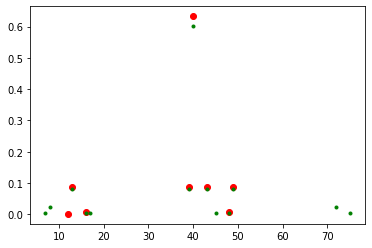

In [142]:
b = []
a = []
for i in range(basis.Ns):
    if (np.abs(psi_var[i])**2>=1e-3):
        b.append(np.abs(psi_var[i])**2)
        a.append(i)
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-3:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
n = []
m = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,1][i])**2>=1e-3:
        n.append(np.abs(eigenvectors[:,1][i])**2) 
        m.append(i)
     


        

plt.plot(a,b, "o",color = "r")
plt.plot(x,y, ".",color = "g")
#plt.plot(m,n, "o",color = "b")


In [140]:
string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])**2>=1e-5:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

(0.0033506886683872155-0.010471816146309017j)|2 2 1 1>
(-0.00293511367136729-0.03452471288506983j)|2 1 1 2>
(0.26615558266569905+0.127614721203146j)|2 1 1 1>
(0.026330131167650893-0.0022281947603430873j)|2 1 0 2>
(-0.07876392825808148-0.022966247407936936j)|2 1 0 1>
(0.026330131167650917-0.0022281947603435114j)|2 0 1 2>
(-0.009683297729539533-0.009808449317519377j)|2 0 1 1>
(0.0037766932832839642-0.0035616561832665537j)|2 0 1 0>
(-0.010089488419438658+0.0023252819402758726j)|2 0 0 2>
(0.012200547845027991+0.00020704997108901324j)|2 0 0 1>
(0.006132464010621815-0.0002685304775670343j)|1 2 0 1>
(0.0033506886683873525-0.01047181614630867j)|1 1 2 2>
(-0.0048962639464360524-0.004972008474904857j)|1 1 2 0>
(0.2661555826656993+0.1276147212031456j)|1 1 1 2>
(-0.7253245223952635-0.3268679835978546j)|1 1 1 1>
(-0.003218307009161053+0.003642738821225287j)|1 1 1 0>
(-0.009683297729540264-0.009808449317518349j)|1 1 0 2>
(0.2655719581828543+0.12775081794904625j)|1 1 0 1>
(-0.005076211117403334+0.012

In [101]:
#initial state
string_0 = "1111"

#for i in range(L):
#    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string_0)


psi_0[i_0] = 1.

In [103]:
psi = ms_gate_global(2*np.pi)@psi_0
string = ""
for i in range(basis.Ns):
    if np.abs(psi[i])**2>=1e-3:
        string+=str(psi[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)
a = ms_gate_global(3*np.pi)

(-1.1729987415527113e-15+0.1464466094067268j)|2 2 2 2>
(-0.35355339059327506-4.608540849148181e-15j)|2 1 2 1>
(-0.3535533905932751-4.7056700676433e-15j)|1 2 1 2>
(1.1941022677129676e-14-0.8535533905932727j)|1 1 1 1>



In [242]:
phi = 0
sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
i = 1
j = 2
sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
print(sigma@sigma)

[[0.25+0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.25+0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j]]
